# Computer Vision Quality Inspection for Thermo Fisher Scientific

---
---
---

## Analysis Overview
This project analyzes over 7k production quality images from Thermo Fisher Scientic (TFS). We will perform Exporatory Data Analysys (EDA) to assess the data, and create machine learning models to predict the outcome of the quality classification of the images.

## Business Problem
[TFS in Hillsboro, Oregon](https://www.thermofisher.com/us/en/home/electron-microscopy/nanoports/hillsboro-nanoport.html) manufactures Scanning Electron Microscopes (SEM).  Liquid Metal Ion Source (LMIS) units are imaged at a SEM and human inspected for qualitative product specifications in production.  This process is costly and can be problematic due to varying human biases. Our goal is to create an automated Computer Vision process that will accurately classify LMIS SEM images, thus reducing labor cost and quality issues incurred due to human biases.

## Data
LMIS SEM images were downloaded from TFS under Non-Disclosure Agreement (NDA):
- 7,019 grayscale SEM image files
- Images pre-labeled and sorted into 5 class folders
- Due to the NDA: 
   - Source image data is not available to the reader; any images in this notebook are scaled down to protect intellectual property (IP).
   - Contextual details containing IP are intentionally omitted from this notebook.

## Summary
This project presents a comprehensive approach to image classification within a manufacturing context, focusing on Exploratory Data Analysis (EDA), data preparation, modeling, and implementation. During EDA, each image was reviewed for classification errors and corrected as needed, in collaboration with a subject matter expert at TFS. It was discovered that a significant portion of non-PASS labeled images also contained features belonging to other non-PASS classes. This is analagous to classifying images of cats vs. dogs, and having many image cases that contain both a cat and a dog. Such images were labeled based on the apparent dominant feature. Class imbalance was also identified and addressed during model training.

For data preparation, images were randomly allocated into training (70%), validation (15%), and test (15%) set folders, ensuring each classification was proportionally represented. Data augmentation techniques were applied during model training to enhance sample variance and mitigate overfitting.

A Convolutional Neural Network (CNN) architecture was selected for its superior performance in computer vision tasks. A baseline multi-classification model was iteratively refined through strategic hyperparameter and architectural adjustments. Models were trained and validated with respective datasets, and performance was evaluated using a holdout test set. Use of Google Colab facilitated the high computational demands of training. The final CNN architecture was selected for its optimal multi-classification accuracy and minimal false-positive rate for the PASS class. A probability threshold adjustment was made to ensure the false-positive rate remained below 1%, thereby minimizing the risk of shipping defective products.

Implementation involved creating a Python executable for image classification, suitable for a production network behind a firewall. Additionally, an interactive PowerBI dashboard was developed to monitor the classifier’s performance trends, pulling data from a CSV log file created by the Python executable.

---
---

## Imports, Globals and Global Functions

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
import joblib
from sklearn.utils import class_weight
from sklearn.metrics import roc_curve, auc
import pickle
from tensorflow.image import resize


# turn off warnings
import warnings
warnings.filterwarnings("ignore")

# style seaborn darkgrid
plt.style.use('seaborn-darkgrid')


In [3]:
# Create or load the dataframe to store model results
try:
    model_results_df = pd.read_csv('data\model_results.csv')
except:
    model_results_df = pd.DataFrame(columns=['Model', 
                                            'Scale Factor', 
                                            'Train Accuracy', 
                                            'Val Accuracy', 
                                            'Test Accuracy', 
                                            'Test Pass FPR' ])
model_results_df

Model  Scale Factor  Train Accuracy  Val Accuracy  Test Accuracy  \
0    Model_Multi_0          0.35        0.922036      0.891892       0.873091   
1    Model_Multi_1          0.35        0.588668      0.583691       0.565093   
2    Model_Multi_2          0.35        0.415314      0.536481       0.517883   
3    Model_Multi_3          0.35        0.821133      0.816881       0.812589   
4    Model_Multi_4          0.35        0.125000      0.336195       0.329041   
5    Model_Multi_5          0.35        0.262787      0.320458       0.320458   
6    Model_Multi_6          0.35        0.937500      0.812589       0.802575   
7    Model_Multi_7          0.55        0.829403      0.859800       0.854077   
8    Model_Multi_8          0.60        0.854518      0.834049       0.841202   
9    Model_Multi_9          0.60        0.750000      0.802575       0.763949   
10  Model_Multi_10          0.60        0.504747      0.628040       0.630901   
11  Model_Multi_11          0.50        0.648086      0.698140       0.690987   
12  Model_Multi_12          0.50        0.601838      0.303779       0.298999   
13  Model_Multi_13          0.55        0.875000      0.854077       0.835479   
14  Model_Multi_14          0.55        0.907955      0.881259       0.849785   
15  Model_Multi_15          0.35        0.874733      0.851216       0.841202   
16  Model_Multi_16          0.35        0.880524      0.864092       0.839771   
17  Model_Multi_17          0.60        0.874124      0.865522       0.865522   
18  Model_Multi_18          0.60        0.901554      0.884120       0.861230   
19  Model_Multi_19          0.60        0.865881      0.870740       0.856639   
20  Model_Multi_20          0.35        0.924041      0.888367       0.875441   
21  Model_Binary_0          0.35        0.969119      0.964747       0.961176   
22  Model_Multi_21          0.35        0.874975      0.868571       0.846667   
23  Model_Multi_22          0.35        0.887782      0.880952       0.863810   
24  Model_Multi_23          0.35        0.875991      0.875238       0.855238   
25  Model_Multi_24          0.35        0.641594      0.669524       0.640952   
26  Model_Multi_25          0.35        0.728400      0.757143       0.758095   
27  Model_Multi_26          0.35        0.773531      0.771429       0.764762   
28  Model_Multi_27          0.35        0.829234      0.826667       0.813333   
29  Model_Multi_28          0.55        0.942468      0.880000       0.835238   
30  Model_Multi_29          0.55        0.874568      0.852381       0.832381   
31  Model_Multi_30          0.35        0.881887      0.871429       0.860000   
32  Model_Multi_31          0.35        0.874975      0.868571       0.802900   
33  Model_Multi_32          0.35        0.875991      0.875238       0.801900   
34  Model_Multi_33          0.55        0.942468      0.880000       0.804800   

    Test Pass FPR  
0          0.0371  
1          0.0611  
2          0.3874  
3          0.0379  
4          0.1137  
5          0.2000  
6          0.0400  
7          0.0232  
8          0.0442  
9          0.0379  
10         0.1474  
11         0.0611  
12         0.2000  
13         0.0484  
14         0.0147  
15         0.0253  
16         0.0295  
17         0.0274  
18         0.0211  
19         0.0611  
20         0.0379  
21         0.0485  
22         0.0297  
23         0.0401  
24         0.0312  
25         0.1439  
26         0.2003  
27         0.0697  
28         0.0448  
29         0.0267  
30         0.0593  
31         0.0490  
32         0.0089  
33         0.0089  
34         0.0089

In [ ]:
# separating the data into sets to avoid data leakage.  Each set will be used in
# separate modeling pipelines.  The data will be split into train, validation, and test sets
# create a utility function to make the train, validation, and test directories
def make_train_val_test_split_folders(data_dir, val_size=0.2, test_size=0.2):
    # initialize the random seed
    np.random.seed(42)

    # create the source and destination directories
    source_dir = os.path.join(data_dir, 'Unsplit')
    dest_dir = os.path.join(data_dir, 'Sets')
    train_dir = os.path.join(dest_dir, 'Train')
    val_dir = os.path.join(dest_dir, 'Validation')
    test_dir = os.path.join(dest_dir, 'Test')
    
    # create the destination directories if they don't exist
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)
    if not os.path.exists(train_dir):
        os.makedirs(train_dir)
    if not os.path.exists(val_dir):
        os.makedirs(val_dir)
    if not os.path.exists(test_dir):
        os.makedirs(test_dir)

    # create a list of unique classes
    classes = os.listdir(source_dir)

    # create a directory for each class in the destination directories
    dest_dirs = [train_dir, val_dir, test_dir]
    for dest_dir in dest_dirs:
        for class_name in classes:
            class_dir = os.path.join(dest_dir, class_name)
            if not os.path.exists(class_dir):
                os.makedirs(class_dir)

    
    # create an array of lists to store the file names for each class
    class_dir_dict = {}
    for class_name in classes:
        class_dir = os.path.join(source_dir, class_name)
        file_list = os.listdir(class_dir)
        class_dir_dict[class_name] = file_list

    # get the sample sizes
    val_contamination_size = int(len(class_dir_dict['Contamination']) * val_size)
    test_contamination_size = int(len(class_dir_dict['Contamination']) * test_size)
    val_pass_size = int(len(class_dir_dict['PASS']) * val_size)
    test_pass_size = int(len(class_dir_dict['PASS']) * test_size)
    val_split_size = int(len(class_dir_dict['Split']) * val_size)
    test_split_size = int(len(class_dir_dict['Split']) * test_size)
    val_dmg_size = int(len(class_dir_dict['Damage']) * val_size)
    test_dmg_size = int(len(class_dir_dict['Damage']) * test_size)
    val_etch_size = int(len(class_dir_dict['Etch']) * val_size)
    test_etch_size = int(len(class_dir_dict['Etch']) * test_size)
    # print the sample sizes
    print(f'         Validation Set - Pass: {val_pass_size}')
    print(f'Validation Set - Contamination: {val_contamination_size}')
    print(f'        Validation Set - Split: {val_split_size}')
    print(f'       Validation Set - Damage: {val_dmg_size}')
    print(f'       Validation Set - Etch: {val_etch_size}')
    print('='*50)
    print(f'               Test Set - Pass: {test_pass_size}')
    print(f'      Test Set - Contamination: {test_contamination_size}')
    print(f'              Test Set - Split: {test_split_size}')
    print(f'             Test Set - Damage: {test_dmg_size}')
    print(f'             Test Set - Etch: {test_etch_size}')
    print('='*50)

    # First copy over the test files
    for class_name in classes:
        class_src_dir = os.path.join(source_dir, class_name)
        class_dest_dir = os.path.join(test_dir, class_name)
        file_list = class_dir_dict[class_name]
        if class_name == 'Contamination':
            sample_size = test_contamination_size
        elif class_name == 'PASS':
            sample_size = test_pass_size
        elif class_name == 'Split':
            sample_size = test_split_size
        elif class_name == 'Damage':
            sample_size = test_dmg_size
        elif class_name == 'Etch':
            sample_size = test_etch_size
        print(f'Copying {sample_size} of files from {class_src_dir} to {class_dest_dir}')
        test_files = np.random.choice(file_list, sample_size, replace=False)
        print(f'Files left in {class_name}: {len(class_dir_dict[class_name])}')
        for file in test_files:
            class_dir_dict[class_name].remove(file)
            print(f'Copying {file} from {class_src_dir} to {class_dest_dir}')
            shutil.copyfile(os.path.join(class_src_dir, file), os.path.join(class_dest_dir, file))
        print(f'Files left in {class_name}: {len(class_dir_dict[class_name])}')


    # Next copy over the val files
    for class_name in classes:
        class_src_dir = os.path.join(source_dir, class_name)
        class_dest_dir = os.path.join(val_dir, class_name)
        file_list = class_dir_dict[class_name]
        if class_name == 'Contamination':
            sample_size = val_contamination_size
        elif class_name == 'PASS':
            sample_size = val_pass_size
        elif class_name == 'Split':
            sample_size = val_split_size
        elif class_name == 'Damage':
            sample_size = val_dmg_size
        elif class_name == 'Etch':
            sample_size = val_etch_size
        print(f'Copying {sample_size} of files from {class_src_dir} to {class_dest_dir}')
        val_files = np.random.choice(file_list, sample_size, replace=False)
        print(f'Files left in {class_name}: {len(class_dir_dict[class_name])}')
        for file in val_files:
            class_dir_dict[class_name].remove(file)
            print(f'Copying {file} from {class_src_dir} to {class_dest_dir}')
            shutil.copyfile(os.path.join(class_src_dir, file), os.path.join(class_dest_dir, file))
        print(f'Files left in {class_name}: {len(class_dir_dict[class_name])}')

    # Copy the rest of the files to the train directory
    for class_name in classes:
        class_src_dir = os.path.join(source_dir, class_name)
        class_dest_dir = os.path.join(train_dir, class_name)
        file_list = class_dir_dict[class_name]
        print(f'Copying the rest of the files from {class_src_dir} to {class_dest_dir}')
        for file in file_list:
            src_file = os.path.join(class_src_dir, file)
            dest_file = os.path.join(class_dest_dir, file)
            print(f'Copying {src_file} to {dest_file}')
            shutil.copyfile(src_file, dest_file)

## Uncomment the following line to create the train, validation, and test directories
## WARNING: This will overwrite the existing directories
# data_dir = 'Data\Raw\images_sorted_multiclass'
# make_train_val_test_split_folders(data_dir, val_size=0.15, test_size=0.15)

In [ ]:
# Create a function for standardized reporting of multi-class model results
# The function will display the classification report, confusion matrix, ROC curve, and training history
# The function will also save the results to a dataframe

# Create a helper function to calculate the false positive rate for PASS class
def false_positive_rate(cm, class_index):
    FP = cm[:, class_index].sum() - cm[class_index, class_index]
    TN = cm.sum() - (cm[class_index, :].sum() + cm[:, class_index].sum() - cm[class_index, class_index])
    FPR = FP / (FP + TN)
    return FPR

# Create a function to report the results of a multi-class model
def report_multi_results(model_name, 
                         scale_factor, 
                         model, 
                         test_generator, 
                         history=None, 
                         pass_max_fpr=1, 
                         metric='categorical_accuracy',
                         val_metric='val_categorical_accuracy'):
    plt.style.use('seaborn-darkgrid')
    plt.style.context('seaborn-darkgrid')

    # Predict the classes of the test images
    y_test_prob = model.predict(test_generator)

    if history is not None:
        # find the index of the best val_accuracy in the history
        best_val_accuracy = max(history.history[val_metric])
        best_val_accuracy_index = history.history[val_metric].index(best_val_accuracy)
        # get the training accuracy at the best val_accuracy
        best_train_accuracy = history.history[metric][best_val_accuracy_index]
        # print the training accuracy
        print('='*50)
        print(f'      Training Accuracy: {best_train_accuracy:.3f}')
        # print the validation accuracy
        print(f'    Validation Accuracy: {best_val_accuracy:.3f}')
    # print the test accuracy
    test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
    print(f' Pre-adjusted Test Accuracy: {test_accuracy:.3f}')
    y_test_true = test_generator.classes
    
    # Adjust the pass class of the probability array by the pass_adjustment
    fpr_pass = 2  # run the loop at least once
    pass_adjustment = 0
    while fpr_pass > pass_max_fpr:
        pass_adjustment -= 0.001
        y_test_prob_adj = y_test_prob.copy()
        y_test_prob_adj[:, 3] = y_test_prob[:, 3] + pass_adjustment
        # Get the predicted classes
        test_pred_classes = np.argmax(y_test_prob_adj, axis=1)
        # Calculate the confusion matrix
        cm = confusion_matrix(y_test_true, test_pred_classes)
        fpr_pass = false_positive_rate(cm, 3)
    print(f'         FPR for PASS class: {fpr_pass:.4f}')
    print(f'Pass Probability Adjustment: {pass_adjustment:.6f}')
    post_adg_test_accuracy = accuracy_score(y_test_true, test_pred_classes)
    print(f'Post-adjusted Test Accuracy: {post_adg_test_accuracy:.4f}')
    print('='*50)

    # Generate a classification report
    report = classification_report(y_test_true, test_pred_classes)
    print(report)

    # Display the confusion matrix
    class_labels = list(test_generator.class_indices.keys())
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    # dark background
    #plt.style.use('dark_background')
    disp.plot()
    plt.title(f'{model_name} Confusion Matrix')
    plt.xticks(rotation=45)
    plt.grid(False)
    plt.show()

    # Create the ROC curve plot for each class in the test data
    lb = LabelBinarizer()
    true_classes_binarized = lb.fit_transform(y_test_true)
    # get the fpr, tpr and roc_auc for each class
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(len(class_labels)):
        fpr[i], tpr[i], _ = roc_curve(true_classes_binarized[:, i], y_test_prob_adj[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot the ROC curve
    plt.figure(figsize=(6, 5.5))
    for i in range(len(class_labels)):
        plt.plot(fpr[i], tpr[i], label=f'(area={roc_auc[i]:.2f}) {class_labels[i]}')
    plt.plot([0, 1], [0, 1], 'k--', color='red')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(False)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

    if history is not None:
        # Display a graph of accuracy for the training and validation sets by epoch
        plt.plot(history.history[metric], label='accuracy')
        plt.plot(history.history[val_metric], label = 'val_accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.ylim([0, 1])
        # add title and labels
        plt.title(f'{model_name} Accuracy')
        plt.gca().get_lines()[0].set_color('red')
        plt.gca().get_lines()[1].set_color('blue')
        plt.legend(loc='lower right')
        plt.show()

        # Save the results to the dataframe
        if model_name not in model_results_df['Model'].values:
            model_results_df.loc[len(model_results_df)] = [model_name, scale_factor, best_train_accuracy, best_val_accuracy, test_accuracy, fpr_pass]
        else:
            model_results_df.loc[model_results_df['Model'] == model_name, 'Scale Factor'] = scale_factor
            model_results_df.loc[model_results_df['Model'] == model_name, 'Train Accuracy'] = best_train_accuracy
            model_results_df.loc[model_results_df['Model'] == model_name, 'Val Accuracy'] = best_val_accuracy
            model_results_df.loc[model_results_df['Model'] == model_name, 'Test Accuracy'] = test_accuracy
            model_results_df.loc[model_results_df['Model'] == model_name, 'Test Pass FPR'] = fpr_pass
    

In [36]:
# Create a function for standardized reporting of binary-class model results
# The function will display the classification report, confusion matrix, ROC curve, and training history
# The function will also save the results to a dataframe
def report_binary_results(model_name, scale_factor, model, history, test_generator):
    plt.style.use('seaborn-darkgrid')
    plt.style.context('seaborn-darkgrid')

    # # get the results of the test set
    # val_loss, val_accuracy = model.evaluate(validation_generator, verbose=0)
    # print('='*50)
    # print(f'Validation Accuracy: {val_accuracy}')

    # # get the results of the test set
    # test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
    # print(f'Test Accuracy: {test_accuracy}')
    # print('='*50)

    # Predict the classes of the test images
    y_test_prob = model.predict(test_generator)
    # Get the predicted classes
    test_pred_classes = (y_test_prob > 0.5).astype(int)

    # find the index of the best val_accuracy in the history
    best_val_accuracy = max(history.history['val_accuracy'])
    best_val_accuracy_index = history.history['val_accuracy'].index(best_val_accuracy)
    # get the training accuracy at the best val_accuracy
    best_train_accuracy = history.history['accuracy'][best_val_accuracy_index]
    # print the training accuracy
    print('='*50)
    print(f'  Training Accuracy: {best_train_accuracy:.3f}')
    # print the validation accuracy
    print(f'Validation Accuracy: {best_val_accuracy:.3f}')
    # print the test accuracy
    test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
    print(f'      Test Accuracy: {test_accuracy:.3f}')
    print('='*50)


    # Get the true test classes
    y_test_true = test_generator.classes
    # Generate a classification report
    report = classification_report(y_test_true, test_pred_classes)
    print(report)
    # Calculate the confusion matrix
    cm = confusion_matrix(y_test_true, test_pred_classes)

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Contam', 'Pass'])
    # dark background
    #plt.style.use('dark_background')
    disp.plot()
    plt.title(f'{model_name} Confusion Matrix')
    plt.xticks(rotation=45)
    plt.grid(False)
    plt.show()

    # Create an ImageDataGenerator for the training set without augmentations
    train_datagen = ImageDataGenerator(rescale=1./65535)

    # create the train generator that doesn't shuffle
    train_generator = train_datagen.flow_from_directory(
            train_dir, 
            target_size= target_size,
            batch_size=16, 
            shuffle=False,
            color_mode='grayscale',
            subset='training',
            class_mode='binary'
    )

    # Predict the classes of the training images
    y_train_prob = model.predict(train_generator)
    # Get the predicted classes
    y_train_true = train_generator.classes

    # Create the ROC curve plot for both the training and test data
    fpr_test, tpr_test, _ = roc_curve(y_test_true, y_test_prob)
    fpr_train, tpr_train, _ = roc_curve(y_train_true, y_train_prob)

    plt.figure(figsize=(6, 5.5))
    plt.plot(fpr_test, tpr_test, label='Test Data', color='blue')
    plt.plot(fpr_train, tpr_train, label='Train Data', color='green')
    plt.plot([0, 1], [0, 1], 'k--', color='red')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    # Display a graph of accuracy for the training and validation sets by epoch
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    # add title and labels
    plt.title(f'{model_name} Accuracy')
    plt.gca().get_lines()[0].set_color('red')
    plt.gca().get_lines()[1].set_color('blue')
    plt.legend(loc='lower right')
    plt.show()

    # Save the results to the dataframe
    if model_name not in model_results_df['Model'].values:
        model_results_df.loc[len(model_results_df)] = [model_name, scale_factor, best_train_accuracy, best_val_accuracy, test_accuracy]
    else:
        model_results_df.loc[model_results_df['Model'] == model_name, 'Scale Factor'] = scale_factor
        model_results_df.loc[model_results_df['Model'] == model_name, 'Train Accuracy'] = best_train_accuracy
        model_results_df.loc[model_results_df['Model'] == model_name, 'Val Accuracy'] = best_val_accuracy
        model_results_df.loc[model_results_df['Model'] == model_name, 'Test Accuracy'] = test_accuracy

    model_results_df

In [8]:
# Create a utility function to get the number of files in each folder in the data directory
# loop through each folder in the data directory and print the number of files in each folder
def get_folder_counts(data_dir):
    classes = os.listdir(data_dir)
    for class_name in classes:
        class_dir = os.path.join(data_dir, class_name)
        file_list = os.listdir(class_dir)
        print(f'Class: {class_name} - {len(file_list)} files')

get_folder_counts('Data\Raw\images_sorted_multiclass\Sets_with_etch\Train')

Class: Contamination - 1168 files
Class: Damage - 433 files
Class: Etch - 725 files
Class: PASS - 1760 files
Class: Split - 833 files


---
---
## EDA and Have a Look at Some Images

Create a function to custom crop and resize the images

In [10]:
# Create a Crop and Resize function for preprocessing the images in the pipeline
# create a function to change the pixel value of the bottom 60 rows of an image to 0
# NOTE: The intention of this function is to remove the footer and useless areas from the images, 
#       however I did not get around to using it in models.  I am leaving it here for future 
#       reference and possible use in a future project models
def crop_and_resize(image, 
                    original_height=943, 
                    original_width=1024,
                    percent_header_crop = 10,        # in % of height
                    percent_footer_crop = 6.3,       # in % of height
                    percent_left_crop = 10,         # in % of width
                    percent_right_crop = 10,        # in % of width
                    scale_factor=1.0):
    '''
    Custom cropping of the image and resizing to allow use in the ImageDataGenerator
    The function will crop the top and bottom of the image by the specified percentages
    The function will crop the left and right of the image by the specified percentages
    The function will resize the image by the specified scale factor
    The function will return the cropped and resized image as a numpy array
    '''
    
    # calculate the new height and width and resize the image
    new_height = int(original_height * scale_factor)
    new_width = int(original_width * scale_factor)
    resized_image = resize(image, [new_height, new_width])

    # calculate the number of pixels to crop from each side
    header_crop_px = int(new_height * percent_header_crop / 100)
    footer_crop_px = -int(new_height * percent_footer_crop / 100)
    left_crop_px = int(new_width * percent_left_crop / 100)
    right_crop_px = -int(new_width * percent_right_crop / 100)

    # crop the image, deal with the special cases where the crop is 0
    if footer_crop_px == 0 and right_crop_px == 0:
        cropped_image = resized_image[header_crop_px:, left_crop_px:, :]   
    elif footer_crop_px == 0:
        cropped_image = resized_image[header_crop_px:, left_crop_px:right_crop_px, :]
    elif right_crop_px == 0:
        cropped_image = resized_image[header_crop_px:footer_crop_px, left_crop_px:, :]
    else:
        cropped_image = resized_image[header_crop_px:footer_crop_px, left_crop_px:right_crop_px, :]

    # resize the cropped image
    cropped_resized_image = resize(cropped_image, [new_height, new_width])
    resized_image = cropped_resized_image.numpy().reshape(new_height, new_width)
    return np.expand_dims(resized_image, axis=2)

Testing the crop_and_resize function in the pipeline

In [38]:
# define the data directory and the image dimensions
data_dir = 'data/raw/images_sorted_multiclass/unsplit'
original_width = 1024
original_height = 943
percent_header_crop = 0
percent_footer_crop = 0
percent_left_crop = 0
percent_right_crop = 0
scale_factor = 0.05   # scaled way down to protect IP

# calculate the new height and width
new_width = int(original_width * scale_factor)
new_height = int(original_height * scale_factor)

# create an ImageDataGenerator with the crop_and_resize function
datagen = ImageDataGenerator(preprocessing_function=lambda x: crop_and_resize(x,
                                                                        percent_header_crop=percent_header_crop, 
                                                                        percent_footer_crop=percent_footer_crop, 
                                                                        percent_left_crop=percent_left_crop, 
                                                                        percent_right_crop=percent_right_crop,
                                                                        scale_factor=scale_factor)
                                                                        # horizontal_flip=True,
                                                                        # height_shift_range=0.05,
                                                                        # fill_mode='constant',
                                                                        # zoom_range=0.05,
                                                                        # brightness_range=[0.8, 1.2]
)

# create the generator
train_generator = datagen.flow_from_directory(
        data_dir, 
        target_size= (new_height, new_width),
        batch_size=32,
        color_mode='grayscale')

# get a batch of images to look at below
train_images, train_labels = next(train_generator)

# display the first image in the batch stats
print(f'Image Shape: {train_images[0].shape}')
print(f'Image Min Pixel: {train_images[0].min()}')
print(f'Image Max Pixel: {train_images[0].max()}')
print(f'new_height: {new_height}')
print(f'new_width: {new_width}')

Found 7019 images belonging to 5 classes.
Image Shape: (47, 51, 1)
Image Min Pixel: 0.0
Image Max Pixel: 65535.0
new_height: 47
new_width: 51


In [17]:
train_generator.class_indices

{'Contamination': 0, 'Damage': 1, 'Etch': 2, 'PASS': 3, 'Split': 4}

Label: [0. 0. 0. 0. 1.]
Image Min Pixel: 0.0
Image Mean Pixel: 18055.8
Image Median Pixel: 9252.0
Image Max Pixel: 65535.0


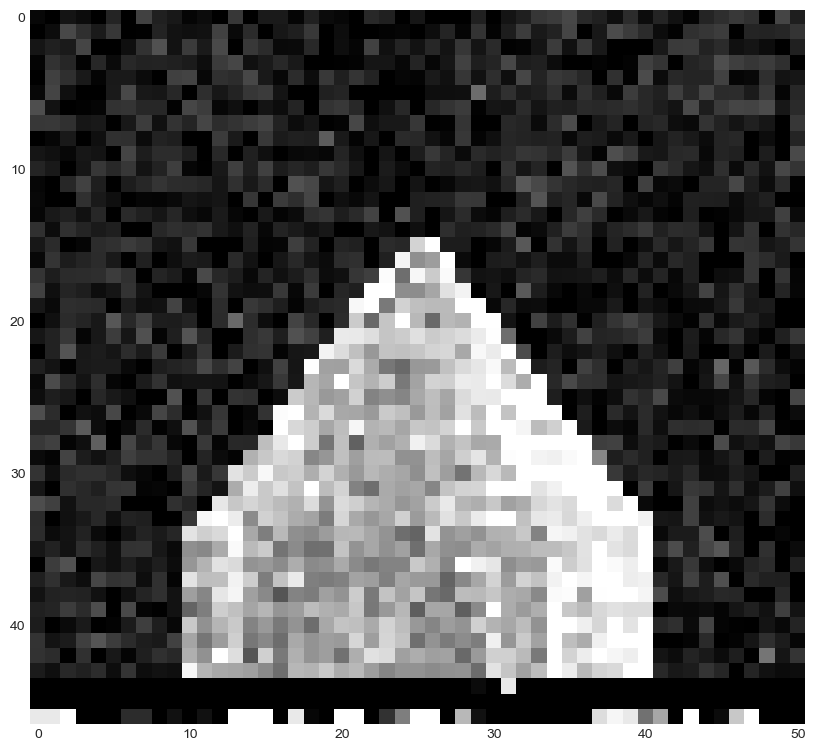

Label: [0. 0. 1. 0. 0.]
Image Min Pixel: 0.0
Image Mean Pixel: 14017.9
Image Median Pixel: 4369.0
Image Max Pixel: 65535.0


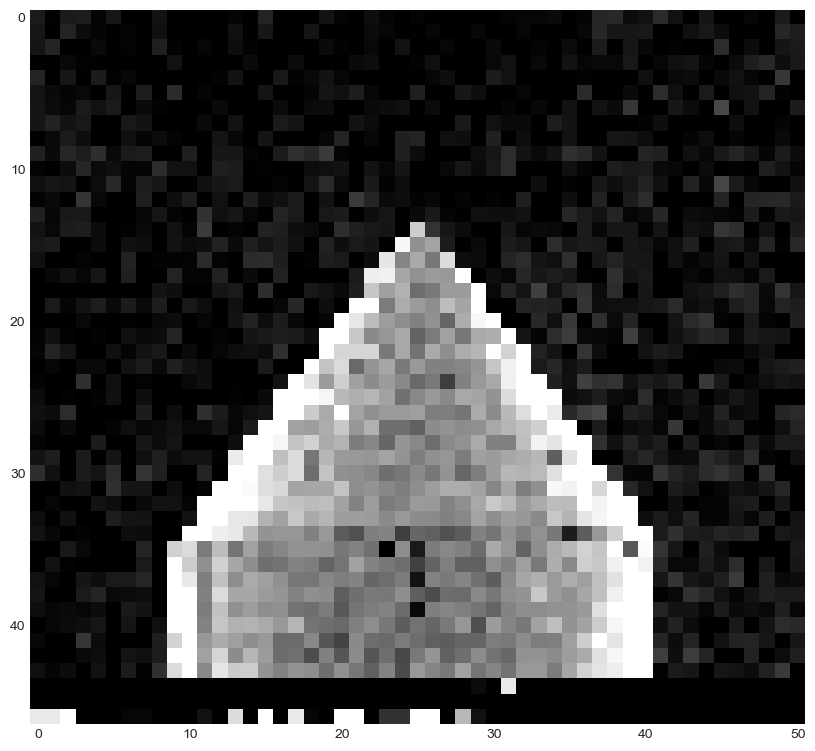

Label: [0. 0. 0. 1. 0.]
Image Min Pixel: 0.0
Image Mean Pixel: 18328.2
Image Median Pixel: 4369.0
Image Max Pixel: 65535.0


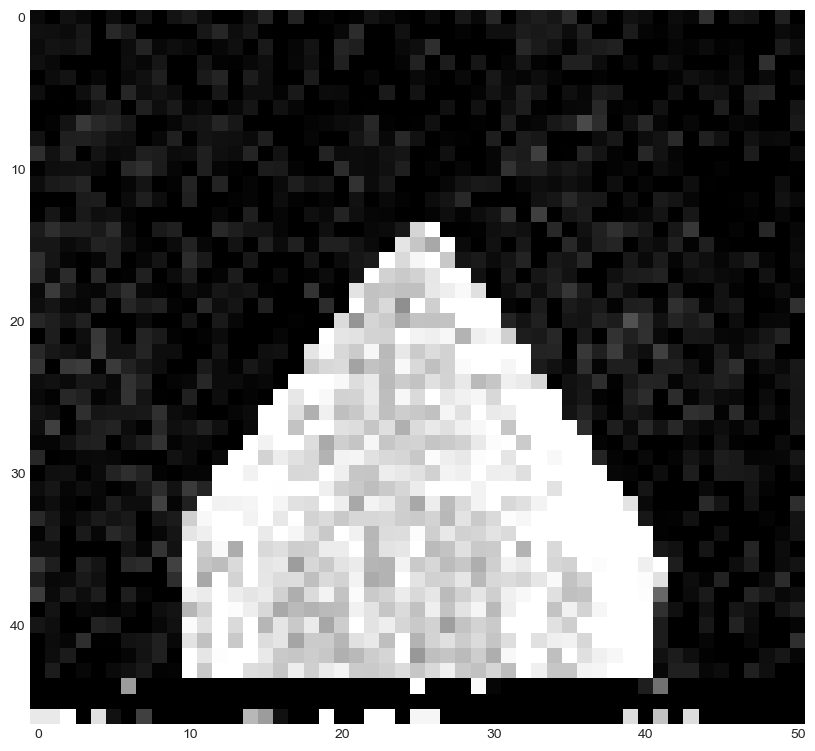

Label: [0. 0. 0. 1. 0.]
Image Min Pixel: 0.0
Image Mean Pixel: 22986.7
Image Median Pixel: 16705.0
Image Max Pixel: 65535.0


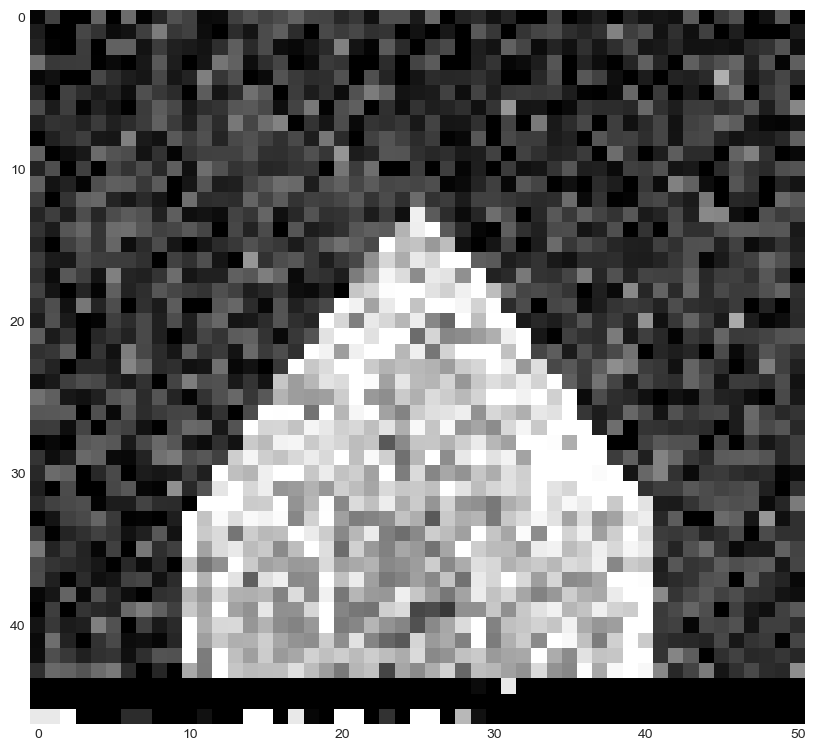

Label: [0. 0. 0. 0. 1.]
Image Min Pixel: 0.0
Image Mean Pixel: 22136.1
Image Median Pixel: 15934.0
Image Max Pixel: 65535.0


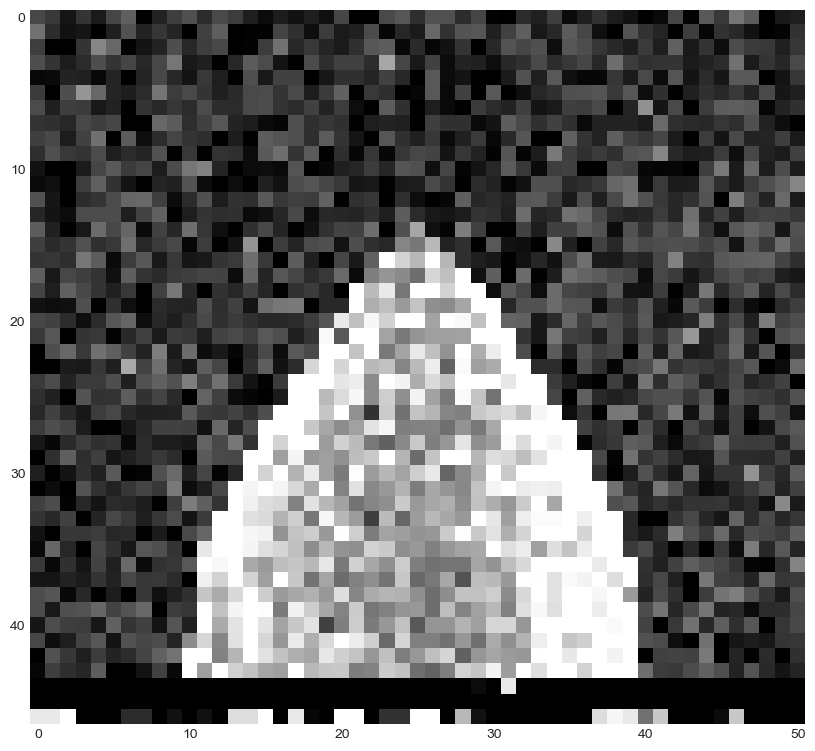

Label: [0. 0. 0. 1. 0.]
Image Min Pixel: 0.0
Image Mean Pixel: 18700.4
Image Median Pixel: 5140.0
Image Max Pixel: 65535.0


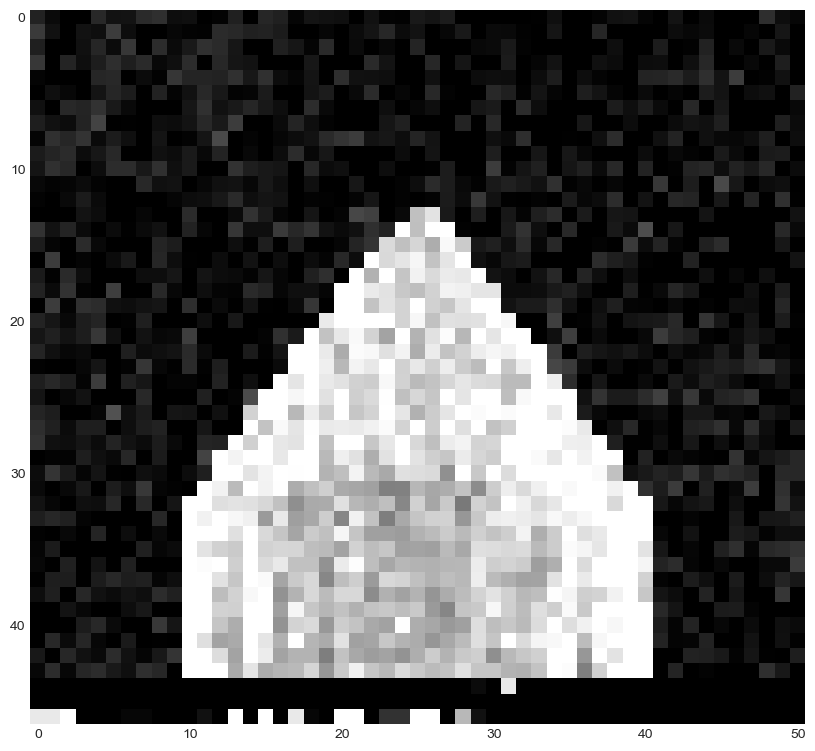

Label: [0. 1. 0. 0. 0.]
Image Min Pixel: 0.0
Image Mean Pixel: 17969.7
Image Median Pixel: 12079.0
Image Max Pixel: 65535.0


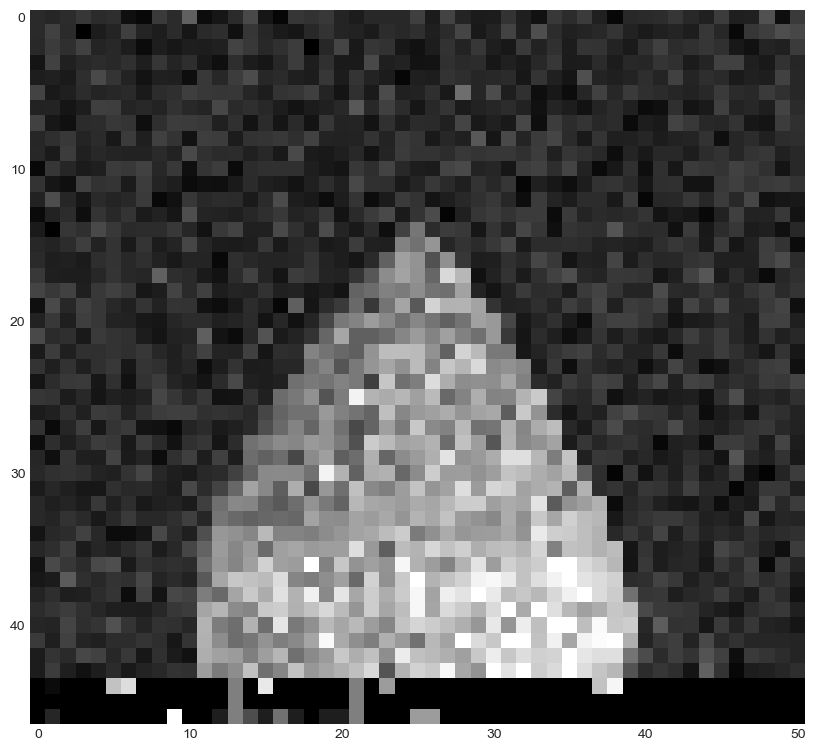

Label: [0. 0. 0. 1. 0.]
Image Min Pixel: 0.0
Image Mean Pixel: 21716.6
Image Median Pixel: 14392.0
Image Max Pixel: 65535.0


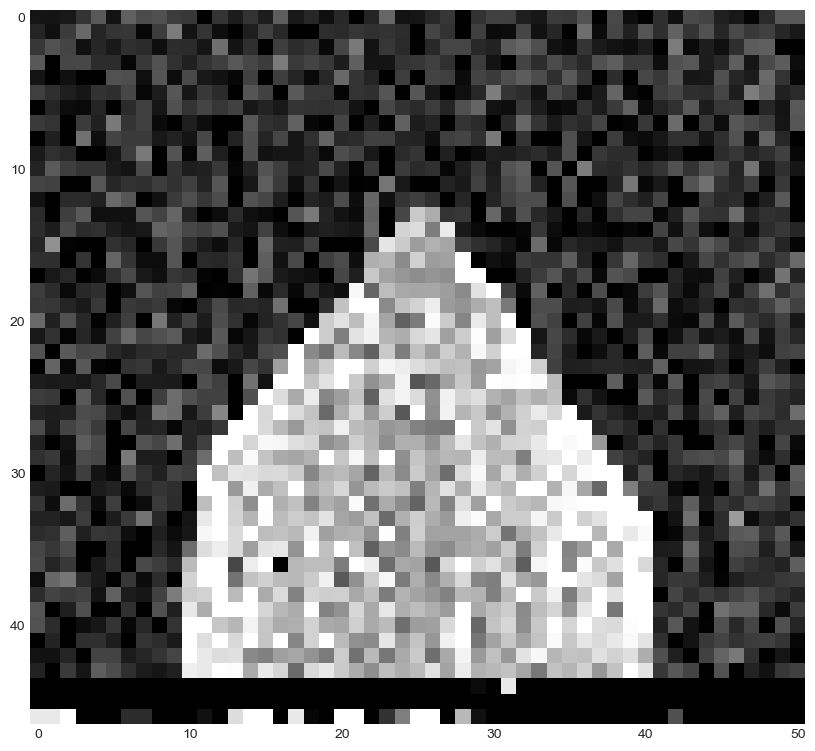

Label: [0. 0. 0. 0. 1.]
Image Min Pixel: 0.0
Image Mean Pixel: 21950.5
Image Median Pixel: 15934.0
Image Max Pixel: 65535.0


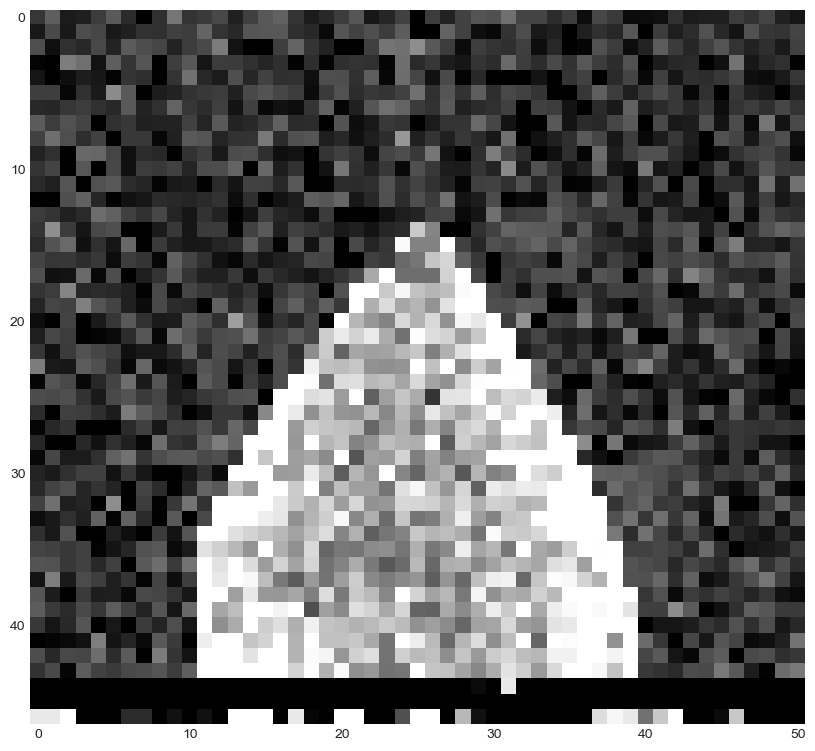

Label: [0. 0. 1. 0. 0.]
Image Min Pixel: 0.0
Image Mean Pixel: 15233.5
Image Median Pixel: 2827.0
Image Max Pixel: 65535.0


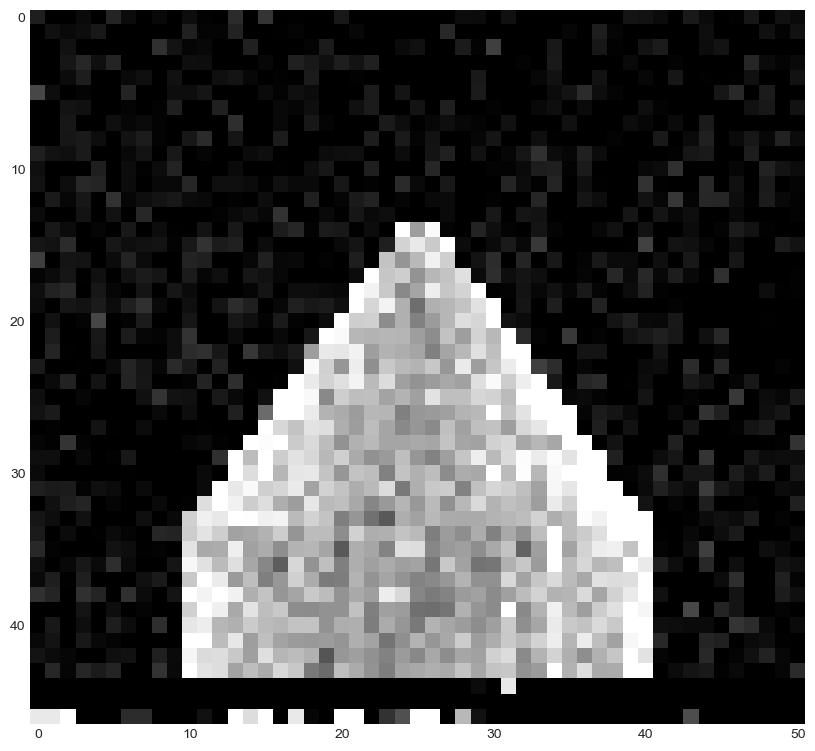

In [39]:
# get the next batch of images
train_images, train_labels = next(train_generator)
# Display the first x images from the training set
for i in np.arange(0, 10):
    print(f'Label: {train_labels[i]}')
    print(f'Image Min Pixel: {train_images[i].min()}')
    print(f'Image Mean Pixel: {train_images[i].mean():.1f}')
    print(f'Image Median Pixel: {np.median(train_images[i])}')
    print(f'Image Max Pixel: {train_images[i].max()}')
    # display the img_cropped image
    plt.imshow(train_images[i], cmap='gray')
    # remove the grid
    plt.grid(False)
    # increase the size of the plot
    plt.gcf().set_size_inches(10, 10)
    plt.show()
    


---
Image Class Distribution

In [26]:
# get the statistics of the images in the entire unsplit dataset
# Get all the data in the directory from all classes
eda_generator = datagen.flow_from_directory(
        data_dir, 
        target_size= (new_height, new_width),
        batch_size=32,
        color_mode='grayscale')

Found 7019 images belonging to 5 classes.


In [27]:
eda_generator.class_indices

{'Contamination': 0, 'Damage': 1, 'Etch': 2, 'PASS': 3, 'Split': 4}

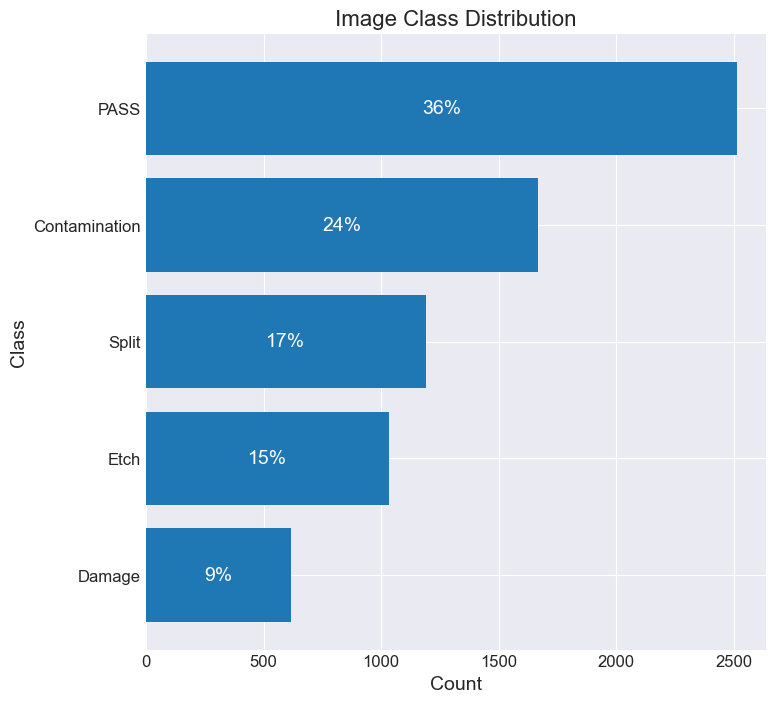

In [30]:
# get the class counts and labels
class_counts = np.bincount(eda_generator.classes)
class_labels = list(eda_generator.class_indices.keys())

# Sort the class labels and counts in descending order
sorted_indices = np.argsort(class_counts)[::-1]
sorted_class_counts = class_counts[sorted_indices]
sorted_class_labels = [class_labels[i] for i in sorted_indices]

# Calculate the percentage of total for each class
total_counts = np.sum(sorted_class_counts)
percentages = (sorted_class_counts / total_counts) * 100

# Create a bar plot of the class distribution
font_size = 14
plt.barh(sorted_class_labels, sorted_class_counts)
plt.xlabel('Count', fontsize=font_size)
plt.ylabel('Class', fontsize=font_size)
plt.title('Image Class Distribution', fontsize=font_size+2)
# set the font size of the x and y ticks
plt.xticks(fontsize=font_size-2)
plt.yticks(fontsize=font_size-2)
plt.gcf().set_size_inches(8, 8)
plt.gca().invert_yaxis()

# Add percentage labels to each bar, centered
for i, (count, percentage) in enumerate(zip(sorted_class_counts, percentages)):
    plt.text(count / 2, i, f'{percentage:.0f}%', 
             va='center', 
             ha='center',
             color='white',
             fontsize=font_size)
    
plt.show()


    ANALYSIS
- Class imbalance exists that will need to be dealt with in the model training
- Maki note that the Damage class is very small proportionally, may come into account in our results


---
---
## First Model Attempts
- Much exploration and fumbling was done in the beginning before figuring out a model and pipeline that worked correctly
- Several models were run early on without creating a holdout test set
- Several models were run without going back through and relabeling every image
- Was running all models on local laptop, which was making data turns very very slow


---
### Baseline (Model 0)
- Was only using a train and validation set in the beginning
- 1 conv + pooling layer, no hidden MLP layers


In [ ]:

data_dir = 'data/raw/images_sorted_multiclass'
original_width = 1024
original_height = 943
scale_factor = 0.1
target_size = (int(original_height*scale_factor), int(original_width*scale_factor))

# Create an ImageDataGenerator with rescaling and the custom preprocessing function
datagen = ImageDataGenerator(rescale=1./65535, validation_split=0.2)

# create the train generator
train_generator = datagen.flow_from_directory(
        data_dir, 
        target_size= target_size,
        batch_size=16, 
        shuffle=True,
        color_mode='grayscale',
        subset='training',
        class_mode='categorical',
        seed=42)

# create the validation generator
validation_generator = datagen.flow_from_directory(
        data_dir, 
        target_size= target_size,
        batch_size=16, 
        shuffle=False,
        color_mode='grayscale',
        subset='validation',
        class_mode='categorical',
        seed=42)



input_shape = (target_size[0], target_size[1], 1)
# Define a simple model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(5, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Calculate steps per epoch
steps_per_epoch = len(train_generator)

# Train the model using the generators
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=1, validation_data=validation_generator)

Found 13341 images belonging to 5 classes.
Found 3333 images belonging to 5 classes.
834/834 [==============================] - 153s 183ms/step - loss: 0.7660 - categorical_accuracy: 0.7754 - val_loss: 1.2863 - val_categorical_accuracy: 0.5488


  Training categorical accuracy: 0.7753541469573975
Validation categorical accuracy: 0.548754870891571
               precision    recall  f1-score   support

Contamination       0.10      0.11      0.11       286
 Etch Failure       0.25      0.39      0.30       344
         PASS       0.86      0.69      0.76      2243
    Split Tip       0.00      0.00      0.00       263
   Tip Damage       0.19      0.64      0.29       197

     accuracy                           0.55      3333
    macro avg       0.28      0.37      0.29      3333
 weighted avg       0.63      0.55      0.57      3333



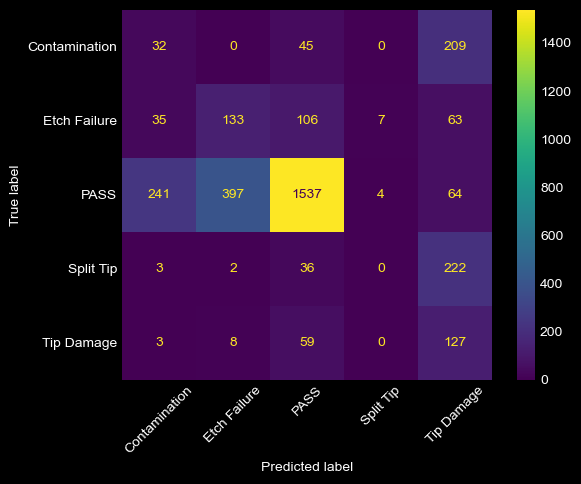

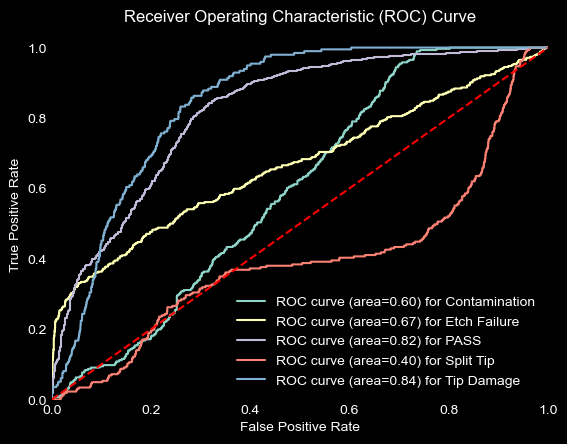

In [ ]:
# This was an earlier version of model reporting that was overwritten by the function above
# Due to time constraints, I did not have time to refactor this code into the function above
# because of the long run times for retraining the models
model_results = report_model_performance(model, history, validation_generator)

--> ANALYSIS <---
- Accuracy of 0.67 on the validation is not fantastic considering there is a majority class (which we will need to deal with by applying class weights or undersampling).  Some things we can do to potentially improve accuracy:
    - Increase the scale factor, 0.1 is quite small and only used for running fast models. Probably why we are not catching Split Tip, because the feature is lost when scaled down.
    - Much more re-labeling needs to be done, the labels are quite messy
- Looks like we are overfitting, there is about 10% better accuracy on the training set than the validation set.  
    - We can try dropout and L1 regularization to deal with this.

---
### Model 1
Changes:
- Increased the scale factor to 1.0
    - Reasoning: want to see the difference with just one epoch at full image resolution

In [ ]:

num_epochs = 1
scale_factor = 1
target_size = (int(original_height*scale_factor), int(original_width*scale_factor))

# Create an ImageDataGenerator with rescaling and the custom preprocessing function
datagen = ImageDataGenerator(rescale=1./65535, validation_split=0.2)

# create the train generator
train_generator = datagen.flow_from_directory(
        data_dir, 
        target_size= target_size,
        batch_size=16, 
        shuffle=True,
        color_mode='grayscale',
        subset='training',
        class_mode='categorical',
        seed=42)

# create the validation generator
validation_generator = datagen.flow_from_directory(
        data_dir, 
        target_size= target_size,
        batch_size=16, 
        shuffle=False,                          # turning off shuffle for the val set to get consistent reporting
        color_mode='grayscale',
        subset='validation',
        class_mode='categorical',
        seed=42)


# Define a simple model
input_shape = (target_size[0], target_size[1], 1)
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(5, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Calculate steps per epoch
steps_per_epoch = len(train_generator)

# Train the model using the generators
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, validation_data=validation_generator)



Found 13341 images belonging to 5 classes.
Found 3333 images belonging to 5 classes.
834/834 [==============================] - 3185s 4s/step - loss: 2.6558 - categorical_accuracy: 0.7531 - val_loss: 1.7140 - val_categorical_accuracy: 0.3819


  Training categorical accuracy: 0.7753541469573975
Validation categorical accuracy: 0.548754870891571
               precision    recall  f1-score   support

Contamination       0.05      0.21      0.08       286
 Etch Failure       0.66      0.32      0.43       344
         PASS       0.85      0.44      0.58      2243
    Split Tip       0.01      0.01      0.01       263
   Tip Damage       0.20      0.56      0.30       197

     accuracy                           0.38      3333
    macro avg       0.35      0.31      0.28      3333
 weighted avg       0.66      0.38      0.46      3333



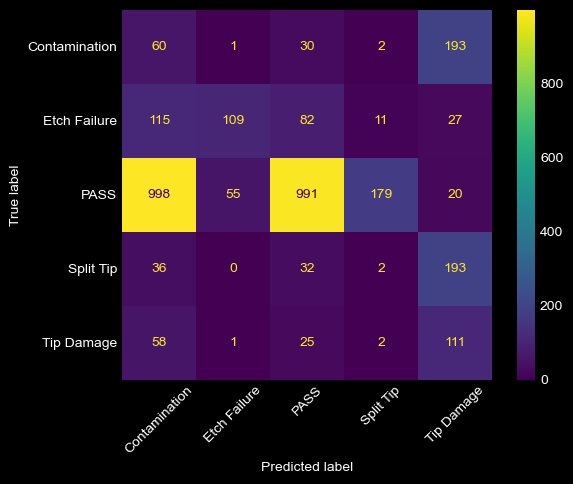

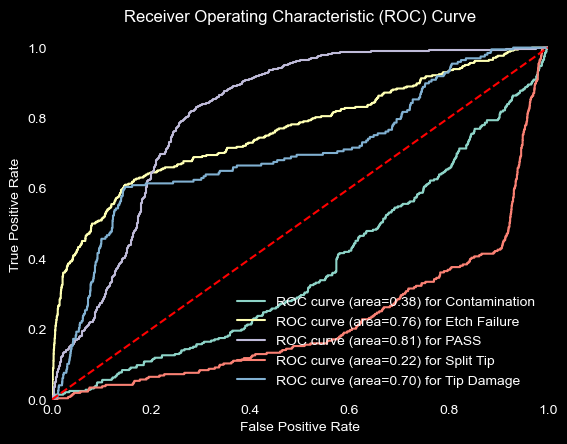

In [ ]:
# This was an earlier version of model reporting that was overwritten by the function above
# Due to time constraints, I did not have time to refactor this code into the function above
# because of the long run times for retraining the models
model_results = report_model_performance(model, history, validation_generator)

In [ ]:
# This was an earlier version of model reporting that was overwritten by the function above
# Due to time constraints, I did not have time to refactor this code into the function above
# because of the long run times for retraining the models
model_results_df.sort_values(by='Val Accuracy', ascending=False)

Model  Train Accuracy  Val Accuracy
0             Model 2        0.786037      0.690141
1  Baseline (Model 0)        0.775354      0.548755
2             Model 1        0.753100      0.381900

--> ANALYSIS <---
- Interesting that we did so much worse by increasing the resolution scale to 1.0.  
    - Need more training?
    - Need to correct labels?

---
### Model 2
Changes:
- Removed incorrectly classified images from the Contamination folder
- Reduced the quantity of images in the PASS folder to better balance the targets

In [ ]:
get_folder_counts()

Class: Contamination - 1094 files
Class: Etch Failure - 1724 files
Class: PASS - 1800 files
Class: Split Tip - 1321 files
Class: Tip Damage - 988 files


In [ ]:

num_epochs = 1
scale_factor = 0.1
target_size = (int(original_height*scale_factor), int(original_width*scale_factor))

# Create an ImageDataGenerator with rescaling and the custom preprocessing function
datagen = ImageDataGenerator(rescale=1./65535, validation_split=0.2)

# create the train generator
train_generator = datagen.flow_from_directory(
        data_dir, 
        target_size= target_size,
        batch_size=16, 
        shuffle=True,
        color_mode='grayscale',
        subset='training',
        class_mode='categorical',
        seed=42)

# create the validation generator
validation_generator = datagen.flow_from_directory(
        data_dir, 
        target_size= target_size,
        batch_size=16, 
        shuffle=False,
        color_mode='grayscale',
        subset='validation',
        class_mode='categorical',
        seed=42)



input_shape = (target_size[0], target_size[1], 1)
# Define a simple model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(5, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Calculate steps per epoch
steps_per_epoch = len(train_generator)

# Train the model using the generators
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, validation_data=validation_generator)

Found 5544 images belonging to 5 classes.
Found 1382 images belonging to 5 classes.
347/347 [==============================] - 65s 186ms/step - loss: 0.9403 - categorical_accuracy: 0.6768 - val_loss: 1.7536 - val_categorical_accuracy: 0.3256


  Training categorical accuracy: 0.6767676472663879
Validation categorical accuracy: 0.3256150484085083
Number of predictions: 1382
               precision    recall  f1-score   support

Contamination       0.42      0.22      0.28       218
 Etch Failure       0.92      0.22      0.36       344
         PASS       0.53      0.46      0.49       359
    Split Tip       0.08      0.08      0.08       264
   Tip Damage       0.22      0.71      0.34       197

     accuracy                           0.33      1382
    macro avg       0.43      0.34      0.31      1382
 weighted avg       0.48      0.33      0.33      1382



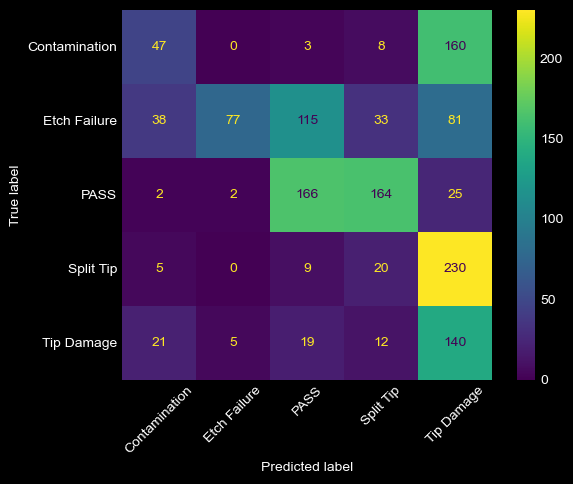

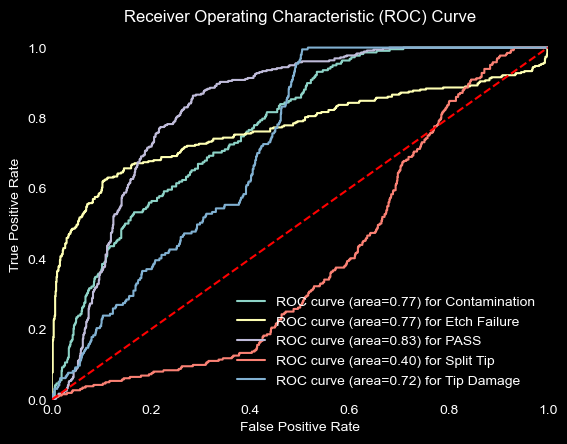

In [ ]:
# This was an earlier version of model reporting that was overwritten by the function above
# Due to time constraints, I did not have time to refactor this code into the function above
# because of the long run times for retraining the models
report_model_performance('Model 2', model, history, validation_generator)

In [ ]:
# This was an earlier version of model reporting that was overwritten by the function above
# Due to time constraints, I did not have time to refactor this code into the function above
# because of the long run times for retraining the models
model_results_df.sort_values(by='Val Accuracy', ascending=False)

Model  Train Accuracy  Val Accuracy
0  Model 3        0.713925      0.426918

--> ANALYSIS <---
- The results are more realistic now that the classes are more even.
- Not sure about the disparity between training and validation, I guess regularization is needed.  Surprising to be over fitted after only 1 epoch
- Getting a little better result from contamination, need to see whats going on in the tip damage folder, may be a lot of true contam in there
- Curious we are doing so well in Etch Failure, need to look at those images
- Split tip may not do well at such low resolution scaling because the feature is more difficult to discern


---
### Model 3
Changes:
- Adding dropout regularization after the convolutions at 0.5 rate
- Adding a second layer of Convolution with 3x3 kernel and 64 filters
- Increasing scale factor to 0.25

In [ ]:
get_folder_counts()

Class: Contamination - 1161 files
Class: Etch Failure - 1724 files
Class: PASS - 1499 files
Class: Split Tip - 1323 files
Class: Tip Damage - 989 files


In [ ]:

num_epochs = 3
scale_factor = 0.35
target_size = (int(original_height*scale_factor), int(original_width*scale_factor))

# Create an ImageDataGenerator with rescaling and the custom preprocessing function
datagen = ImageDataGenerator(rescale=1./65535, validation_split=0.2)

# create the train generator
train_generator = datagen.flow_from_directory(
        data_dir, 
        target_size= target_size,
        batch_size=16, 
        shuffle=True,
        color_mode='grayscale',
        subset='training',
        class_mode='categorical',
        seed=42)

# create the validation generator
validation_generator = datagen.flow_from_directory(
        data_dir, 
        target_size= target_size,
        batch_size=16, 
        shuffle=False,
        color_mode='grayscale',
        subset='validation',
        class_mode='categorical',
        seed=42)



input_shape = (target_size[0], target_size[1], 1)
# Define a simple model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Calculate steps per epoch
steps_per_epoch = len(train_generator)

# Train the model using the generators
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, validation_data=validation_generator)

Found 5544 images belonging to 5 classes.
Found 1382 images belonging to 5 classes.
Epoch 1/3
347/347 [==============================] - 303s 872ms/step - loss: 1.2529 - categorical_accuracy: 0.5583 - val_loss: 1.6338 - val_categorical_accuracy: 0.3857
Epoch 2/3
347/347 [==============================] - 296s 854ms/step - loss: 0.9053 - categorical_accuracy: 0.6831 - val_loss: 1.7138 - val_categorical_accuracy: 0.4074
Epoch 3/3
347/347 [==============================] - 306s 881ms/step - loss: 0.8112 - categorical_accuracy: 0.7139 - val_loss: 1.8917 - val_categorical_accuracy: 0.4269


  Training categorical accuracy: 0.7139249444007874
Validation categorical accuracy: 0.42691752314567566
Number of predictions: 1382
               precision    recall  f1-score   support

Contamination       0.36      0.18      0.24       218
 Etch Failure       0.82      0.22      0.35       344
         PASS       0.58      0.96      0.73       359
    Split Tip       0.12      0.01      0.02       264
   Tip Damage       0.22      0.64      0.33       197

     accuracy                           0.43      1382
    macro avg       0.42      0.40      0.33      1382
 weighted avg       0.47      0.43      0.36      1382



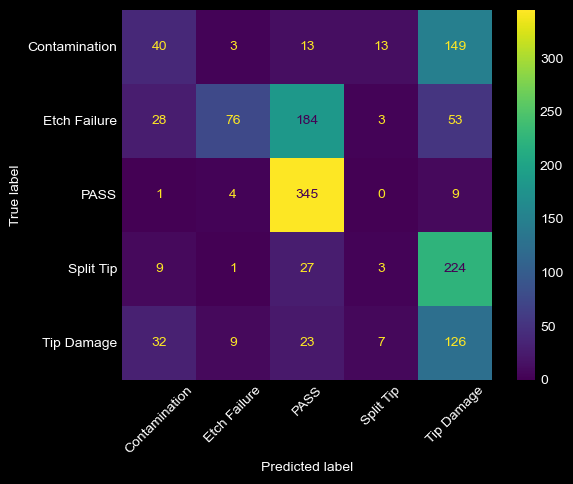

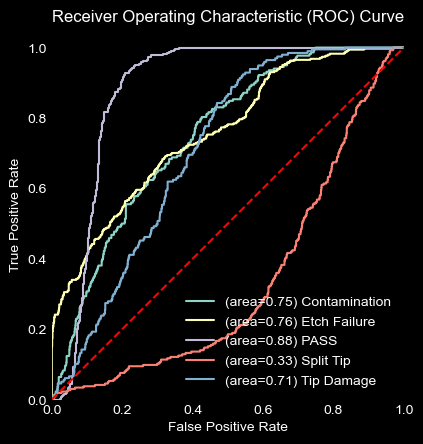

In [ ]:
# This was an earlier version of model reporting that was overwritten by the function above
# Due to time constraints, I did not have time to refactor this code into the function above
# because of the long run times for retraining the models
report_model_performance('Model 3', model, history, validation_generator)

In [ ]:
# This was an earlier version of model reporting that was overwritten by the function above
# Due to time constraints, I did not have time to refactor this code into the function above
# because of the long run times for retraining the models
model_results_df.sort_values(by='Val Accuracy', ascending=False)

Model  Train Accuracy  Val Accuracy
0  Model 3        0.713925      0.426918

--> ANALYSIS <---
- Modest improvement in accuracy, however still overfitting.
- Far fewer false positives for PASS now.  
- Probably all moot until I get the labels fixed.



---
### Model 4
Changes:
- Blacking out the footer to eliminate any inforation the model might be training there
    - Note: optimally I would just remove the footer rows from the image during pre-process, but I haven't been able to get this to work with the ImageDataGenerator because it changes the target size and it throws an error. (This was later resolved by the custom cropping function defined in the first section)

In [ ]:
# create a function to change the pixel value of the bottom 60 rows of an image to 0
def blackout_footer(image):
    image[-60:, :] = 0
    return image

In [ ]:

num_epochs = 3
scale_factor = 0.35
target_size = (int(original_height*scale_factor), int(original_width*scale_factor))

# Create an ImageDataGenerator with rescaling and the custom preprocessing function
datagen = ImageDataGenerator(rescale=1./65535, validation_split=0.2) #, preprocessing_function=blackout_footer)

# create the train generator
train_generator = datagen.flow_from_directory(
        data_dir, 
        target_size= target_size,
        batch_size=16, 
        shuffle=True,
        color_mode='grayscale',
        subset='training',
        class_mode='categorical',
        seed=42)

# create the validation generator
validation_generator = datagen.flow_from_directory(
        data_dir, 
        target_size= target_size,
        batch_size=16, 
        shuffle=False,
        color_mode='grayscale',
        subset='validation',
        class_mode='categorical',
        seed=42)


input_shape = (target_size[0], target_size[1], 1)
# Define a simple model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Calculate steps per epoch
steps_per_epoch = len(train_generator)

# Train the model using the generators
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, validation_data=validation_generator)

Found 5544 images belonging to 5 classes.
Found 1382 images belonging to 5 classes.
Epoch 1/3
347/347 [==============================] - 315s 909ms/step - loss: 1.2632 - categorical_accuracy: 0.5651 - val_loss: 1.7261 - val_categorical_accuracy: 0.3893
Epoch 2/3
347/347 [==============================] - 318s 916ms/step - loss: 0.8819 - categorical_accuracy: 0.7063 - val_loss: 1.8540 - val_categorical_accuracy: 0.4247
Epoch 3/3
347/347 [==============================] - 327s 941ms/step - loss: 0.8014 - categorical_accuracy: 0.7307 - val_loss: 2.3720 - val_categorical_accuracy: 0.4081


  Training categorical accuracy: 0.7306998372077942
Validation categorical accuracy: 0.40810421109199524
Number of predictions: 1382
               precision    recall  f1-score   support

Contamination       0.31      0.26      0.28       218
 Etch Failure       0.89      0.25      0.39       344
         PASS       0.65      0.80      0.72       359
    Split Tip       0.12      0.05      0.07       264
   Tip Damage       0.22      0.62      0.33       197

     accuracy                           0.41      1382
    macro avg       0.44      0.40      0.36      1382
 weighted avg       0.49      0.41      0.39      1382



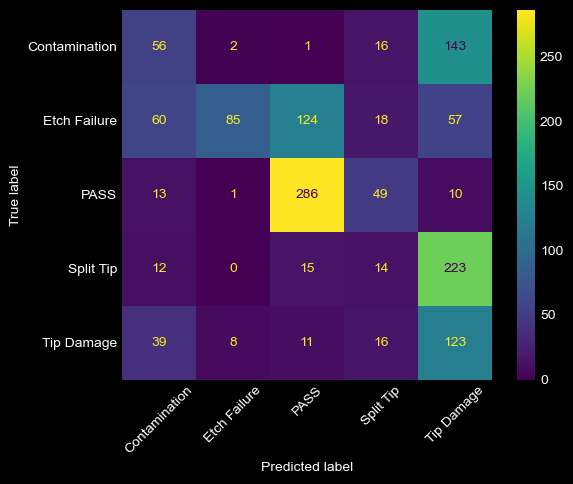

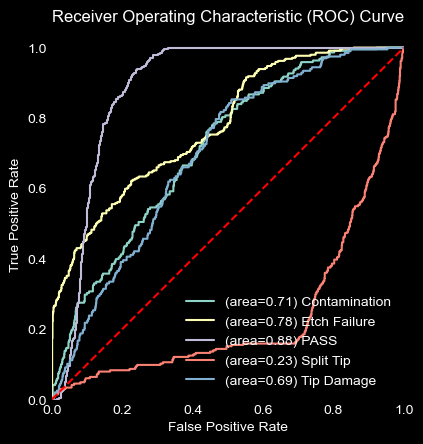

In [ ]:
# This was an earlier version of model reporting that was overwritten by the function above
# Due to time constraints, I did not have time to refactor this code into the function above
# because of the long run times for retraining the models
report_model_performance('Model 4', model, history, validation_generator)

In [ ]:
# This was an earlier version of model reporting that was overwritten by the function above
# Due to time constraints, I did not have time to refactor this code into the function above
# because of the long run times for retraining the models
model_results_df.sort_values(by='Val Accuracy', ascending=False)

Model  Train Accuracy  Val Accuracy
0  Model 3        0.713925      0.426918
1  Model 4        0.730700      0.408104

--> ANALYSIS <---
- Model 4 is the same as Model 3. Originally I ran Model 4 with the blackout_footer function (which I tested visually ok far above), and for some reason it sent most of the PASS images into Split Tip.  I don't understand this at all, my first thought is that it shifted the labels somehow for the confusion matrix, but it only effected the PASS class.
- Need to investigate a better method for removing the footer, and do need to remove the footer.
- STILL NEED TO FIX ALL THE LABELS!!!


---
### Model 5
Changes:
- Attempting the crop footer function again using crop_footer_and_resize

In [ ]:


num_epochs = 10
original_width = 1024
original_height = 943
scale_factor = 1
target_size = (int(original_height*scale_factor), int(original_width*scale_factor))

# Create an ImageDataGenerator with rescaling and the custom preprocessing function
datagen = ImageDataGenerator(rescale=1./65535, validation_split=0.2, preprocessing_function=crop_and_resize)

# create the train generator
train_generator = datagen.flow_from_directory(
        data_dir, 
        target_size= target_size,
        batch_size=16, 
        shuffle=True,
        color_mode='grayscale',
        subset='training',
        class_mode='categorical',
        seed=42)

# create the validation generator
validation_generator = datagen.flow_from_directory(
        data_dir, 
        target_size= target_size,
        batch_size=16, 
        shuffle=False,
        color_mode='grayscale',
        subset='validation',
        class_mode='categorical',
        seed=42)


input_shape = (target_size[0], target_size[1], 1)
# Define a simple model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),   # padding
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),       # more dense
    Dropout(0.5),                   # move up
    Dense(5, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# instantiate early stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=3)#, restore_best_weights=True)

# Calculate steps per epoch
steps_per_epoch = len(train_generator)

# Train the model using the generators
model5_trained = True
if model5_trained:
    model = joblib.load('Models\\model_5.pkl')
else:
        history = model.fit(train_generator, 
                        steps_per_epoch=steps_per_epoch, 
                        epochs=num_epochs,
                        validation_data=validation_generator,
                        callbacks=[early_stopping])

Found 5355 images belonging to 5 classes.
Found 1335 images belonging to 5 classes.
Epoch 1/10
335/335 [==============================] - 2349s 7s/step - loss: 2.9118 - categorical_accuracy: 0.4788 - val_loss: 1.6475 - val_categorical_accuracy: 0.3004
Epoch 2/10
335/335 [==============================] - 2337s 7s/step - loss: 0.9376 - categorical_accuracy: 0.6697 - val_loss: 1.7703 - val_categorical_accuracy: 0.3184
Epoch 3/10
335/335 [==============================] - 2330s 7s/step - loss: 0.7660 - categorical_accuracy: 0.7300 - val_loss: 2.0397 - val_categorical_accuracy: 0.3363
Epoch 4/10
335/335 [==============================] - 2333s 7s/step - loss: 0.5802 - categorical_accuracy: 0.7965 - val_loss: 1.9335 - val_categorical_accuracy: 0.3438
Epoch 5/10
335/335 [==============================] - 2344s 7s/step - loss: 0.4133 - categorical_accuracy: 0.8551 - val_loss: 2.6148 - val_categorical_accuracy: 0.3236
Epoch 6/10
335/335 [==============================] - 2332s 7s/step - loss: 

  Training categorical accuracy: 0.9159663915634155
Validation categorical accuracy: 0.31910112500190735
Number of predictions: 1335
               precision    recall  f1-score   support

Contamination       0.43      0.47      0.45       242
 Etch Failure       0.79      0.39      0.52       342
         PASS       0.22      0.08      0.12       299
    Split Tip       0.12      0.18      0.15       266
   Tip Damage       0.26      0.58      0.36       186

     accuracy                           0.32      1335
    macro avg       0.37      0.34      0.32      1335
 weighted avg       0.39      0.32      0.32      1335



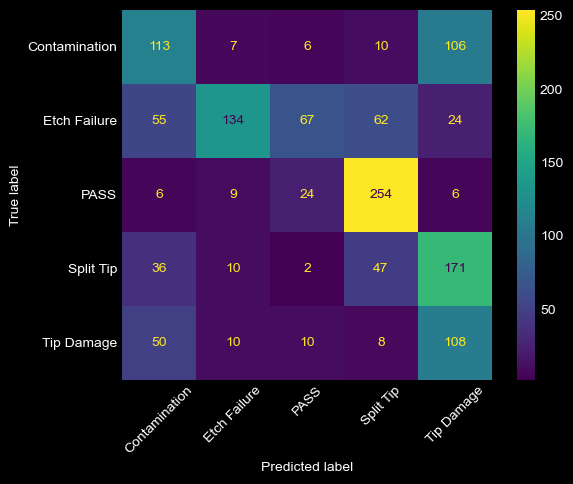

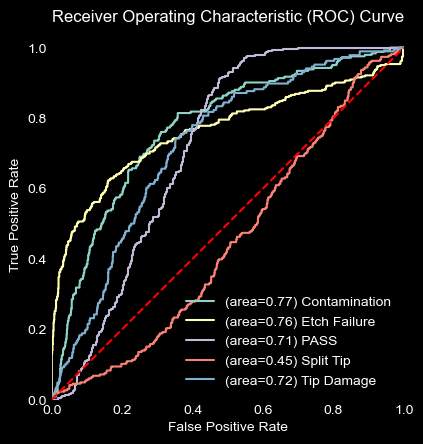

In [ ]:
# This was an earlier version of model reporting that was overwritten by the function above
# Due to time constraints, I did not have time to refactor this code into the function above
# because of the long run times for retraining the models
report_model_performance('Model 5', model, history, validation_generator)

In [ ]:
# This was an earlier version of model reporting that was overwritten by the function above
# Due to time constraints, I did not have time to refactor this code into the function above
# because of the long run times for retraining the models
model_results_df.sort_values(by='Val Accuracy', ascending=False)

Model  Train Accuracy  Val Accuracy
0  Model 3        0.713925      0.426918
1  Model 4        0.730700      0.408104

--> ANALYSIS <---
- Model 5 is still overfitting and not performing well.
- Cause for the shift in pass to split tip when removing the footer is still unknown, going to backburner for now

---
### Model 6
Changes:
- Going to simplify to only PASS and Contamination as those labels have been cleaned and the signal should be strong
- Leaving out cropping
- Adding more dense layers and batch normalization
- Changing the output to binary, signmoid
- Changed to steps_per_epoch = train_generator.samples // train_generator.batch_size to fully use all training data
- Added data augmentation in the ImageDataGenerator; horizontal_flip, zoom_range, height_shift_range

In [ ]:
# change the data directory since we are doing binary classification
train_dir = 'Data\Raw\images_sorted_binary_contamOnly\Split\Train'
# check the image counts
get_folder_counts(train_dir)

Class: Contamination - 851 files
Class: PASS - 1051 files


In [ ]:
# change the data directory since we are doing binary classification
val_dir = 'Data\Raw\images_sorted_binary_contamOnly\Split\Validation'
# check the image counts
get_folder_counts(val_dir)

Class: Contamination - 182 files
Class: PASS - 224 files


In [ ]:

num_epochs = 50
original_width = 1024
original_height = 943
scale_factor = 0.35
target_size = (int(original_height*scale_factor), int(original_width*scale_factor))

# Create an ImageDataGenerator for the training set with augmentations
train_datagen = ImageDataGenerator(rescale=1./65535, 
                                   validation_split=0.2,
                                   horizontal_flip=True,
                                   zoom_range=0.05,
                                   height_shift_range=0.05)

# Create an ImageDataGenerator for the validation set without augmentations
val_datagen = ImageDataGenerator(rescale=1./65535, 
                                 validation_split=0.2)


# create the train generator
train_generator = train_datagen.flow_from_directory(
        train_dir, 
        target_size= target_size,
        batch_size=16, 
        shuffle=True,
        color_mode='grayscale',
        subset='training',
        class_mode='binary',
        seed=42
)

# create the validation generator
validation_generator = val_datagen.flow_from_directory(
        val_dir, 
        target_size= target_size,
        batch_size=16, 
        shuffle=False,
        color_mode='grayscale',
        subset='validation',
        class_mode='binary',
        seed=42
)


input_shape = (target_size[0], target_size[1], 1)
# Define a simple model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='valid'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='valid'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# instantiate early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

from tensorflow.keras.callbacks import ModelCheckpoint

# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    filepath='Models\model6_epoch_{epoch:02d}.h5',  # Save the model with the epoch number in the filename
    save_weights_only=False,  # Save the full model (architecture + weights)
    save_freq='epoch'  # Save the model at the end of each epoch
)


# Calculate steps per epoch
steps_per_epoch = train_generator.samples // train_generator.batch_size

# Train the model using the generators
model6_trained = False
if model6_trained:
    model = joblib.load('Models\\model_6.pkl')
else:
        history = model.fit(train_generator, 
                        steps_per_epoch=steps_per_epoch, 
                        epochs=num_epochs,
                        validation_data=validation_generator,
                        callbacks=[checkpoint, early_stopping])

Found 2172 images belonging to 2 classes.
Found 542 images belonging to 2 classes.
Epoch 1/50
135/135 [==============================] - 224s 2s/step - loss: 0.5158 - accuracy: 0.7583 - val_loss: 2.6308 - val_accuracy: 0.4483
Epoch 2/50
135/135 [==============================] - 225s 2s/step - loss: 0.4089 - accuracy: 0.8210 - val_loss: 2.1995 - val_accuracy: 0.4483
Epoch 3/50
135/135 [==============================] - 230s 2s/step - loss: 0.3899 - accuracy: 0.8321 - val_loss: 1.1622 - val_accuracy: 0.4483
Epoch 4/50
135/135 [==============================] - 218s 2s/step - loss: 0.3612 - accuracy: 0.8442 - val_loss: 3.2399 - val_accuracy: 0.4483
Epoch 5/50
135/135 [==============================] - 217s 2s/step - loss: 0.3503 - accuracy: 0.8576 - val_loss: 0.1860 - val_accuracy: 0.9336
Epoch 6/50
135/135 [==============================] - 216s 2s/step - loss: 0.3424 - accuracy: 0.8618 - val_loss: 3.2267 - val_accuracy: 0.4502
Epoch 7/50
135/135 [==============================] - 216s 

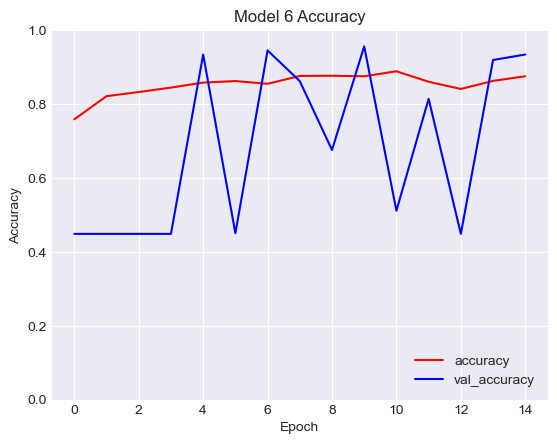

In [ ]:
# Display a graph of accuracy for the training and validation sets by epoch
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])

# add title and labels
plt.title('Model 6 Accuracy')
# change the line colors
plt.gca().get_lines()[0].set_color('red')
plt.gca().get_lines()[1].set_color('blue')
plt.legend(loc='lower right')
plt.show()


In [ ]:
# find the index of the best val_accuracy in the history
best_val_accuracy = max(history.history['val_accuracy'])
best_val_accuracy_index = history.history['val_accuracy'].index(best_val_accuracy)
# get the training accuracy at the best val_accuracy
best_train_accuracy = history.history['accuracy'][best_val_accuracy_index]
print(f'  Best Training Accuracy: {best_train_accuracy}')
print(f'Best Validation Accuracy: {best_val_accuracy}')


  Best Training Accuracy: 0.874768078327179
Best Validation Accuracy: 0.955719530582428


In [ ]:
# calculate the validation accuracy
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f'Validation Accuracy: {val_accuracy}')

34/34 [==============================] - 11s 335ms/step - loss: 0.1394 - accuracy: 0.9557
Validation Accuracy: 0.955719530582428


  Training Accuracy: 0.874768078327179
Validation Accuracy: 0.9335793256759644
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       243
           1       1.00      0.92      0.96       299

    accuracy                           0.96       542
   macro avg       0.96      0.96      0.96       542
weighted avg       0.96      0.96      0.96       542



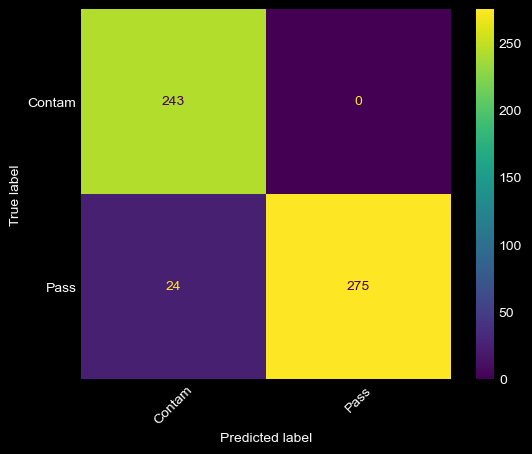

In [ ]:
# create a confustion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict the classes of the training images
train_pred = model.predict(train_generator)
# Get the predicted classes
train_pred_classes = (train_pred > 0.5).astype(int)
# Predict the classes of the images
val_pred = model.predict(validation_generator)

# Get the true validation classes
true_classes = validation_generator.classes
# print the training accuracy
print('='*50)
print(f'  Training Accuracy: {history.history["accuracy"][-1]:.3f}')
# print the validation accuracy
print(f'Validation Accuracy: {history.history["val_accuracy"][-1]:.3f}')
print('='*50)
# Generate a classification report
report = classification_report(true_classes, predicted_classes)
print(report)
# Calculate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Contam', 'Pass'])
disp.plot()
plt.xticks(rotation=45)
plt.grid(False)
plt.show()

In [ ]:
# Display the model results sorted by validation accuracy
model_results_df.sort_values(by='Val Accuracy', ascending=False)

--> ANALYSIS Model 6 <---
- Much improved result!  This is an MVP.  Zero false positives for PASS class which is what we are wanting
- Still concerned about the jerkiness of the validation set from epoch to epoch

---
### Model 7
Changes:
- Adding a test set

In [ ]:
# change the data directory since we are doing binary classification
data_dir = 'data/raw/images_sorted_binary/Train_val'
# check the image counts
get_folder_counts(data_dir)

Class: Contamination - 1033 files
Class: PASS - 1275 files


In [ ]:
# change the data directory since we are doing binary classification
data_dir = 'data/raw/images_sorted_binary/Test'
# check the image counts
get_folder_counts(data_dir)

Class: Contamination - 182 files
Class: PASS - 224 files


In [ ]:
num_epochs = 100
original_width = 1024
original_height = 943
scale_factor = 1
target_size = (int(original_height*scale_factor), int(original_width*scale_factor))

# Create an ImageDataGenerator for the training set with augmentations
train_datagen = ImageDataGenerator(rescale=1./65535, 
                                   validation_split=0.15,
                                   horizontal_flip=True,
                                   zoom_range=0.05,
                                   height_shift_range=0.05)

# Create an ImageDataGenerator for the validation set without augmentations
val_datagen = ImageDataGenerator(rescale=1./65535, 
                                 validation_split=0.15)

# create the test generator
test_datagen = ImageDataGenerator(rescale=1./65535)

# the train images directory
train_dir = 'data/raw/images_sorted_binary/Train_val'
# the test images directory
test_dir = 'data/raw/images_sorted_binary/Test'

# create the train generator
train_generator = train_datagen.flow_from_directory(
        train_dir, 
        target_size= target_size,
        batch_size=16, 
        shuffle=True,
        color_mode='grayscale',
        subset='training',
        class_mode='binary',
        seed=42
)

# create the validation generator
validation_generator = val_datagen.flow_from_directory(
        train_dir, 
        target_size= target_size,
        batch_size=16, 
        shuffle=False,
        color_mode='grayscale',
        subset='validation',
        class_mode='binary',
        seed=42
)

# create the test generator
test_generator = test_datagen.flow_from_directory(
        test_dir, 
        target_size=target_size,
        batch_size=16, 
        shuffle=False,
        color_mode='grayscale',
        class_mode='binary',
        seed=42
)


input_shape = (target_size[0], target_size[1], 1)
# Define a simple model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='valid'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='valid'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# instantiate early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)

#from tensorflow.keras.callbacks import ModelCheckpoint

# # Define the ModelCheckpoint callback
# checkpoint = ModelCheckpoint(
#     filepath='Models\model7_epoch_{epoch:02d}.h5',  # Save the model with the epoch number in the filename
#     save_weights_only=True,  # Save the full model (architecture + weights)
#     save_freq='epoch'  # Save the model at the end of each epoch
# )


# Calculate steps per epoch
steps_per_epoch = train_generator.samples // train_generator.batch_size


history = model.fit(train_generator, 
                steps_per_epoch=steps_per_epoch, 
                epochs=num_epochs,
                validation_data=validation_generator,
                callbacks=[early_stopping])

# Pickle the best model
joblib.dump(model, 'Models\\model_7.pkl')

Found 1963 images belonging to 2 classes.
Found 345 images belonging to 2 classes.
Found 406 images belonging to 2 classes.
Epoch 1/100
122/122 [==============================] - 1526s 12s/step - loss: 0.5290 - accuracy: 0.7560 - val_loss: 1.9777 - val_accuracy: 0.4464
Epoch 2/100
122/122 [==============================] - 1473s 12s/step - loss: 0.4661 - accuracy: 0.7879 - val_loss: 2.2486 - val_accuracy: 0.4464
Epoch 3/100
122/122 [==============================] - 1441s 12s/step - loss: 0.4219 - accuracy: 0.8079 - val_loss: 2.2633 - val_accuracy: 0.4464
Epoch 4/100
122/122 [==============================] - 1432s 12s/step - loss: 0.4058 - accuracy: 0.8264 - val_loss: 0.7804 - val_accuracy: 0.5217
Epoch 5/100
122/122 [==============================] - 1501s 12s/step - loss: 0.3750 - accuracy: 0.8480 - val_loss: 0.6624 - val_accuracy: 0.7420
Epoch 6/100
122/122 [==============================] - 1467s 12s/step - loss: 0.4127 - accuracy: 0.8269 - val_loss: 1.4927 - val_accuracy: 0.4522


['Models\\model_7.pkl']

In [ ]:
# get the results of the test set
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

22/22 [==============================] - 56s 3s/step - loss: 0.0830 - accuracy: 0.9768
Validation Loss: 0.08298756927251816
Validation Accuracy: 0.9768115878105164


In [ ]:
# get the results of the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

26/26 [==============================] - 62s 2s/step - loss: 0.2656 - accuracy: 0.8941
Test Loss: 0.2655832767486572
Test Accuracy: 0.8940886855125427


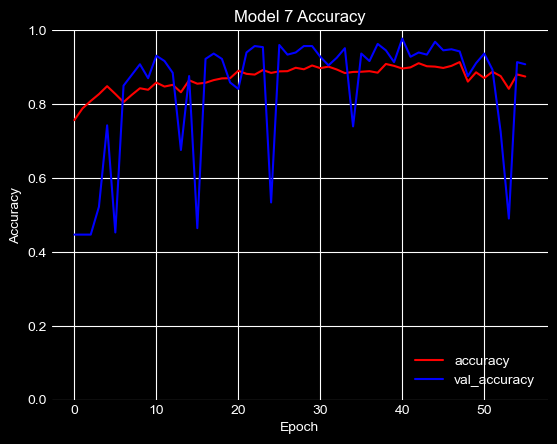

In [ ]:
# Display a graph of accuracy for the training and validation sets by epoch
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])

# add title and labels
plt.title('Model 7 Accuracy')
# change the line colors
plt.gca().get_lines()[0].set_color('red')
plt.gca().get_lines()[1].set_color('blue')
plt.legend(loc='lower right')
plt.show()


  Training Accuracy: 0.896
Validation Accuracy: 0.977
      Test Accuracy: 0.894
              precision    recall  f1-score   support

           0       0.99      0.77      0.87       182
           1       0.84      1.00      0.91       224

    accuracy                           0.89       406
   macro avg       0.92      0.88      0.89       406
weighted avg       0.91      0.89      0.89       406



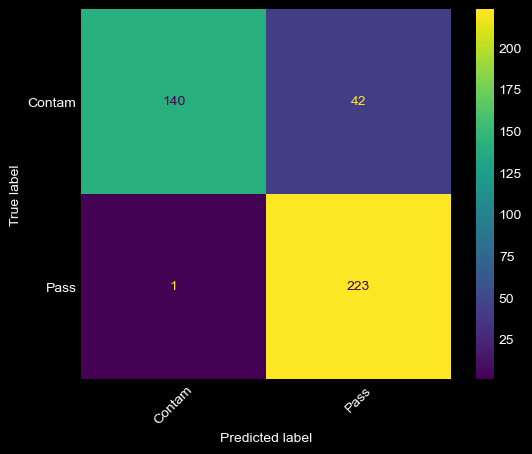

In [ ]:
# create a confustion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict the classes of the test images
test_pred = model.predict(test_generator)
# Get the predicted classes
test_pred_classes = (test_pred > 0.5).astype(int)

# find the index of the best val_accuracy in the history
best_val_accuracy = max(history.history['val_accuracy'])
best_val_accuracy_index = history.history['val_accuracy'].index(best_val_accuracy)
# get the training accuracy at the best val_accuracy
best_train_accuracy = history.history['accuracy'][best_val_accuracy_index]
# print the training accuracy
print('='*50)
print(f'  Training Accuracy: {best_train_accuracy:.3f}')
# print the validation accuracy
print(f'Validation Accuracy: {best_val_accuracy:.3f}')
# print the test accuracy
test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
print(f'      Test Accuracy: {test_accuracy:.3f}')
print('='*50)


# Get the true test classes
true_classes = test_generator.classes
# Generate a classification report
report = classification_report(true_classes, test_pred_classes)
print(report)
# Calculate the confusion matrix
cm = confusion_matrix(true_classes, test_pred_classes)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Contam', 'Pass'])
# dark background
plt.style.use('dark_background')
disp.plot()
plt.xticks(rotation=45)
plt.grid(False)
plt.show()


In [ ]:
# Create a ROC Curve
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc

# Predict the classes of the test images
y_test_prob = model.predict(test_generator)
# Get the true test classes
y_test_true = test_generator.classes

# Predict the classes of the training images
y_val_prob = model.predict(validation_generator)
# Get the predicted classes
y_val_true = validation_generator.classes

# Create the ROC curve plot for both the training and test data
fpr_test, tpr_test, _ = roc_curve(y_test_true, y_test_prob)
fpr_val, tpr_val, _ = roc_curve(y_val_true, y_val_prob)
plt.figure(figsize=(6, 5.5))
plt.plot(fpr_test, tpr_test, label='Test Data')
plt.plot(fpr_val, tpr_val, label='Train Data')
plt.plot([0, 1], [0, 1], 'k--', color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve')
plt.legend()
plt.show()

In [ ]:
# Display the model results sorted by validation accuracy
model_results_df.sort_values(by='Val Accuracy', ascending=False)

--> ANALYSIS Model 7 <---
- We introduced a completely unseen test set in this model. Overall the performance improvement, if any, was dubious given it took 22hr to run the model on the full size images.  Reducing the image size doesn't seem to have that great of an effect on performance vs how much extra time it takes to run the model.
- Should be getting better results.  Going to try adding more convolution layers.

---
### Model 8
Changes:
- Created a different folder for train, val, test splits
- Adding 2 additionaly convolution layers
- Increased the number of nodes in the first two dense layers
- Changed from flatten() after the convolutions to GlobalAveragePooling2D() to help generalization
- Added class weights

In [ ]:
model_name = 'Model_8'
num_epochs = 100
original_width = 1024
original_height = 943
scale_factor = 0.5
target_size = (int(original_height*scale_factor), int(original_width*scale_factor))

# Instantiate an ImageDataGenerator for the training set with augmentations
train_datagen = ImageDataGenerator(rescale=1./65535, 
                                   horizontal_flip=True,
                                   zoom_range=0.05,
                                   height_shift_range=0.05)

# Instantiate an ImageDataGenerator for the validation set without augmentations
val_datagen = ImageDataGenerator(rescale=1./65535)

# Instantiate the test generator
test_datagen = ImageDataGenerator(rescale=1./65535)

# create the train generator
train_generator = train_datagen.flow_from_directory(
        train_dir, 
        target_size= target_size,
        batch_size=16, 
        shuffle=True,
        color_mode='grayscale',
        class_mode='binary',
        seed=42
)

# create the validation generator
validation_generator = val_datagen.flow_from_directory(
        val_dir, 
        target_size= target_size,
        batch_size=16, 
        shuffle=False,
        color_mode='grayscale',
        class_mode='binary',
        seed=42
)

# create the test generator
test_generator = test_datagen.flow_from_directory(
        test_dir, 
        target_size=target_size,
        batch_size=16, 
        shuffle=False,
        color_mode='grayscale',
        class_mode='binary',
        seed=42
)

# import global_average_pooling2d
from tensorflow.keras.layers import GlobalAveragePooling2D

# Get the input shape
input_shape = (target_size[0], target_size[1], 1)

# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='valid'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='valid'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='valid'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
#     Conv2D(256, (3, 3), activation='relu', padding='valid'),
#     BatchNormalization(),
#     MaxPooling2D((2, 2)),
#     Flatten(),
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# instantiate early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)


# Calculate steps per epoch
steps_per_epoch = train_generator.samples // train_generator.batch_size

# Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced', 
                                                  classes=np.unique(train_generator.classes), 
                                                  y=train_generator.classes)
class_weight_dict = {i : class_weights[i] for i in range(len(class_weights))}

# fit the model
history = model.fit(train_generator, 
                steps_per_epoch=steps_per_epoch, 
                epochs=num_epochs,
                validation_data=validation_generator,
                class_weight=class_weight_dict,
                callbacks=[early_stopping])

# Pickle the model
pkl_path = f'Models\\{model_name}.pkl'
joblib.dump(model, pkl_path)

  Training Accuracy: 0.818
Validation Accuracy: 0.830
      Test Accuracy: 0.828
              precision    recall  f1-score   support

           0       0.87      0.72      0.79       182
           1       0.80      0.92      0.85       224

    accuracy                           0.83       406
   macro avg       0.84      0.82      0.82       406
weighted avg       0.83      0.83      0.83       406



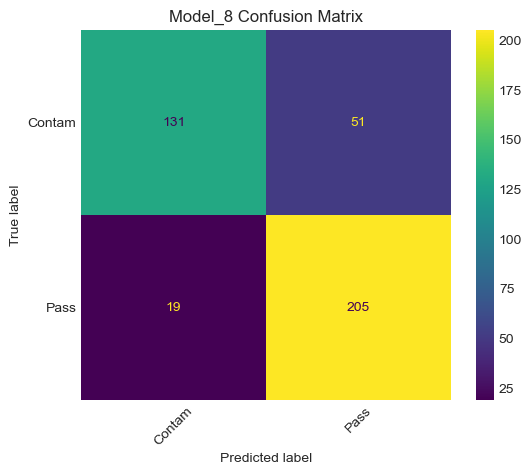

Found 1902 images belonging to 2 classes.


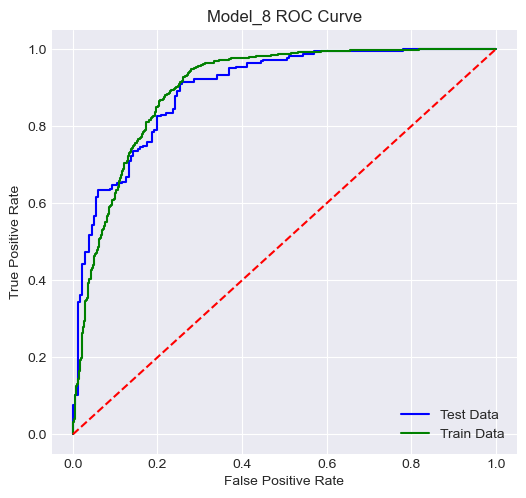

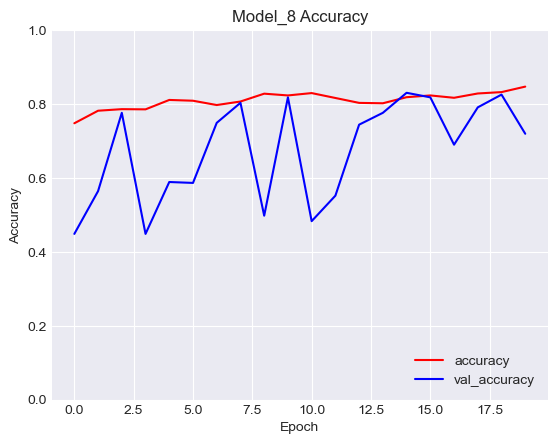

In [ ]:
report_binary_results(model, history, test_generator)

In [ ]:
model_results_df

Model  Scale Factor  Train Accuracy  Val Accuracy  Test Accuracy
0  Model_8           0.5        0.818134      0.830049       0.827586

--> ANALYSIS Model 8 <---
- Not better.
- I varied too many factors in this iteration, will avoid that in the future.
- Suspicious of the GlobalMaxPooling and possible the class weights

---
---
## Second Model Attempts (Google Colab)
- Switched to running models on Google Colab for quicker data turns
- Spent the time to re-label classes 'Damage' and 'Split'
- Up until model 14, there was strange training behavior as can be seen below where every other epoch would only take a few seconds to run and then give strange results.  At first I thought this had to do with the way Colab processed, but later discovered that the models would run normally if I removed the steps_per_epoch parameter from the model.fit().

---
### Model Multi 0
Changes:
- Starting with best binary model (4 Conv, 2 Dense)

In [ ]:
model_name = 'Model_Multi_0'
num_epochs = 100
original_width = 1024
original_height = 943
scale_factor = 0.35
target_size = (int(original_height*scale_factor), int(original_width*scale_factor))

# Instantiate an ImageDataGenerator for the training set with augmentations
train_datagen = ImageDataGenerator(rescale=1./65535,
                                   horizontal_flip=True,
                                   zoom_range=0.05,
                                   height_shift_range=0.05)

# Instantiate an ImageDataGenerator for the validation set without augmentations
val_datagen = ImageDataGenerator(rescale=1./65535)

# Instantiate the test generator
test_datagen = ImageDataGenerator(rescale=1./65535)

# create the train generator
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size= target_size,
        batch_size=16,
        shuffle=True,
        color_mode='grayscale',
        class_mode='categorical',
        seed=42
)

# create the validation generator
validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size= target_size,
        batch_size=16,
        shuffle=False,
        color_mode='grayscale',
        class_mode='categorical',
        seed=42
)

# create the test generator
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=16,
        shuffle=False,
        color_mode='grayscale',
        class_mode='categorical',
        seed=42
)


# Get the input shape
input_shape = (target_size[0], target_size[1], 1)

# Define the model
model = Sequential([
    Conv2D(32, (3, 3),
           activation='relu',
           input_shape=input_shape,
           padding='valid'),

    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='valid'),

    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='valid'),

    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu', padding='valid'),

    MaxPooling2D((2, 2)),
    Flatten(),

    Dense(512, activation='relu'),

    Dense(512, activation='relu'),

    Dense(4, activation='softmax')
])

from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# instantiate early stopping
early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=5, restore_best_weights=True)

# NOTE: I later discovered that steps_per_epoch was causing issues in Colab, 
#       causing the training to skip every other epoch. I removed it and the
#       training worked as expected.  I came back and retrained this model at
#       the end of the project and it worked as expected with better results.

# Calculate steps per epoch
# steps_per_epoch = train_generator.samples // train_generator.batch_size

# Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(train_generator.classes),
                                                  y=train_generator.classes)
class_weight_dict = {i : class_weights[i] for i in range(len(class_weights))}

# fit the model
history = model.fit(train_generator,
                # steps_per_epoch=steps_per_epoch,
                epochs=num_epochs,
                validation_data=validation_generator,
                class_weight=class_weight_dict,
                callbacks=[early_stopping])


Found 3989 images belonging to 4 classes.
Found 851 images belonging to 4 classes.
Found 851 images belonging to 4 classes.
Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 95s 352ms/step - categorical_accuracy: 0.2961 - loss: 1.3828 - val_categorical_accuracy: 0.2785 - val_loss: 1.3876
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 80s 313ms/step - categorical_accuracy: 0.4947 - loss: 1.1476 - val_categorical_accuracy: 0.5840 - val_loss: 1.1337
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 80s 312ms/step - categorical_accuracy: 0.6840 - loss: 0.8988 - val_categorical_accuracy: 0.7850 - val_loss: 0.6354
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 81s 315ms/step - categorical_accuracy: 0.7428 - loss: 0.7607 - val_categorical_accuracy: 0.7509 - val_loss: 0.7937
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 80s 312ms/step - categorical_accuracy: 0.7905 - loss: 0.6585 - val_categorical_accuracy: 0.8179 - val_loss: 0.5360
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 80s 313ms/step - categorical_accuracy: 0.8111 - loss: 0

54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 185ms/step
  Training Accuracy: 0.922
Validation Accuracy: 0.892
      Test Accuracy: 0.873
 FPR for PASS class: 0.0371
              precision    recall  f1-score   support

           0       0.89      0.79      0.84       209
           1       0.58      0.67      0.62        89
           2       0.95      0.97      0.96       376
           3       0.86      0.88      0.87       177

    accuracy                           0.87       851
   macro avg       0.82      0.83      0.82       851
weighted avg       0.88      0.87      0.87       851



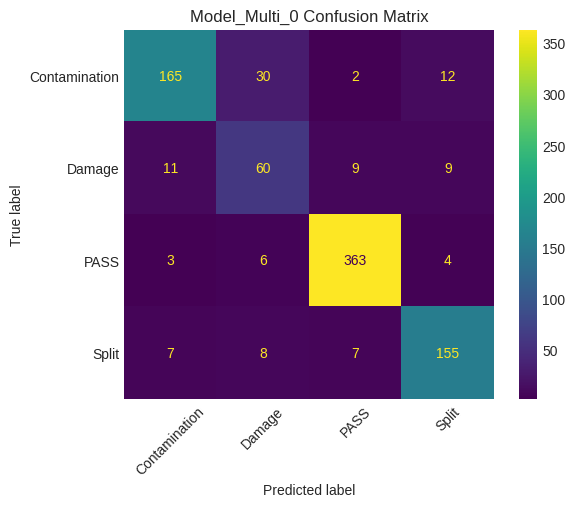

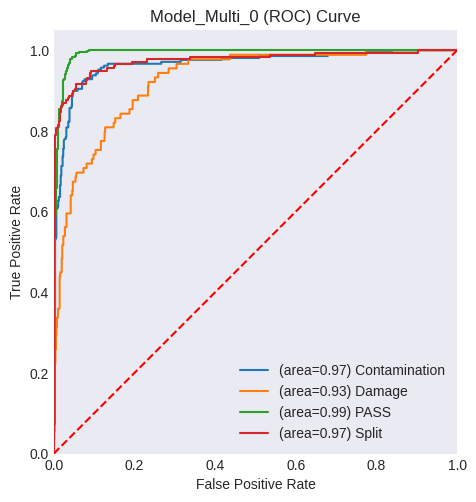

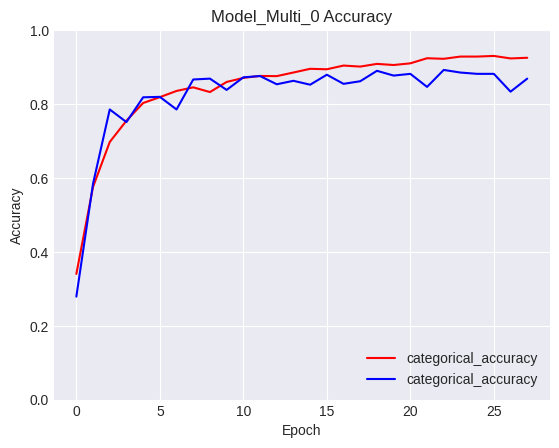

In [ ]:
report_multi_results(model_name, scale_factor, model, history, test_generator)

In [ ]:
# save the model_results_df
model_results_df.to_csv('/content/drive/MyDrive/Colab Notebooks/multi_results.csv', index=False)

### ANALYSIS:
- Much better multiclass result, using similar architecture as earlier trials
- Cleaning up the data labels made all the difference
- Still some crossover in Damage and Contamination, as many of those images contain both features

---
### Model Multi 1
Changes:
- Adding Batch Normalization (4 Conv, 2 Dense)

In [ ]:
model_name = 'Model_Multi_1'
num_epochs = 100
original_width = 1024
original_height = 943
scale_factor = 0.35
target_size = (int(original_height*scale_factor), int(original_width*scale_factor))

# Instantiate an ImageDataGenerator for the training set with augmentations
train_datagen = ImageDataGenerator(rescale=1./65535,
                                   horizontal_flip=True,
                                   zoom_range=0.05,
                                   height_shift_range=0.05)

# Instantiate an ImageDataGenerator for the validation set without augmentations
val_datagen = ImageDataGenerator(rescale=1./65535)

# Instantiate the test generator
test_datagen = ImageDataGenerator(rescale=1./65535)

# create the train generator
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size= target_size,
        batch_size=16,
        shuffle=True,
        color_mode='grayscale',
        class_mode='categorical',
        seed=42
)

# create the validation generator
validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size= target_size,
        batch_size=16,
        shuffle=False,
        color_mode='grayscale',
        class_mode='categorical',
        seed=42
)

# create the test generator
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=16,
        shuffle=False,
        color_mode='grayscale',
        class_mode='categorical',
        seed=42
)


# Get the input shape
input_shape = (target_size[0], target_size[1], 1)

# Define the model
model = Sequential([
    Conv2D(32, (3, 3),
           activation='relu',
           input_shape=input_shape,
           padding='valid'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='valid'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='valid'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu', padding='valid'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),

    Dense(512, activation='relu'),
    BatchNormalization(),

    Dense(512, activation='relu'),
    BatchNormalization(),

    Dense(4, activation='softmax')
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# instantiate early stopping
early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=5, restore_best_weights=True)


# Calculate steps per epoch
steps_per_epoch = train_generator.samples // train_generator.batch_size

# Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(train_generator.classes),
                                                  y=train_generator.classes)
class_weight_dict = {i : class_weights[i] for i in range(len(class_weights))}

# fit the model
history = model.fit(train_generator,
                steps_per_epoch=steps_per_epoch,
                epochs=num_epochs,
                validation_data=validation_generator,
                class_weight=class_weight_dict,
                callbacks=[early_stopping])


Found 3281 images belonging to 4 classes.
Found 699 images belonging to 4 classes.
Found 699 images belonging to 4 classes.
Epoch 1/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 84s 355ms/step - categorical_accuracy: 0.4702 - loss: 1.4472 - val_categorical_accuracy: 0.2990 - val_loss: 2.5600
Epoch 2/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - categorical_accuracy: 0.5000 - loss: 0.9018 - val_categorical_accuracy: 0.2990 - val_loss: 2.5674
Epoch 3/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 70s 329ms/step - categorical_accuracy: 0.5685 - loss: 1.0949 - val_categorical_accuracy: 0.2833 - val_loss: 1.7274
Epoch 4/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - categorical_accuracy: 0.5000 - loss: 1.3384 - val_categorical_accuracy: 0.2804 - val_loss: 1.6743
Epoch 5/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 70s 329ms/step - categorical_accuracy: 0.5793 - loss: 1.0746 - val_categorical_accuracy: 0.5837 - val_loss: 1.0095
Epoch 6/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - categorical_accuracy: 0.3750 - loss: 1.1444 

44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 183ms/step
  Training Accuracy: 0.589
Validation Accuracy: 0.584
      Test Accuracy: 0.565
              precision    recall  f1-score   support

           0       0.86      0.43      0.57       209
           1       0.25      0.75      0.38        89
           2       0.81      0.55      0.65       224
           3       0.66      0.66      0.66       177

    accuracy                           0.57       699
   macro avg       0.64      0.60      0.56       699
weighted avg       0.72      0.57      0.59       699



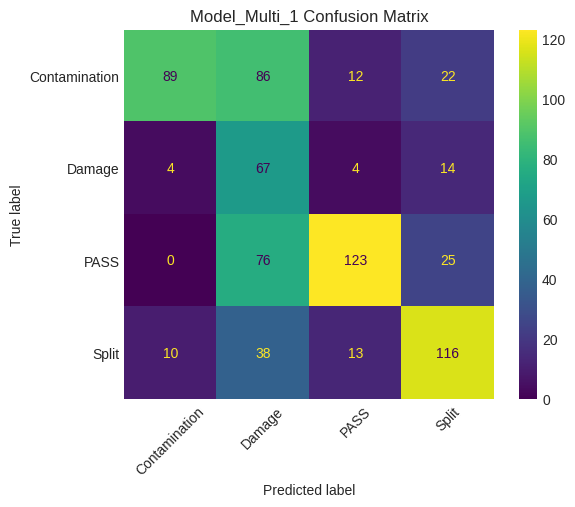

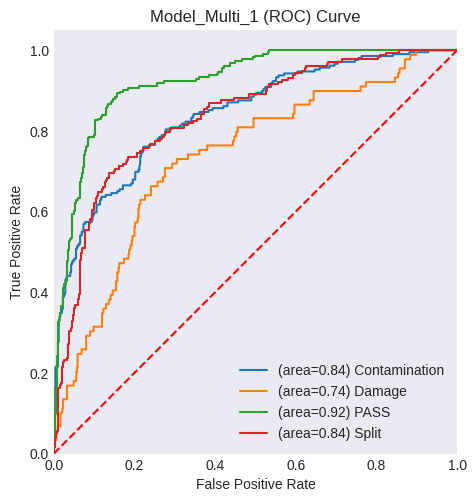

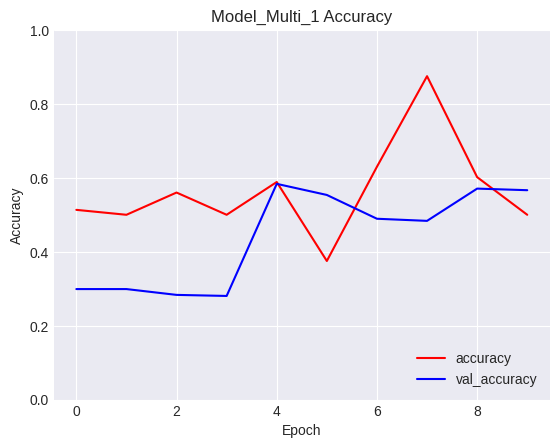

In [ ]:
report_multi_results(model_name, scale_factor, model, history, test_generator)

In [ ]:
model_results_df

Model  Scale Factor  Train Accuracy  Val Accuracy  Test Accuracy
0  Model_Multi_0          0.35        1.000000      0.845494       0.844063
1  Model_Multi_1          0.35        0.588668      0.583691       0.565093

In [ ]:
# save the model_results_df
model_results_df.to_csv('/content/drive/MyDrive/Colab Notebooks/multi_results.csv', index=False)

### ANALYSIS:
- Wow, that did not work well. Not sure why but maybe will put batch norm in the dense layers on the back burner for now
- (After the fact, I suspect this strange behavior had something to do with the Colab steps_per_epoch problem, but I never got around to re-running this model)


---
### Model Multi 2
Changes:
- Removing Batch Normalization from Dense layers (4 Conv, 2 Dense)

In [ ]:
model_name = 'Model_Multi_2'
num_epochs = 100
original_width = 1024
original_height = 943
scale_factor = 0.35
target_size = (int(original_height*scale_factor), int(original_width*scale_factor))

# Instantiate an ImageDataGenerator for the training set with augmentations
train_datagen = ImageDataGenerator(rescale=1./65535,
                                   horizontal_flip=True,
                                   zoom_range=0.05,
                                   height_shift_range=0.05)

# Instantiate an ImageDataGenerator for the validation set without augmentations
val_datagen = ImageDataGenerator(rescale=1./65535)

# Instantiate the test generator
test_datagen = ImageDataGenerator(rescale=1./65535)

# create the train generator
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size= target_size,
        batch_size=16,
        shuffle=True,
        color_mode='grayscale',
        class_mode='categorical',
        seed=42
)

# create the validation generator
validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size= target_size,
        batch_size=16,
        shuffle=False,
        color_mode='grayscale',
        class_mode='categorical',
        seed=42
)

# create the test generator
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=16,
        shuffle=False,
        color_mode='grayscale',
        class_mode='categorical',
        seed=42
)


# Get the input shape
input_shape = (target_size[0], target_size[1], 1)

# Define the model
model = Sequential([
    Conv2D(32, (3, 3),
           activation='relu',
           input_shape=input_shape,
           padding='valid'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='valid'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='valid'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu', padding='valid'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),

    Dense(512, activation='relu'),

    Dense(512, activation='relu'),

    Dense(4, activation='softmax')
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# instantiate early stopping
early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=5, restore_best_weights=True)


# Calculate steps per epoch
steps_per_epoch = train_generator.samples // train_generator.batch_size

# Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(train_generator.classes),
                                                  y=train_generator.classes)
class_weight_dict = {i : class_weights[i] for i in range(len(class_weights))}

# fit the model
history = model.fit(train_generator,
                steps_per_epoch=steps_per_epoch,
                epochs=num_epochs,
                validation_data=validation_generator,
                class_weight=class_weight_dict,
                callbacks=[early_stopping])


Found 3281 images belonging to 4 classes.
Found 699 images belonging to 4 classes.
Found 699 images belonging to 4 classes.
Epoch 1/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 80s 342ms/step - categorical_accuracy: 0.3997 - loss: 14.2524 - val_categorical_accuracy: 0.2990 - val_loss: 7.7845
Epoch 2/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - categorical_accuracy: 0.6250 - loss: 1.3591 - val_categorical_accuracy: 0.2990 - val_loss: 8.1066
Epoch 3/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 67s 319ms/step - categorical_accuracy: 0.4523 - loss: 1.4665 - val_categorical_accuracy: 0.3076 - val_loss: 1.6870
Epoch 4/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - categorical_accuracy: 0.3125 - loss: 1.5823 - val_categorical_accuracy: 0.2861 - val_loss: 2.2118
Epoch 5/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 66s 314ms/step - categorical_accuracy: 0.3896 - loss: 1.4187 - val_categorical_accuracy: 0.3562 - val_loss: 1.8923
Epoch 6/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - categorical_accuracy: 0.2500 - loss: 1.7062

In [ ]:
model_path = f'/content/drive/MyDrive/LMIS_Classification/Models{model_name}_binary.pkl'
joblib.dump(model, model_path)

['/content/drive/MyDrive/LMIS_Classification/ModelsModel_Multi_0_binary.pkl']

44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 192ms/step
  Training Accuracy: 0.415
Validation Accuracy: 0.536
      Test Accuracy: 0.518
              precision    recall  f1-score   support

           0       0.58      0.69      0.63       209
           1       0.26      0.06      0.09        89
           2       0.51      0.84      0.63       224
           3       0.43      0.14      0.21       177

    accuracy                           0.52       699
   macro avg       0.44      0.43      0.39       699
weighted avg       0.48      0.52      0.46       699



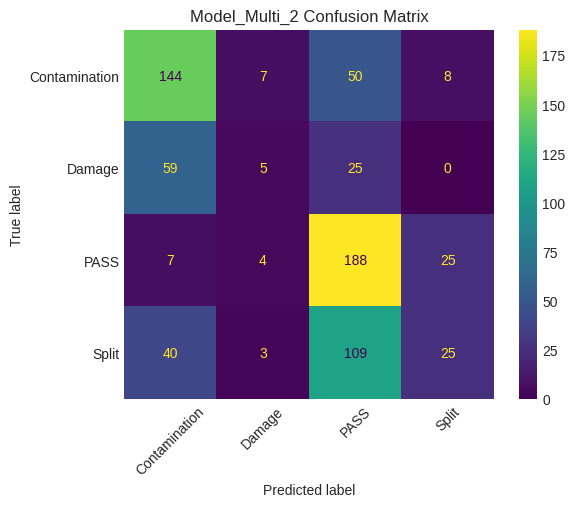

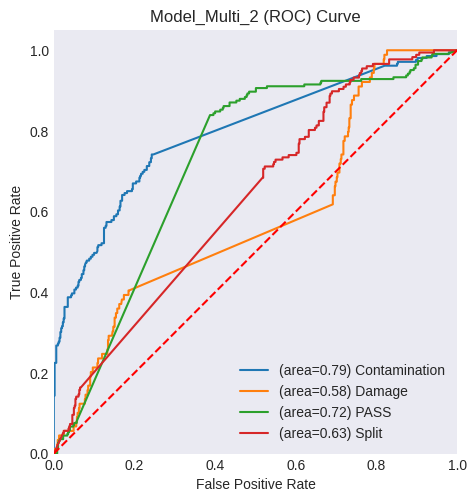

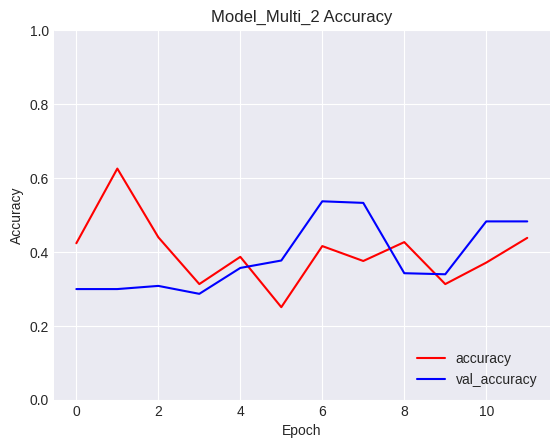

In [ ]:
report_multi_results(model_name, scale_factor, model, history, test_generator)

In [ ]:
model_results_df

Model  Scale Factor  Train Accuracy  Val Accuracy  Test Accuracy
0  Model_Multi_0          0.35        1.000000      0.845494       0.844063
1  Model_Multi_1          0.35        0.588668      0.583691       0.565093
2  Model_Multi_2          0.35        0.415314      0.536481       0.517883

In [ ]:
# save the model_results_df
model_results_df.to_csv('/content/drive/MyDrive/Colab Notebooks/multi_results.csv', index=False)

### ANALYSIS:
- Even worse. Not sure why but maybe will put batch norm on the back burner for now altogether.
- (After the fact, I suspect this strange behavior had something to do with the Colab steps_per_epoch problem, but I never got around to re-running this model)


---
### Model Multi 3
Changes:
- Removing Batch Normalization completely
- Add another Dense layer and Dropout (4 Conv, 3 Dense)

In [ ]:
model_name = 'Model_Multi_3'
num_epochs = 100
original_width = 1024
original_height = 943
scale_factor = 0.35
target_size = (int(original_height*scale_factor), int(original_width*scale_factor))

# Instantiate an ImageDataGenerator for the training set with augmentations
train_datagen = ImageDataGenerator(rescale=1./65535,
                                   horizontal_flip=True,
                                   zoom_range=0.05,
                                   height_shift_range=0.05)

# Instantiate an ImageDataGenerator for the validation set without augmentations
val_datagen = ImageDataGenerator(rescale=1./65535)

# Instantiate the test generator
test_datagen = ImageDataGenerator(rescale=1./65535)

# create the train generator
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size= target_size,
        batch_size=16,
        shuffle=True,
        color_mode='grayscale',
        class_mode='categorical',
        seed=42
)

# create the validation generator
validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size= target_size,
        batch_size=16,
        shuffle=False,
        color_mode='grayscale',
        class_mode='categorical',
        seed=42
)

# create the test generator
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=16,
        shuffle=False,
        color_mode='grayscale',
        class_mode='categorical',
        seed=42
)


# Get the input shape
input_shape = (target_size[0], target_size[1], 1)

# Define the model
model = Sequential([
    Conv2D(32, (3, 3),
           activation='relu',
           input_shape=input_shape,
           padding='valid'),

    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='valid'),

    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='valid'),

    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu', padding='valid'),

    MaxPooling2D((2, 2)),
    Flatten(),

    Dense(512, activation='relu'),

    Dropout(0.2),
    Dense(512, activation='relu'),

    Dense(256, activation='relu'),
    Dense(4, activation='softmax')
])


optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# instantiate early stopping
early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=5, restore_best_weights=True)


# Calculate steps per epoch
steps_per_epoch = train_generator.samples // train_generator.batch_size

# Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(train_generator.classes),
                                                  y=train_generator.classes)
class_weight_dict = {i : class_weights[i] for i in range(len(class_weights))}

# fit the model
history = model.fit(train_generator,
                steps_per_epoch=steps_per_epoch,
                epochs=num_epochs,
                validation_data=validation_generator,
                class_weight=class_weight_dict,
                callbacks=[early_stopping])


Found 3281 images belonging to 4 classes.
Found 699 images belonging to 4 classes.
Found 699 images belonging to 4 classes.
Epoch 1/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 80s 360ms/step - categorical_accuracy: 0.3767 - loss: 1.3445 - val_categorical_accuracy: 0.5536 - val_loss: 1.9236
Epoch 2/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - categorical_accuracy: 0.8750 - loss: 0.3035 - val_categorical_accuracy: 0.5165 - val_loss: 2.7501
Epoch 3/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 66s 314ms/step - categorical_accuracy: 0.6410 - loss: 0.9744 - val_categorical_accuracy: 0.6338 - val_loss: 0.9349
Epoch 4/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - categorical_accuracy: 0.6875 - loss: 0.8024 - val_categorical_accuracy: 0.7325 - val_loss: 0.7922
Epoch 5/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 66s 314ms/step - categorical_accuracy: 0.7286 - loss: 0.7641 - val_categorical_accuracy: 0.7797 - val_loss: 0.6127
Epoch 6/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - categorical_accuracy: 1.0000 - loss: 0.2740 

In [ ]:
model_path = f'/content/drive/MyDrive/LMIS_Classification/Models{model_name}_binary.pkl'
joblib.dump(model, model_path)

['/content/drive/MyDrive/LMIS_Classification/ModelsModel_Multi_0_binary.pkl']

44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 198ms/step
  Training Accuracy: 0.821
Validation Accuracy: 0.817
      Test Accuracy: 0.813
              precision    recall  f1-score   support

           0       0.88      0.79      0.83       209
           1       0.54      0.58      0.56        89
           2       0.92      0.91      0.91       224
           3       0.76      0.84      0.80       177

    accuracy                           0.81       699
   macro avg       0.78      0.78      0.78       699
weighted avg       0.82      0.81      0.81       699



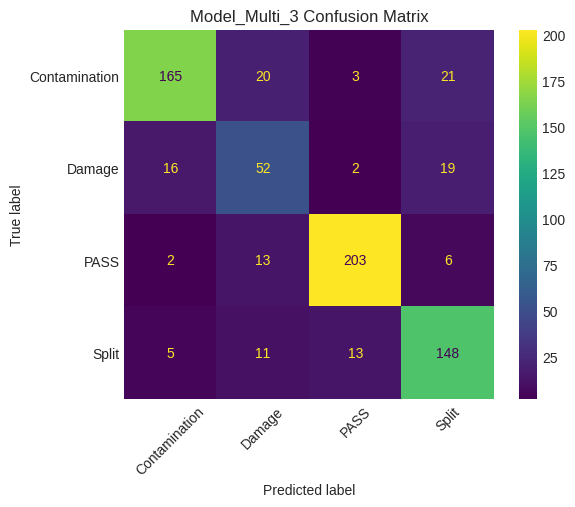

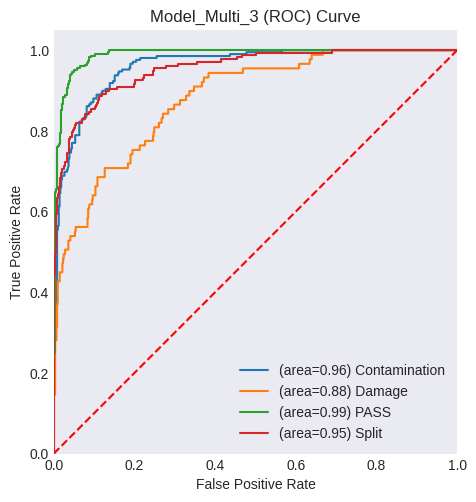

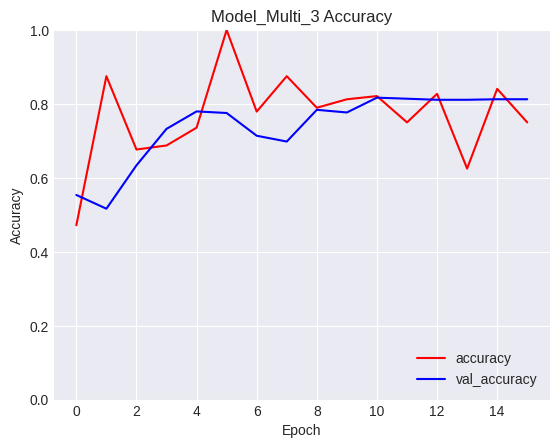

In [ ]:
report_multi_results(model_name, scale_factor, model, history, test_generator)

In [ ]:
model_results_df

Model  Scale Factor  Train Accuracy  Val Accuracy  Test Accuracy
0  Model_Multi_0          0.35        1.000000      0.845494       0.844063
1  Model_Multi_1          0.35        0.588668      0.583691       0.565093
2  Model_Multi_2          0.35        0.415314      0.536481       0.517883
3  Model_Multi_3          0.35        0.821133      0.816881       0.812589

In [ ]:
# save the model_results_df
model_results_df.to_csv('/content/drive/MyDrive/Colab Notebooks/multi_results.csv', index=False)

### ANALYSIS:
- Better without the batch norm altogether, but strange it did not do as well as Model 0.
- (After the fact, I suspect this strange behavior had something to do with the Colab steps_per_epoch problem, but I never got around to re-running this model)


---
### Model Multi 4
Changes:
- Add another Conv layer (5 Conv, 3 Dense)

In [ ]:
model_name = 'Model_Multi_4'
num_epochs = 100
original_width = 1024
original_height = 943
scale_factor = 0.35
target_size = (int(original_height*scale_factor), int(original_width*scale_factor))

# Instantiate an ImageDataGenerator for the training set with augmentations
train_datagen = ImageDataGenerator(rescale=1./65535,
                                   horizontal_flip=True,
                                   zoom_range=0.05,
                                   height_shift_range=0.05)

# Instantiate an ImageDataGenerator for the validation set without augmentations
val_datagen = ImageDataGenerator(rescale=1./65535)

# Instantiate the test generator
test_datagen = ImageDataGenerator(rescale=1./65535)

# create the train generator
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size= target_size,
        batch_size=16,
        shuffle=True,
        color_mode='grayscale',
        class_mode='categorical',
        seed=42
)

# create the validation generator
validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size= target_size,
        batch_size=16,
        shuffle=False,
        color_mode='grayscale',
        class_mode='categorical',
        seed=42
)

# create the test generator
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=16,
        shuffle=False,
        color_mode='grayscale',
        class_mode='categorical',
        seed=42
)


# Get the input shape
input_shape = (target_size[0], target_size[1], 1)

# Define the model
model = Sequential([
    Conv2D(32, (3, 3),
           activation='relu',
           input_shape=input_shape,
           padding='valid'),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='valid'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='valid'),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu', padding='valid'),
    MaxPooling2D((2, 2)),

    Conv2D(512, (3, 3), activation='relu', padding='valid'),
    MaxPooling2D((2, 2)),
    Flatten(),

    Dense(512, activation='relu'),
    Dropout(0.2),

    Dense(512, activation='relu'),

    Dense(256, activation='relu'),
    Dense(4, activation='softmax')
])

from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# instantiate early stopping
early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=5, restore_best_weights=True)


# Calculate steps per epoch
steps_per_epoch = train_generator.samples // train_generator.batch_size

# Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(train_generator.classes),
                                                  y=train_generator.classes)
class_weight_dict = {i : class_weights[i] for i in range(len(class_weights))}

# fit the model
history = model.fit(train_generator,
                steps_per_epoch=steps_per_epoch,
                epochs=num_epochs,
                validation_data=validation_generator,
                class_weight=class_weight_dict,
                callbacks=[early_stopping])


Found 3281 images belonging to 4 classes.
Found 699 images belonging to 4 classes.
Found 699 images belonging to 4 classes.
Epoch 1/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 78s 342ms/step - categorical_accuracy: 0.2595 - loss: 1.4081 - val_categorical_accuracy: 0.3276 - val_loss: 1.3716
Epoch 2/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - categorical_accuracy: 0.1250 - loss: 1.5358 - val_categorical_accuracy: 0.3362 - val_loss: 1.3739
Epoch 3/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 67s 316ms/step - categorical_accuracy: 0.2565 - loss: 1.3958 - val_categorical_accuracy: 0.2604 - val_loss: 1.2881
Epoch 4/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - categorical_accuracy: 0.1875 - loss: 1.1186 - val_categorical_accuracy: 0.2604 - val_loss: 1.2754
Epoch 5/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 67s 315ms/step - categorical_accuracy: 0.2107 - loss: 1.3809 - val_categorical_accuracy: 0.1273 - val_loss: 1.3893
Epoch 6/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - categorical_accuracy: 0.1250 - loss: 1.3183 

In [ ]:
model_path = f'/content/drive/MyDrive/LMIS_Classification/Models{model_name}_binary.pkl'
joblib.dump(model, model_path)

['/content/drive/MyDrive/LMIS_Classification/ModelsModel_Multi_0_binary.pkl']

44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 201ms/step
  Training Accuracy: 0.125
Validation Accuracy: 0.336
      Test Accuracy: 0.329
              precision    recall  f1-score   support

           0       0.39      0.15      0.22       209
           1       0.22      0.73      0.33        89
           2       0.30      0.10      0.15       224
           3       0.46      0.63      0.53       177

    accuracy                           0.33       699
   macro avg       0.34      0.40      0.31       699
weighted avg       0.36      0.33      0.29       699



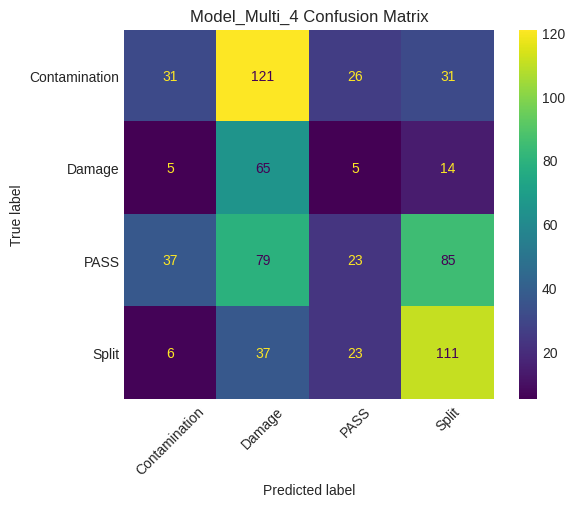

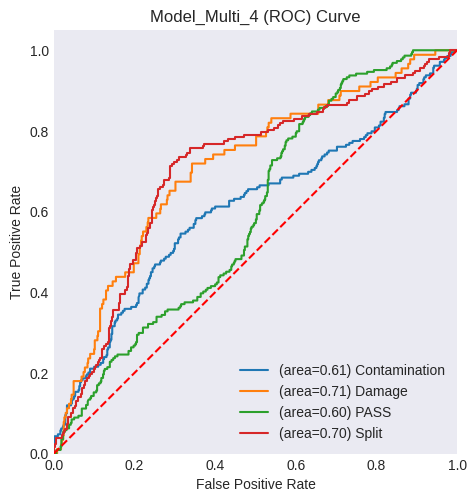

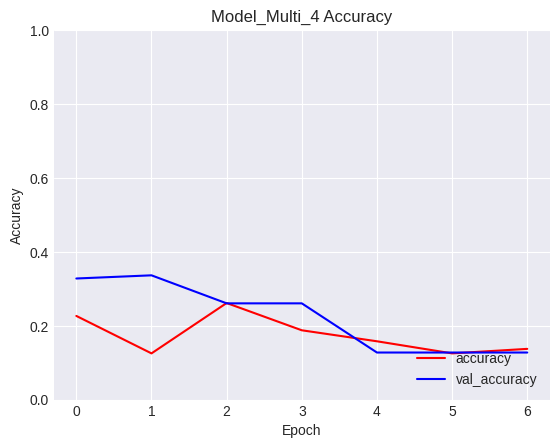

In [ ]:
report_multi_results(model_name, scale_factor, model, history, test_generator)

In [ ]:
model_results_df

Model  Scale Factor  Train Accuracy  Val Accuracy  Test Accuracy
0  Model_Multi_0          0.35        1.000000      0.845494       0.844063
1  Model_Multi_1          0.35        0.588668      0.583691       0.565093
2  Model_Multi_2          0.35        0.415314      0.536481       0.517883
3  Model_Multi_3          0.35        0.821133      0.816881       0.812589
4  Model_Multi_4          0.35        0.125000      0.336195       0.329041

In [ ]:
# save the model_results_df
model_results_df.to_csv('/content/drive/MyDrive/Colab Notebooks/multi_results.csv', index=False)

### ANALYSIS:
- Way worse.  My best guess is that adding another CONV layer is sort of smashing the feature maps tube down so much that data is lost?
- (After the fact, I suspect this strange behavior had something to do with the Colab steps_per_epoch problem, but I never got around to re-running this model)


---
### Model Multi 5
Changes:
- Changed to padding=same (5 Conv, 3 Dense)

In [ ]:
model_name = 'Model_Multi_5'
num_epochs = 100
original_width = 1024
original_height = 943
scale_factor = 0.35
target_size = (int(original_height*scale_factor), int(original_width*scale_factor))

# Instantiate an ImageDataGenerator for the training set with augmentations
train_datagen = ImageDataGenerator(rescale=1./65535,
                                   horizontal_flip=True,
                                   zoom_range=0.05,
                                   height_shift_range=0.05)

# Instantiate an ImageDataGenerator for the validation set without augmentations
val_datagen = ImageDataGenerator(rescale=1./65535)

# Instantiate the test generator
test_datagen = ImageDataGenerator(rescale=1./65535)

# create the train generator
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size= target_size,
        batch_size=16,
        shuffle=True,
        color_mode='grayscale',
        class_mode='categorical',
        seed=42
)

# create the validation generator
validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size= target_size,
        batch_size=16,
        shuffle=False,
        color_mode='grayscale',
        class_mode='categorical',
        seed=42
)

# create the test generator
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=16,
        shuffle=False,
        color_mode='grayscale',
        class_mode='categorical',
        seed=42
)


# Get the input shape
input_shape = (target_size[0], target_size[1], 1)

# Define the model
model = Sequential([
    Conv2D(32, (3, 3),
           activation='relu',
           input_shape=input_shape,
           padding='same'),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    Conv2D(512, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),

    Dense(512, activation='relu'),
    Dropout(0.2),

    Dense(512, activation='relu'),

    Dense(256, activation='relu'),
    Dense(4, activation='softmax')
])

from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# instantiate early stopping
early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=5, restore_best_weights=True)


# Calculate steps per epoch
steps_per_epoch = train_generator.samples // train_generator.batch_size

# Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(train_generator.classes),
                                                  y=train_generator.classes)
class_weight_dict = {i : class_weights[i] for i in range(len(class_weights))}

# fit the model
history = model.fit(train_generator,
                steps_per_epoch=steps_per_epoch,
                epochs=num_epochs,
                validation_data=validation_generator,
                class_weight=class_weight_dict,
                callbacks=[early_stopping])


Found 3281 images belonging to 4 classes.
Found 699 images belonging to 4 classes.
Found 699 images belonging to 4 classes.
Epoch 1/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 83s 351ms/step - categorical_accuracy: 0.2347 - loss: 1.4292 - val_categorical_accuracy: 0.2532 - val_loss: 1.3868
Epoch 2/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - categorical_accuracy: 0.3750 - loss: 1.2966 - val_categorical_accuracy: 0.2532 - val_loss: 1.3868
Epoch 3/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 66s 312ms/step - categorical_accuracy: 0.2420 - loss: 1.3881 - val_categorical_accuracy: 0.2990 - val_loss: 1.3843
Epoch 4/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - categorical_accuracy: 0.1875 - loss: 1.5417 - val_categorical_accuracy: 0.2990 - val_loss: 1.3844
Epoch 5/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 66s 314ms/step - categorical_accuracy: 0.1775 - loss: 1.3867 - val_categorical_accuracy: 0.1273 - val_loss: 1.3866
Epoch 6/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - categorical_accuracy: 0.0625 - loss: 1.2543 

In [ ]:
model_path = f'/content/drive/MyDrive/LMIS_Classification/Models{model_name}_binary.pkl'
joblib.dump(model, model_path)

['/content/drive/MyDrive/LMIS_Classification/ModelsModel_Multi_0_binary.pkl']

44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 199ms/step
  Training Accuracy: 0.263
Validation Accuracy: 0.320
      Test Accuracy: 0.320
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       209
           1       0.00      0.00      0.00        89
           2       0.32      1.00      0.49       224
           3       0.00      0.00      0.00       177

    accuracy                           0.32       699
   macro avg       0.08      0.25      0.12       699
weighted avg       0.10      0.32      0.16       699



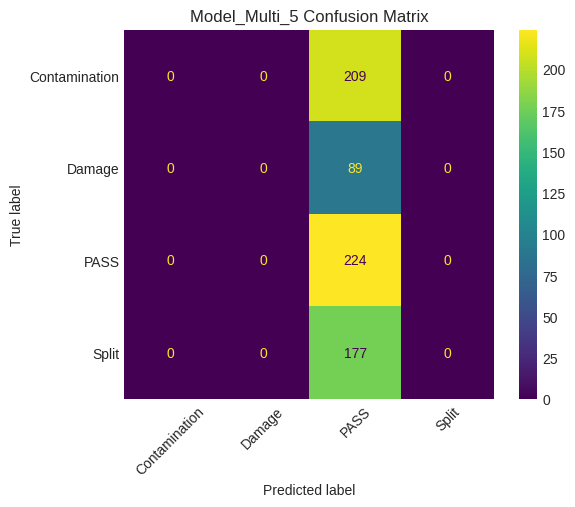

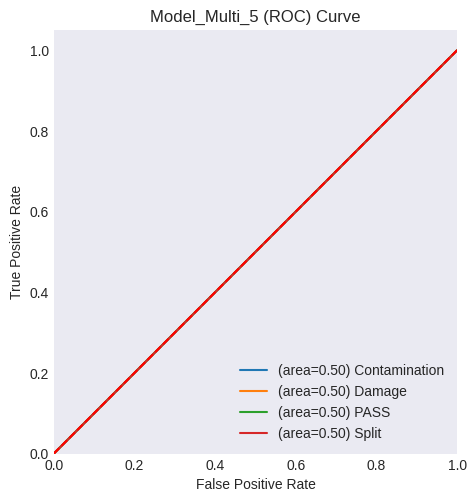

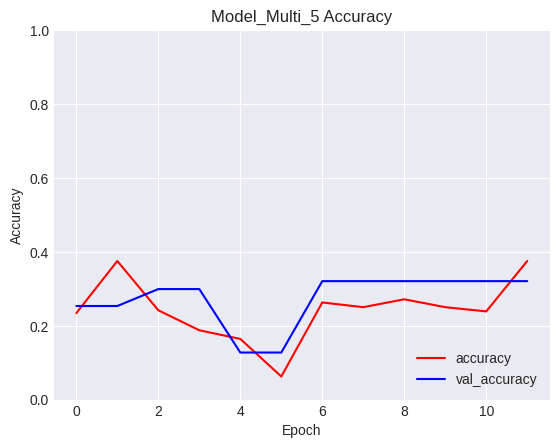

In [ ]:
report_multi_results(model_name, scale_factor, model, history, test_generator)

In [ ]:
model_results_df

Model  Scale Factor  Train Accuracy  Val Accuracy  Test Accuracy
0  Model_Multi_0          0.35        1.000000      0.845494       0.844063
1  Model_Multi_1          0.35        0.588668      0.583691       0.565093
2  Model_Multi_2          0.35        0.415314      0.536481       0.517883
3  Model_Multi_3          0.35        0.821133      0.816881       0.812589
4  Model_Multi_4          0.35        0.125000      0.336195       0.329041
5  Model_Multi_5          0.35        0.262787      0.320458       0.320458

In [ ]:
# save the model_results_df
model_results_df.to_csv('/content/drive/MyDrive/Colab Notebooks/multi_results.csv', index=False)

### ANALYSIS:
- I thought maybe changing to padding='same' might help preserve the dimensionality of the feature maps, but something is still way wrong here.
- (After the fact, I suspect this strange behavior had something to do with the Colab steps_per_epoch problem, but I never got around to re-running this model)


---
### Model Multi 6
Changes:
- Changed to padding=valid
- Removed 2 Conv layer (3 Conv, 3 Dense)

In [ ]:
model_name = 'Model_Multi_6'
num_epochs = 100
original_width = 1024
original_height = 943
scale_factor = 0.35
target_size = (int(original_height*scale_factor), int(original_width*scale_factor))

# Instantiate an ImageDataGenerator for the training set with augmentations
train_datagen = ImageDataGenerator(rescale=1./65535,
                                   horizontal_flip=True,
                                   zoom_range=0.05,
                                   height_shift_range=0.05)

# Instantiate an ImageDataGenerator for the validation set without augmentations
val_datagen = ImageDataGenerator(rescale=1./65535)

# Instantiate the test generator
test_datagen = ImageDataGenerator(rescale=1./65535)

# create the train generator
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size= target_size,
        batch_size=16,
        shuffle=True,
        color_mode='grayscale',
        class_mode='categorical',
        seed=42
)

# create the validation generator
validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size= target_size,
        batch_size=16,
        shuffle=False,
        color_mode='grayscale',
        class_mode='categorical',
        seed=42
)

# create the test generator
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=16,
        shuffle=False,
        color_mode='grayscale',
        class_mode='categorical',
        seed=42
)


# Get the input shape
input_shape = (target_size[0], target_size[1], 1)

# Define the model
model = Sequential([
    Conv2D(32, (3, 3),
           activation='relu',
           input_shape=input_shape,
           padding='valid'),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='valid'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='valid'),
    MaxPooling2D((2, 2)),

    # Conv2D(256, (3, 3), activation='relu', padding='valid'),
    # MaxPooling2D((2, 2)),

    # Conv2D(512, (3, 3), activation='relu', padding='valid'),
    # MaxPooling2D((2, 2)),
    Flatten(),

    Dense(512, activation='relu'),
    Dropout(0.2),

    Dense(512, activation='relu'),

    Dense(256, activation='relu'),
    Dense(4, activation='softmax')
])

from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# instantiate early stopping
early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=5, restore_best_weights=True)


# Calculate steps per epoch
steps_per_epoch = train_generator.samples // train_generator.batch_size

# Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(train_generator.classes),
                                                  y=train_generator.classes)
class_weight_dict = {i : class_weights[i] for i in range(len(class_weights))}

# fit the model
history = model.fit(train_generator,
                steps_per_epoch=steps_per_epoch,
                epochs=num_epochs,
                validation_data=validation_generator,
                class_weight=class_weight_dict,
                callbacks=[early_stopping])


Found 3281 images belonging to 4 classes.
Found 699 images belonging to 4 classes.
Found 699 images belonging to 4 classes.
Epoch 1/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 81s 359ms/step - categorical_accuracy: 0.3716 - loss: 1.6137 - val_categorical_accuracy: 0.5021 - val_loss: 1.2162
Epoch 2/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - categorical_accuracy: 0.2500 - loss: 1.8708 - val_categorical_accuracy: 0.5193 - val_loss: 1.1539
Epoch 3/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 70s 333ms/step - categorical_accuracy: 0.5103 - loss: 1.1398 - val_categorical_accuracy: 0.6266 - val_loss: 1.0274
Epoch 4/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - categorical_accuracy: 0.5000 - loss: 1.0374 - val_categorical_accuracy: 0.6524 - val_loss: 1.0044
Epoch 5/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 71s 335ms/step - categorical_accuracy: 0.6084 - loss: 0.9849 - val_categorical_accuracy: 0.7053 - val_loss: 0.7941
Epoch 6/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - categorical_accuracy: 0.6875 - loss: 0.8165 

In [ ]:
model_path = f'/content/drive/MyDrive/LMIS_Classification/Models{model_name}_binary.pkl'
joblib.dump(model, model_path)

['/content/drive/MyDrive/LMIS_Classification/ModelsModel_Multi_0_binary.pkl']

44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 213ms/step
  Training Accuracy: 0.938
Validation Accuracy: 0.813
      Test Accuracy: 0.803
              precision    recall  f1-score   support

           0       0.78      0.75      0.76       209
           1       0.69      0.51      0.58        89
           2       0.92      0.94      0.93       224
           3       0.73      0.84      0.78       177

    accuracy                           0.80       699
   macro avg       0.78      0.76      0.76       699
weighted avg       0.80      0.80      0.80       699



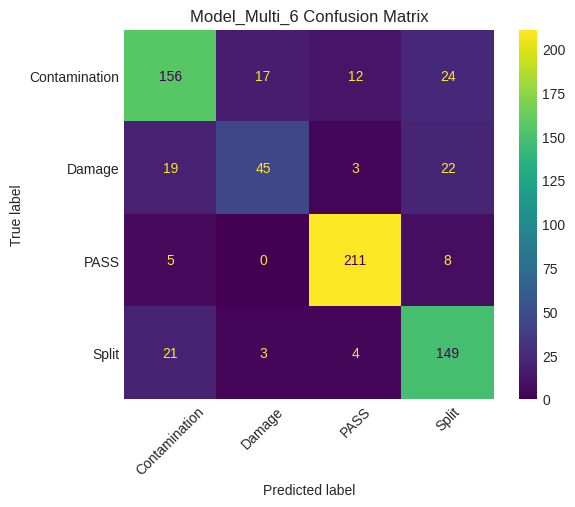

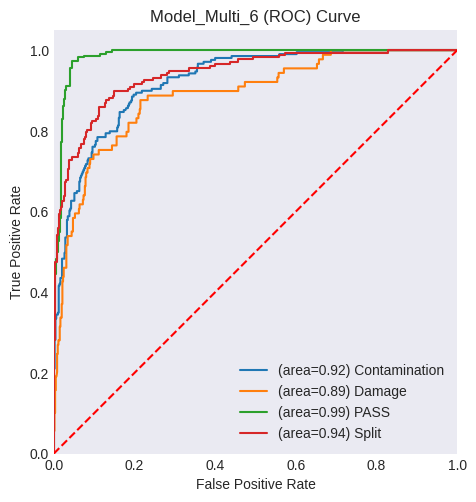

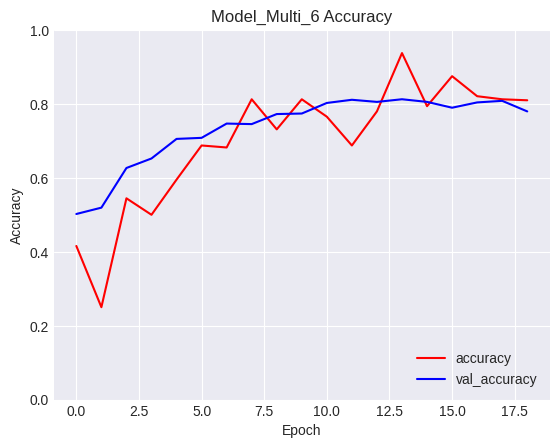

In [ ]:
report_multi_results(model_name, scale_factor, model, history, test_generator)

In [ ]:
model_results_df

Model  Scale Factor  Train Accuracy  Val Accuracy  Test Accuracy
0  Model_Multi_0          0.35        1.000000      0.845494       0.844063
1  Model_Multi_1          0.35        0.588668      0.583691       0.565093
2  Model_Multi_2          0.35        0.415314      0.536481       0.517883
3  Model_Multi_3          0.35        0.821133      0.816881       0.812589
4  Model_Multi_4          0.35        0.125000      0.336195       0.329041
5  Model_Multi_5          0.35        0.262787      0.320458       0.320458
6  Model_Multi_6          0.35        0.937500      0.812589       0.802575

In [ ]:
# save the model_results_df
model_results_df.to_csv('/content/drive/MyDrive/Colab Notebooks/multi_results.csv', index=False)

### ANALYSIS:
- Better again, maybe the extra conv+pooling was causing data loss.  Still not as well as Model 0.
- (After the fact, I suspect this strange behavior had something to do with the Colab steps_per_epoch problem, but I never got around to re-running this model)


---
### Model Multi 7
Changes:
- Added 1 Conv layer (4 Conv, 3 Dense)
- Increase scale_factor=0.55

In [ ]:
model_name = 'Model_Multi_7'
num_epochs = 100
original_width = 1024
original_height = 943
scale_factor = 0.55
target_size = (int(original_height*scale_factor), int(original_width*scale_factor))

# Instantiate an ImageDataGenerator for the training set with augmentations
train_datagen = ImageDataGenerator(rescale=1./65535,
                                   horizontal_flip=True,
                                   zoom_range=0.05,
                                   height_shift_range=0.05)

# Instantiate an ImageDataGenerator for the validation set without augmentations
val_datagen = ImageDataGenerator(rescale=1./65535)

# Instantiate the test generator
test_datagen = ImageDataGenerator(rescale=1./65535)

# create the train generator
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size= target_size,
        batch_size=16,
        shuffle=True,
        color_mode='grayscale',
        class_mode='categorical',
        seed=42
)

# create the validation generator
validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size= target_size,
        batch_size=16,
        shuffle=False,
        color_mode='grayscale',
        class_mode='categorical',
        seed=42
)

# create the test generator
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=16,
        shuffle=False,
        color_mode='grayscale',
        class_mode='categorical',
        seed=42
)


# Get the input shape
input_shape = (target_size[0], target_size[1], 1)

# Define the model
model = Sequential([
    Conv2D(32, (3, 3),
           activation='relu',
           input_shape=input_shape,
           padding='valid'),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='valid'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='valid'),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu', padding='valid'),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(512, activation='relu'),
    Dropout(0.2),

    Dense(512, activation='relu'),

    Dense(256, activation='relu'),
    Dense(4, activation='softmax')
])

from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# instantiate early stopping
early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=5, restore_best_weights=True)


# Calculate steps per epoch
steps_per_epoch = train_generator.samples // train_generator.batch_size

# Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(train_generator.classes),
                                                  y=train_generator.classes)
class_weight_dict = {i : class_weights[i] for i in range(len(class_weights))}

# fit the model
history = model.fit(train_generator,
                steps_per_epoch=steps_per_epoch,
                epochs=num_epochs,
                validation_data=validation_generator,
                class_weight=class_weight_dict,
                callbacks=[early_stopping])


Found 3281 images belonging to 4 classes.
Found 699 images belonging to 4 classes.
Found 699 images belonging to 4 classes.
Epoch 1/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 125s 531ms/step - categorical_accuracy: 0.3383 - loss: 1.5488 - val_categorical_accuracy: 0.5808 - val_loss: 1.0056
Epoch 2/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - categorical_accuracy: 0.6875 - loss: 0.6793 - val_categorical_accuracy: 0.5694 - val_loss: 1.0023
Epoch 3/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 102s 482ms/step - categorical_accuracy: 0.5495 - loss: 1.0963 - val_categorical_accuracy: 0.5894 - val_loss: 0.9957
Epoch 4/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - categorical_accuracy: 0.5625 - loss: 0.7750 - val_categorical_accuracy: 0.5837 - val_loss: 0.9809
Epoch 5/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 101s 479ms/step - categorical_accuracy: 0.6175 - loss: 0.9695 - val_categorical_accuracy: 0.7182 - val_loss: 0.8218
Epoch 6/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - categorical_accuracy: 0.8125 - loss: 0.56

In [ ]:
model_path = f'/content/drive/MyDrive/LMIS_Classification/Models{model_name}_binary.pkl'
joblib.dump(model, model_path)

['/content/drive/MyDrive/LMIS_Classification/ModelsModel_Multi_7_binary.pkl']

44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 225ms/step
  Training Accuracy: 0.829
Validation Accuracy: 0.860
      Test Accuracy: 0.854
              precision    recall  f1-score   support

           0       0.89      0.79      0.84       209
           1       0.56      0.72      0.63        89
           2       0.95      0.98      0.96       224
           3       0.88      0.84      0.86       177

    accuracy                           0.85       699
   macro avg       0.82      0.83      0.82       699
weighted avg       0.87      0.85      0.86       699



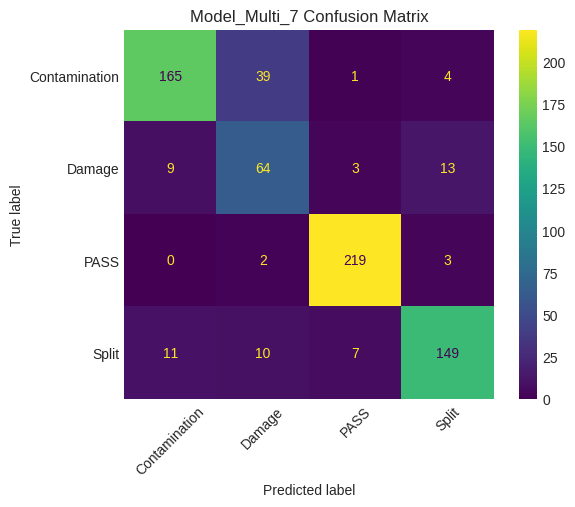

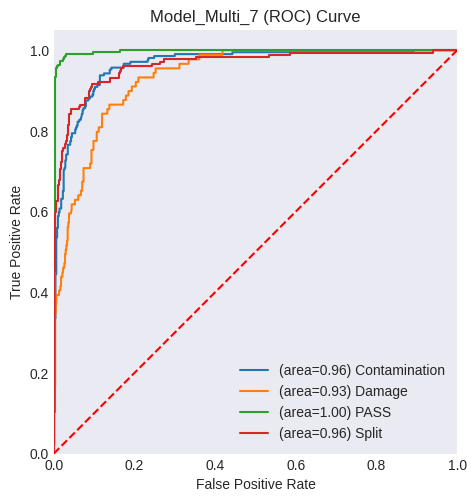

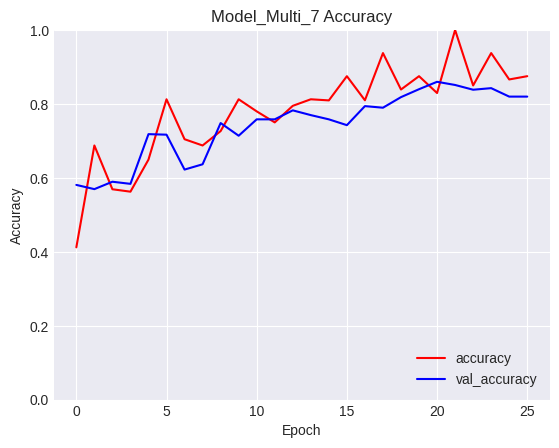

In [ ]:
report_multi_results(model_name, scale_factor, model, history, test_generator)

In [ ]:
model_results_df

Model  Scale Factor  Train Accuracy  Val Accuracy  Test Accuracy
0  Model_Multi_0          0.35        1.000000      0.845494       0.844063
1  Model_Multi_1          0.35        0.588668      0.583691       0.565093
2  Model_Multi_2          0.35        0.415314      0.536481       0.517883
3  Model_Multi_3          0.35        0.821133      0.816881       0.812589
4  Model_Multi_4          0.35        0.125000      0.336195       0.329041
5  Model_Multi_5          0.35        0.262787      0.320458       0.320458
6  Model_Multi_6          0.35        0.937500      0.812589       0.802575
7  Model_Multi_7          0.55        0.829403      0.859800       0.854077

In [ ]:
# save the model_results_df
model_results_df.to_csv('/content/drive/MyDrive/Colab Notebooks/multi_results.csv', index=False)

### ANALYSIS:
- A little better now, 4 CONV layers seems to be the right number.
- Also increased the scale factor.. so not sure why the improvement.  I need to resist trying to change more than one thing at at time!  I have not wanted to try a gridsearch or hyperband due to the massive amount of compute needed for these models
- (After the fact, I suspect this strange behavior had something to do with the Colab steps_per_epoch problem, but I never got around to re-running this model)


---
### Model Multi 8
Changes:
- Added 1 Conv, 1 Dense layer (5 Conv, 4 Dense)
- Scale_factor=0.6

In [ ]:
model_name = 'Model_Multi_8'
num_epochs = 100
original_width = 1024
original_height = 943
scale_factor = 0.6
target_size = (int(original_height*scale_factor), int(original_width*scale_factor))

# Instantiate an ImageDataGenerator for the training set with augmentations
train_datagen = ImageDataGenerator(rescale=1./65535,
                                   horizontal_flip=True,
                                   zoom_range=0.05,
                                   height_shift_range=0.05)

# Instantiate an ImageDataGenerator for the validation set without augmentations
val_datagen = ImageDataGenerator(rescale=1./65535)

# Instantiate the test generator
test_datagen = ImageDataGenerator(rescale=1./65535)

# create the train generator
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size= target_size,
        batch_size=16,
        shuffle=True,
        color_mode='grayscale',
        class_mode='categorical',
        seed=42
)

# create the validation generator
validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size= target_size,
        batch_size=16,
        shuffle=False,
        color_mode='grayscale',
        class_mode='categorical',
        seed=42
)

# create the test generator
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=16,
        shuffle=False,
        color_mode='grayscale',
        class_mode='categorical',
        seed=42
)


# Get the input shape
input_shape = (target_size[0], target_size[1], 1)

# Define the model
model = Sequential([
    Conv2D(32, (3, 3),
           activation='relu',
           input_shape=input_shape,
           padding='valid'),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='valid'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='valid'),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu', padding='valid'),
    MaxPooling2D((2, 2)),

    Conv2D(512, (3, 3), activation='relu', padding='valid'),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(512, activation='relu'),
    Dropout(0.2),

    Dense(512, activation='relu'),
    Dropout(0.2),

    Dense(256, activation='relu'),

    Dense(256, activation='relu'),

    Dense(4, activation='softmax')
])

from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# instantiate early stopping
early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=5, restore_best_weights=True)


# Calculate steps per epoch
steps_per_epoch = train_generator.samples // train_generator.batch_size

# Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(train_generator.classes),
                                                  y=train_generator.classes)
class_weight_dict = {i : class_weights[i] for i in range(len(class_weights))}

# fit the model
history = model.fit(train_generator,
                steps_per_epoch=steps_per_epoch,
                epochs=num_epochs,
                validation_data=validation_generator,
                class_weight=class_weight_dict,
                callbacks=[early_stopping])


Found 3281 images belonging to 4 classes.
Found 699 images belonging to 4 classes.
Found 699 images belonging to 4 classes.
Epoch 1/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 135s 581ms/step - categorical_accuracy: 0.2537 - loss: 1.4066 - val_categorical_accuracy: 0.3920 - val_loss: 1.3430
Epoch 2/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - categorical_accuracy: 0.3125 - loss: 1.2645 - val_categorical_accuracy: 0.1531 - val_loss: 1.3834
Epoch 3/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 113s 535ms/step - categorical_accuracy: 0.3090 - loss: 1.3592 - val_categorical_accuracy: 0.3677 - val_loss: 1.2482
Epoch 4/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - categorical_accuracy: 0.5625 - loss: 1.0350 - val_categorical_accuracy: 0.3763 - val_loss: 1.2321
Epoch 5/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 113s 536ms/step - categorical_accuracy: 0.3461 - loss: 1.2882 - val_categorical_accuracy: 0.3991 - val_loss: 1.1470
Epoch 6/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - categorical_accuracy: 0.5625 - loss: 0.96

In [ ]:
model_path = f'/content/drive/MyDrive/LMIS_Classification/Models{model_name}_binary.pkl'
joblib.dump(model, model_path)

['/content/drive/MyDrive/LMIS_Classification/ModelsModel_Multi_7_binary.pkl']

44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 239ms/step
  Training Accuracy: 0.855
Validation Accuracy: 0.834
      Test Accuracy: 0.841
              precision    recall  f1-score   support

           0       0.86      0.79      0.83       209
           1       0.58      0.67      0.62        89
           2       0.91      0.98      0.94       224
           3       0.87      0.81      0.84       177

    accuracy                           0.84       699
   macro avg       0.81      0.81      0.81       699
weighted avg       0.85      0.84      0.84       699



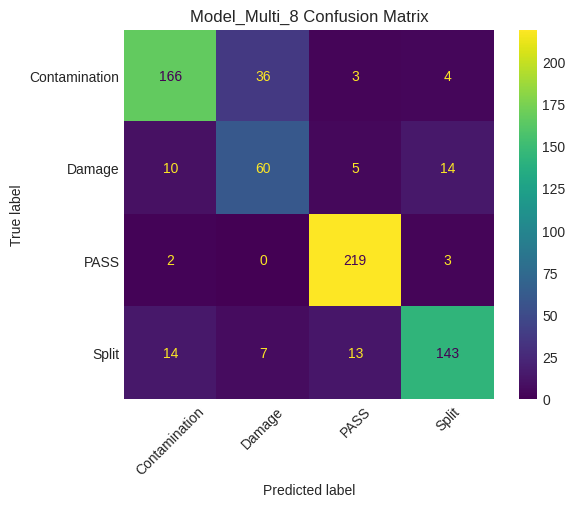

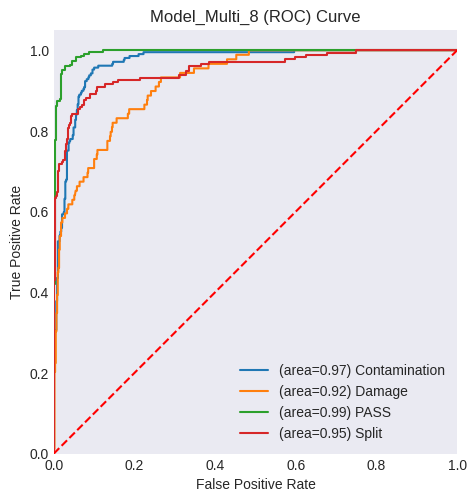

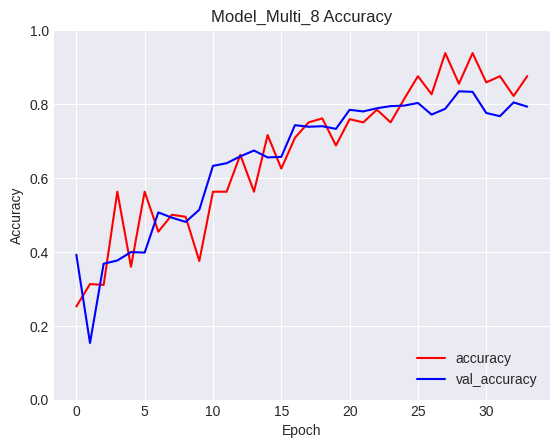

In [ ]:
report_multi_results(model_name, scale_factor, model, history, test_generator)

In [ ]:
model_results_df

Model  Scale Factor  Train Accuracy  Val Accuracy  Test Accuracy
0  Model_Multi_0          0.35        1.000000      0.845494       0.844063
1  Model_Multi_1          0.35        0.588668      0.583691       0.565093
2  Model_Multi_2          0.35        0.415314      0.536481       0.517883
3  Model_Multi_3          0.35        0.821133      0.816881       0.812589
4  Model_Multi_4          0.35        0.125000      0.336195       0.329041
5  Model_Multi_5          0.35        0.262787      0.320458       0.320458
6  Model_Multi_6          0.35        0.937500      0.812589       0.802575
7  Model_Multi_7          0.55        0.829403      0.859800       0.854077
8  Model_Multi_8          0.60        0.854518      0.834049       0.841202

In [ ]:
# save the model_results_df
model_results_df.to_csv('/content/drive/MyDrive/Colab Notebooks/multi_results.csv', index=False)

### ANALYSIS:
- Odd that adding another CONV layer + dense layer wouldnt have similar results as 5 CONV earlier.
- (After the fact, I suspect this strange behavior had something to do with the Colab steps_per_epoch problem, but I never got around to re-running this model)


---
### Model Multi 9
Changes:
- Removed 1 Conv (4 Conv, 4 Dense)
- Scale_factor=0.6

In [ ]:
model_name = 'Model_Multi_9'
num_epochs = 100
original_width = 1024
original_height = 943
scale_factor = 0.6
target_size = (int(original_height*scale_factor), int(original_width*scale_factor))

# Instantiate an ImageDataGenerator for the training set with augmentations
train_datagen = ImageDataGenerator(rescale=1./65535,
                                   horizontal_flip=True,
                                   zoom_range=0.05,
                                   height_shift_range=0.05)

# Instantiate an ImageDataGenerator for the validation set without augmentations
val_datagen = ImageDataGenerator(rescale=1./65535)

# Instantiate the test generator
test_datagen = ImageDataGenerator(rescale=1./65535)

# create the train generator
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size= target_size,
        batch_size=16,
        shuffle=True,
        color_mode='grayscale',
        class_mode='categorical',
        seed=42
)

# create the validation generator
validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size= target_size,
        batch_size=16,
        shuffle=False,
        color_mode='grayscale',
        class_mode='categorical',
        seed=42
)

# create the test generator
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=16,
        shuffle=False,
        color_mode='grayscale',
        class_mode='categorical',
        seed=42
)


# Get the input shape
input_shape = (target_size[0], target_size[1], 1)

# Define the model
model = Sequential([
    Conv2D(32, (3, 3),
           activation='relu',
           input_shape=input_shape,
           padding='valid'),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='valid'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='valid'),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu', padding='valid'),
    MaxPooling2D((2, 2)),

    # Conv2D(512, (3, 3), activation='relu', padding='valid'),
    # MaxPooling2D((2, 2)),

    Flatten(),

    Dense(512, activation='relu'),
    Dropout(0.2),

    Dense(512, activation='relu'),
    Dropout(0.2),

    Dense(256, activation='relu'),

    Dense(256, activation='relu'),

    Dense(4, activation='softmax')
])

from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# instantiate early stopping
early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=5, restore_best_weights=True)


# Calculate steps per epoch
steps_per_epoch = train_generator.samples // train_generator.batch_size

# Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(train_generator.classes),
                                                  y=train_generator.classes)
class_weight_dict = {i : class_weights[i] for i in range(len(class_weights))}

# fit the model
history = model.fit(train_generator,
                steps_per_epoch=steps_per_epoch,
                epochs=num_epochs,
                validation_data=validation_generator,
                class_weight=class_weight_dict,
                callbacks=[early_stopping])


Found 3281 images belonging to 4 classes.
Found 699 images belonging to 4 classes.
Found 699 images belonging to 4 classes.
Epoch 1/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 126s 564ms/step - categorical_accuracy: 0.2589 - loss: 1.6844 - val_categorical_accuracy: 0.3934 - val_loss: 1.3020
Epoch 2/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - categorical_accuracy: 0.5000 - loss: 1.2749 - val_categorical_accuracy: 0.3848 - val_loss: 1.3206
Epoch 3/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 114s 538ms/step - categorical_accuracy: 0.3681 - loss: 1.3493 - val_categorical_accuracy: 0.4607 - val_loss: 1.2294
Epoch 4/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - categorical_accuracy: 0.3125 - loss: 1.2189 - val_categorical_accuracy: 0.4979 - val_loss: 1.2028
Epoch 5/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 114s 540ms/step - categorical_accuracy: 0.4315 - loss: 1.2547 - val_categorical_accuracy: 0.6309 - val_loss: 0.9501
Epoch 6/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - categorical_accuracy: 0.5000 - loss: 1.

In [ ]:
model_path = f'/content/drive/MyDrive/LMIS_Classification/Models{model_name}_binary.pkl'
joblib.dump(model, model_path)

['/content/drive/MyDrive/LMIS_Classification/ModelsModel_Multi_7_binary.pkl']

44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 239ms/step
  Training Accuracy: 0.750
Validation Accuracy: 0.803
      Test Accuracy: 0.764
              precision    recall  f1-score   support

           0       0.80      0.64      0.71       209
           1       0.47      0.63      0.54        89
           2       0.92      0.95      0.93       224
           3       0.73      0.75      0.74       177

    accuracy                           0.76       699
   macro avg       0.73      0.74      0.73       699
weighted avg       0.78      0.76      0.77       699



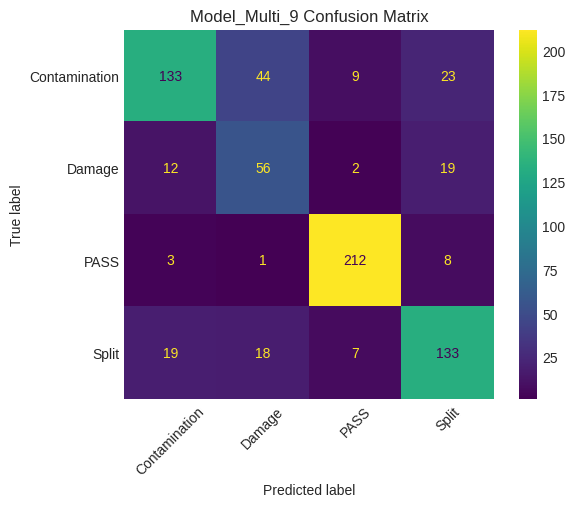

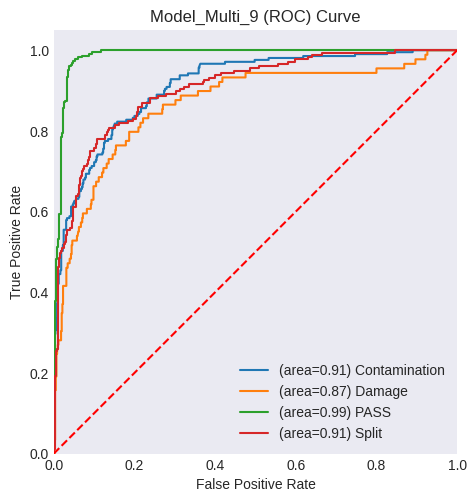

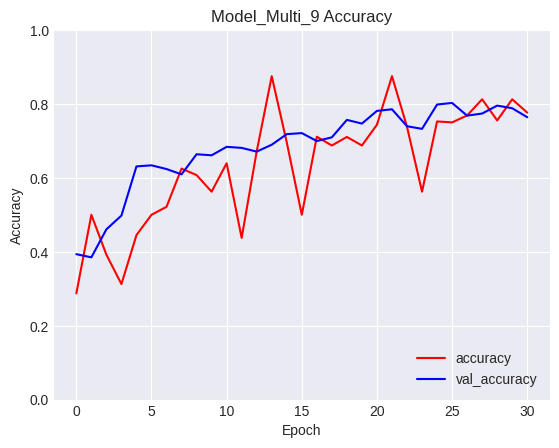

In [ ]:
report_multi_results(model_name, scale_factor, model, history, test_generator)

In [ ]:
model_results_df

Model  Scale Factor  Train Accuracy  Val Accuracy  Test Accuracy
0  Model_Multi_0          0.35        1.000000      0.845494       0.844063
1  Model_Multi_1          0.35        0.588668      0.583691       0.565093
2  Model_Multi_2          0.35        0.415314      0.536481       0.517883
3  Model_Multi_3          0.35        0.821133      0.816881       0.812589
4  Model_Multi_4          0.35        0.125000      0.336195       0.329041
5  Model_Multi_5          0.35        0.262787      0.320458       0.320458
6  Model_Multi_6          0.35        0.937500      0.812589       0.802575
7  Model_Multi_7          0.55        0.829403      0.859800       0.854077
8  Model_Multi_8          0.60        0.854518      0.834049       0.841202
9  Model_Multi_9          0.60        0.750000      0.802575       0.763949

In [ ]:
# save the model_results_df
model_results_df.to_csv('/content/drive/MyDrive/Colab Notebooks/multi_results.csv', index=False)

### ANALYSIS:
- Good result for PASS false-pos, not great for everything else.
- (After the fact, I suspect this strange behavior had something to do with the Colab steps_per_epoch problem, but I never got around to re-running this model)


---
### Model Multi 10
Changes:
- Getting frustrated with strange and inconsistend results; trying 'Deep Learning for Vison Systems' (Mohamed Elgendy) book example architecture (mini AlexNet)
- scale_factor=0.6


In [ ]:
model_name = 'Model_Multi_10'
num_epochs = 100
original_width = 1024
original_height = 943
scale_factor = 0.6
target_size = (int(original_height*scale_factor), int(original_width*scale_factor))

# Instantiate an ImageDataGenerator for the training set with augmentations
train_datagen = ImageDataGenerator(rescale=1./65535,
                                   horizontal_flip=True,
                                   zoom_range=0.05,
                                   height_shift_range=0.05)

# Instantiate an ImageDataGenerator for the validation set without augmentations
val_datagen = ImageDataGenerator(rescale=1./65535)

# Instantiate the test generator
test_datagen = ImageDataGenerator(rescale=1./65535)

# create the train generator
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size= target_size,
        batch_size=16,
        shuffle=True,
        color_mode='grayscale',
        class_mode='categorical',
        seed=42
)

# create the validation generator
validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size= target_size,
        batch_size=16,
        shuffle=False,
        color_mode='grayscale',
        class_mode='categorical',
        seed=42
)

# create the test generator
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=16,
        shuffle=False,
        color_mode='grayscale',
        class_mode='categorical',
        seed=42
)


# Get the input shape
input_shape = (target_size[0], target_size[1], 1)

# Define the model
model = Sequential([
    Conv2D(16,
           kernel_size=(2, 2),
           activation='relu',
           input_shape=input_shape,
           padding='same'),
    MaxPooling2D((2, 2)),

    Conv2D(32,
           kernel_size=(2, 2),
           activation='relu',
           padding='same'),
    MaxPooling2D((2, 2)),

    Conv2D(64,
           kernel_size=(2, 2),
           activation='relu',
           padding='same'),
    MaxPooling2D((2, 2)),

    # Conv2D(256, (3, 3), activation='relu', padding='valid'),
    # MaxPooling2D((2, 2)),

    # Conv2D(512, (3, 3), activation='relu', padding='valid'),
    # MaxPooling2D((2, 2)),

    Dropout(0.3),

    Flatten(),

    Dense(512, activation='relu'),
    Dropout(0.4),

    # Dense(512, activation='relu'),
    # Dropout(0.2),

    # Dense(256, activation='relu'),

    # Dense(256, activation='relu'),

    Dense(4, activation='softmax')
])

from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# instantiate early stopping
early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=5, restore_best_weights=True)


# Calculate steps per epoch
steps_per_epoch = train_generator.samples // train_generator.batch_size

# Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(train_generator.classes),
                                                  y=train_generator.classes)
class_weight_dict = {i : class_weights[i] for i in range(len(class_weights))}

model.summary()


Found 3281 images belonging to 4 classes.
Found 699 images belonging to 4 classes.
Found 699 images belonging to 4 classes.


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_33 (Conv2D)                   │ (None, 565, 614, 16)        │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_33 (MaxPooling2D)      │ (None, 282, 307, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 282, 307, 32)        │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_34 (MaxPooling2D)      │ (None, 141, 153, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (None, 141, 153, 64)        │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_35 (MaxPooling2D)      │ (None, 70, 76, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 70, 76, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 340480)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 512)                 │     174,326,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 174,338,740 (665.05 MB)

 Trainable params: 174,338,740 (665.05 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# fit the model
history = model.fit(train_generator,
                steps_per_epoch=steps_per_epoch,
                epochs=num_epochs,
                validation_data=validation_generator,
                class_weight=class_weight_dict,
                callbacks=[early_stopping])

Epoch 1/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 121s 559ms/step - categorical_accuracy: 0.3537 - loss: 5.5902 - val_categorical_accuracy: 0.4206 - val_loss: 1.1581
Epoch 2/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - categorical_accuracy: 0.5000 - loss: 1.0733 - val_categorical_accuracy: 0.5579 - val_loss: 0.9996
Epoch 3/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 114s 538ms/step - categorical_accuracy: 0.4763 - loss: 1.1901 - val_categorical_accuracy: 0.6280 - val_loss: 0.9496
Epoch 4/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - categorical_accuracy: 0.7500 - loss: 1.0519 - val_categorical_accuracy: 0.6123 - val_loss: 0.9593
Epoch 5/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 112s 531ms/step - categorical_accuracy: 0.5532 - loss: 1.0851 - val_categorical_accuracy: 0.5837 - val_loss: 0.9847
Epoch 6/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - categorical_accuracy: 0.6250 - loss: 1.1949 - val_categorical_accuracy: 0.5980 - val_loss: 0.9975
Epoch 7/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 112s 530ms/step - categor

In [ ]:
model_path = f'/content/drive/MyDrive/LMIS_Classification/Models{model_name}_binary.pkl'
joblib.dump(model, model_path)

['/content/drive/MyDrive/LMIS_Classification/ModelsModel_Multi_7_binary.pkl']

44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 213ms/step
  Training Accuracy: 0.505
Validation Accuracy: 0.628
      Test Accuracy: 0.631
              precision    recall  f1-score   support

           0       0.68      0.31      0.43       209
           1       0.43      0.29      0.35        89
           2       0.75      0.92      0.82       224
           3       0.54      0.81      0.65       177

    accuracy                           0.63       699
   macro avg       0.60      0.58      0.56       699
weighted avg       0.63      0.63      0.60       699



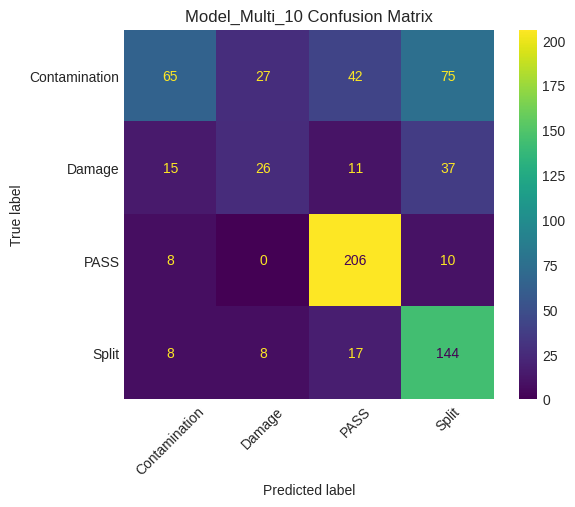

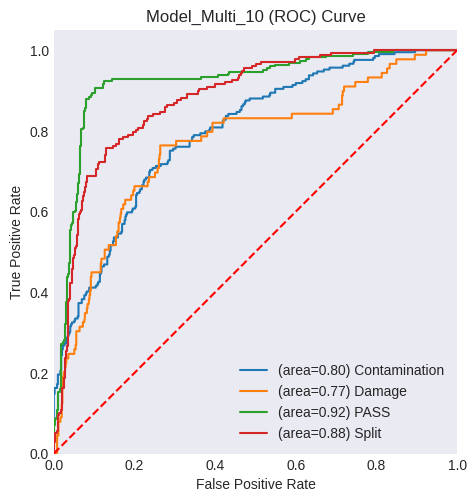

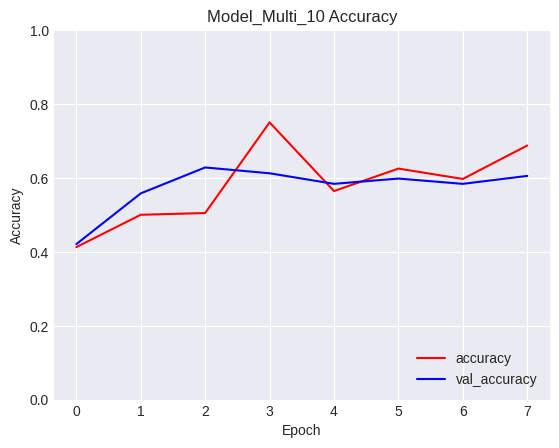

In [ ]:
report_multi_results(model_name, scale_factor, model, history, test_generator)

In [ ]:
model_results_df

Model  Scale Factor  Train Accuracy  Val Accuracy  Test Accuracy
0    Model_Multi_0          0.35        1.000000      0.845494       0.844063
1    Model_Multi_1          0.35        0.588668      0.583691       0.565093
2    Model_Multi_2          0.35        0.415314      0.536481       0.517883
3    Model_Multi_3          0.35        0.821133      0.816881       0.812589
4    Model_Multi_4          0.35        0.125000      0.336195       0.329041
5    Model_Multi_5          0.35        0.262787      0.320458       0.320458
6    Model_Multi_6          0.35        0.937500      0.812589       0.802575
7    Model_Multi_7          0.55        0.829403      0.859800       0.854077
8    Model_Multi_8          0.60        0.854518      0.834049       0.841202
9    Model_Multi_9          0.60        0.750000      0.802575       0.763949
10  Model_Multi_10          0.60        0.504747      0.628040       0.630901

In [ ]:
# save the model_results_df
model_results_df.to_csv('/content/drive/MyDrive/Colab Notebooks/multi_results.csv', index=False)

### ANALYSIS:
- Not impressed.
- (After the fact, I suspect this strange behavior had something to do with the Colab steps_per_epoch problem, but I never got around to re-running this model)


---
### Model Multi 11
Changes:
- Trying DL for VS book example architecture (mini AlexNet)
- Adding Dense layer
- Scale_factor=0.35

In [ ]:
model_name = 'Model_Multi_11'
num_epochs = 100
original_width = 1024
original_height = 943
scale_factor = 0.5
target_size = (int(original_height*scale_factor), int(original_width*scale_factor))

# Instantiate an ImageDataGenerator for the training set with augmentations
train_datagen = ImageDataGenerator(rescale=1./65535,
                                   horizontal_flip=True,
                                   zoom_range=0.05,
                                   height_shift_range=0.05)

# Instantiate an ImageDataGenerator for the validation set without augmentations
val_datagen = ImageDataGenerator(rescale=1./65535)

# Instantiate the test generator
test_datagen = ImageDataGenerator(rescale=1./65535)

# create the train generator
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size= target_size,
        batch_size=16,
        shuffle=True,
        color_mode='grayscale',
        class_mode='categorical',
        seed=42
)

# create the validation generator
validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size= target_size,
        batch_size=16,
        shuffle=False,
        color_mode='grayscale',
        class_mode='categorical',
        seed=42
)

# create the test generator
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=16,
        shuffle=False,
        color_mode='grayscale',
        class_mode='categorical',
        seed=42
)


# Get the input shape
input_shape = (target_size[0], target_size[1], 1)

# Define the model
model = Sequential([
    Conv2D(16,
           kernel_size=(2, 2),
           activation='relu',
           input_shape=input_shape,
           padding='same'),
    MaxPooling2D((2, 2)),

    Conv2D(32,
           kernel_size=(2, 2),
           activation='relu',
           padding='same'),
    MaxPooling2D((2, 2)),

    Conv2D(64,
           kernel_size=(2, 2),
           activation='relu',
           padding='same'),
    MaxPooling2D((2, 2)),

    # Conv2D(256, (3, 3), activation='relu', padding='valid'),
    # MaxPooling2D((2, 2)),

    # Conv2D(512, (3, 3), activation='relu', padding='valid'),
    # MaxPooling2D((2, 2)),

    Dropout(0.3),

    Flatten(),

    Dense(512, activation='relu'),
    Dropout(0.4),

    Dense(512, activation='relu'),
    Dropout(0.2),

    Dense(256, activation='relu'),

    # Dense(256, activation='relu'),

    Dense(4, activation='softmax')
])

from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# instantiate early stopping
early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=5, restore_best_weights=True)


# Calculate steps per epoch
steps_per_epoch = train_generator.samples // train_generator.batch_size

# Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(train_generator.classes),
                                                  y=train_generator.classes)
class_weight_dict = {i : class_weights[i] for i in range(len(class_weights))}

model.summary()


Found 3281 images belonging to 4 classes.
Found 699 images belonging to 4 classes.
Found 699 images belonging to 4 classes.


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_39 (Conv2D)                   │ (None, 471, 512, 16)        │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_39 (MaxPooling2D)      │ (None, 235, 256, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_40 (Conv2D)                   │ (None, 235, 256, 32)        │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_40 (MaxPooling2D)      │ (None, 117, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_41 (Conv2D)                   │ (None, 117, 128, 64)        │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_41 (MaxPooling2D)      │ (None, 58, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 58, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 237568)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 512)                 │     121,635,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_40 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 122,040,756 (465.55 MB)

 Trainable params: 122,040,756 (465.55 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# fit the model
history = model.fit(train_generator,
                steps_per_epoch=steps_per_epoch,
                epochs=num_epochs,
                validation_data=validation_generator,
                class_weight=class_weight_dict,
                shuffle=True,
                callbacks=[early_stopping])

Epoch 1/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 102s 457ms/step - categorical_accuracy: 0.3090 - loss: 1.4972 - val_categorical_accuracy: 0.4506 - val_loss: 1.1234
Epoch 2/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - categorical_accuracy: 0.6250 - loss: 1.1714 - val_categorical_accuracy: 0.4235 - val_loss: 1.1378
Epoch 3/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 91s 430ms/step - categorical_accuracy: 0.4506 - loss: 1.1875 - val_categorical_accuracy: 0.5207 - val_loss: 1.0551
Epoch 4/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - categorical_accuracy: 0.5000 - loss: 0.9773 - val_categorical_accuracy: 0.6009 - val_loss: 0.9736
Epoch 5/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 91s 430ms/step - categorical_accuracy: 0.5548 - loss: 1.1001 - val_categorical_accuracy: 0.6195 - val_loss: 0.9833
Epoch 6/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - categorical_accuracy: 0.6875 - loss: 0.6281 - val_categorical_accuracy: 0.6724 - val_loss: 1.0895
Epoch 7/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 91s 430ms/step - categorical

In [ ]:
model_path = f'/content/drive/MyDrive/LMIS_Classification/Models{model_name}_binary.pkl'
joblib.dump(model, model_path)

['/content/drive/MyDrive/LMIS_Classification/ModelsModel_Multi_7_binary.pkl']

44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 218ms/step
  Training Accuracy: 0.648
Validation Accuracy: 0.698
      Test Accuracy: 0.691
              precision    recall  f1-score   support

           0       0.58      0.69      0.63       209
           1       0.42      0.06      0.10        89
           2       0.87      0.90      0.89       224
           3       0.63      0.75      0.69       177

    accuracy                           0.69       699
   macro avg       0.63      0.60      0.58       699
weighted avg       0.67      0.69      0.66       699



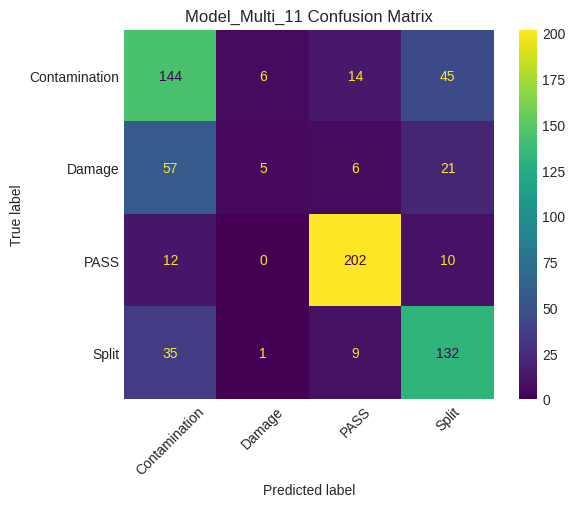

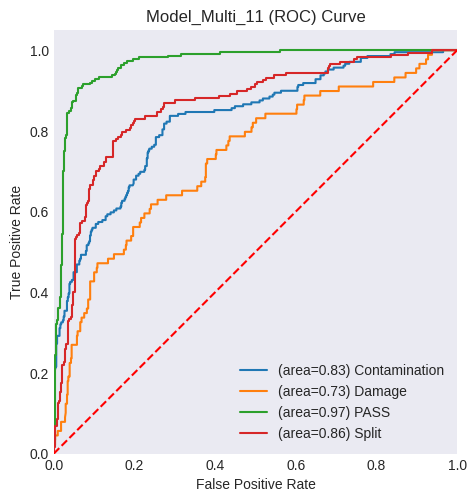

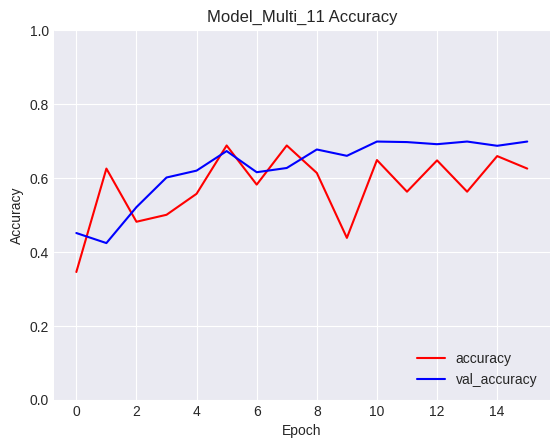

In [ ]:
report_multi_results(model_name, scale_factor, model, history, test_generator)

In [ ]:
model_results_df

Model  Scale Factor  Train Accuracy  Val Accuracy  Test Accuracy
0    Model_Multi_0          0.35        1.000000      0.845494       0.844063
1    Model_Multi_1          0.35        0.588668      0.583691       0.565093
2    Model_Multi_2          0.35        0.415314      0.536481       0.517883
3    Model_Multi_3          0.35        0.821133      0.816881       0.812589
4    Model_Multi_4          0.35        0.125000      0.336195       0.329041
5    Model_Multi_5          0.35        0.262787      0.320458       0.320458
6    Model_Multi_6          0.35        0.937500      0.812589       0.802575
7    Model_Multi_7          0.55        0.829403      0.859800       0.854077
8    Model_Multi_8          0.60        0.854518      0.834049       0.841202
9    Model_Multi_9          0.60        0.750000      0.802575       0.763949
10  Model_Multi_10          0.60        0.504747      0.628040       0.630901
11  Model_Multi_11          0.50        0.648086      0.698140       0.690987

In [ ]:
# save the model_results_df
model_results_df.to_csv('/content/drive/MyDrive/Colab Notebooks/multi_results.csv', index=False)

### ANALYSIS:
- Decent improvement but not back up to where we were with our basic model.
- (After the fact, I suspect this strange behavior had something to do with the Colab steps_per_epoch problem, but I never got around to re-running this model)


---
### Model Multi 12
Changes:
- Trying ResNet50


In [ ]:
model_name = 'Model_Multi_12'
num_epochs = 100
original_width = 1024
original_height = 943
scale_factor = 0.5
target_size = (int(original_height*scale_factor), int(original_width*scale_factor))

# Define the input shape with 3 channels
input_shape = (target_size[0], target_size[1], 3)

# Function to convert grayscale to RGB
def preprocess_input(x):
    if x.shape[-1] == 1:
        x = np.repeat(x, 3, axis=-1)
    return x

# Instantiate ImageDataGenerators with preprocessing function
train_datagen = ImageDataGenerator(rescale=1./65535,
                                   horizontal_flip=True,
                                   zoom_range=0.05,
                                   height_shift_range=0.05,
                                   preprocessing_function=preprocess_input)

val_datagen = ImageDataGenerator(rescale=1./65535,
                                 preprocessing_function=preprocess_input)

test_datagen = ImageDataGenerator(rescale=1./65535,
                                  preprocessing_function=preprocess_input)

# Create the train generator
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=target_size,
        batch_size=16,
        shuffle=True,
        color_mode='rgb',  # Change to 'rgb'
        class_mode='categorical',
        seed=42
)

# Create the validation generator
validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=target_size,
        batch_size=16,
        shuffle=False,
        color_mode='rgb',  # Change to 'rgb'
        class_mode='categorical',
        seed=42
)

# Create the test generator
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=16,
        shuffle=False,
        color_mode='rgb',  # Change to 'rgb'
        class_mode='categorical',
        seed=42
)

# Load the ResNet50 model with pre-trained weights, excluding the top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Create a new input layer with the desired input shape
input_layer = Input(shape=input_shape)

# Use the base model with the new input layer
x = base_model(input_layer)

# Flatten the output of the base model
x = Flatten()(x)

# Add a fully connected layer with 512 units and ReLU activation
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)

# Add a fully connected layer with the number of classes
num_classes = train_generator.num_classes
output_layer = Dense(num_classes, activation='softmax')(x)

# Create the new model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Instantiate early stopping
early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=5, restore_best_weights=True)

# Calculate steps per epoch
steps_per_epoch = train_generator.samples // train_generator.batch_size
val_steps = validation_generator.samples // validation_generator.batch_size

# Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(train_generator.classes),
                                                  y=train_generator.classes)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Print model summary
model.summary()

Found 3281 images belonging to 4 classes.
Found 699 images belonging to 4 classes.
Found 699 images belonging to 4 classes.


Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_25 (InputLayer)          │ (None, 471, 512, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 15, 16, 2048)        │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_18 (Flatten)                 │ (None, 491520)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_49 (Dense)                     │ (None, 512)                 │     251,658,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_50 (Dense)                     │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 275,248,516 (1.03 GB)

 Trainable params: 275,195,396 (1.03 GB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
# Fit the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=val_steps,
    class_weight=class_weight_dict,
    callbacks=[early_stopping]
)

Epoch 1/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 271s 1s/step - categorical_accuracy: 0.5220 - loss: 6.3027 - val_categorical_accuracy: 0.3038 - val_loss: 1.3996
Epoch 2/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - categorical_accuracy: 0.6250 - loss: 1.1933 - val_categorical_accuracy: 0.0000e+00 - val_loss: 1.8106
Epoch 3/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 196s 924ms/step - categorical_accuracy: 0.6977 - loss: 0.8825 - val_categorical_accuracy: 0.3038 - val_loss: 1.4168
Epoch 4/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step - categorical_accuracy: 0.7500 - loss: 0.6468 - val_categorical_accuracy: 0.0000e+00 - val_loss: 1.7594
Epoch 5/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 195s 922ms/step - categorical_accuracy: 0.7047 - loss: 0.8579 - val_categorical_accuracy: 0.1294 - val_loss: 1.5663
Epoch 6/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step - categorical_accuracy: 0.5625 - loss: 1.2228 - val_categorical_accuracy: 0.0000e+00 - val_loss: 2.0118


44/44 ━━━━━━━━━━━━━━━━━━━━ 17s 324ms/step
  Training Accuracy: 0.602
Validation Accuracy: 0.304
      Test Accuracy: 0.299
              precision    recall  f1-score   support

           0       0.30      1.00      0.46       209
           1       0.00      0.00      0.00        89
           2       0.00      0.00      0.00       224
           3       0.00      0.00      0.00       177

    accuracy                           0.30       699
   macro avg       0.07      0.25      0.12       699
weighted avg       0.09      0.30      0.14       699



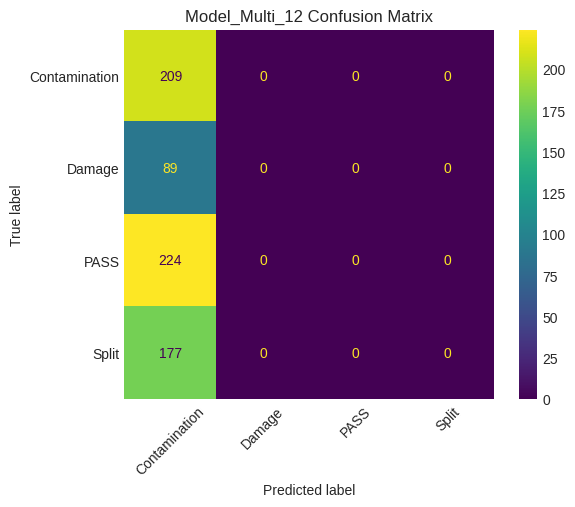

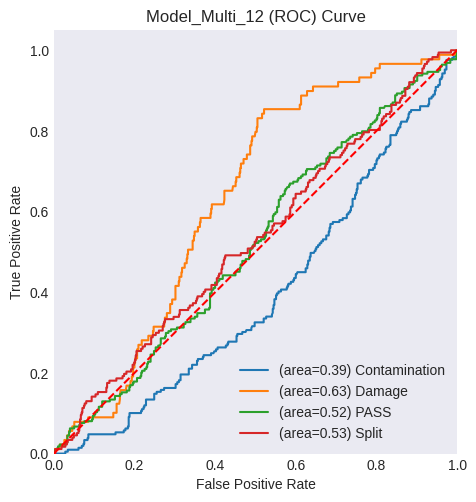

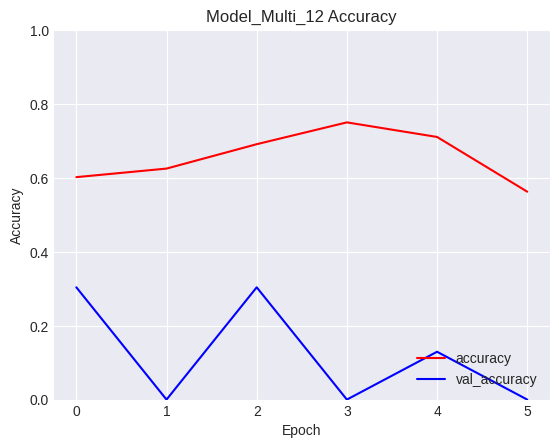

In [ ]:
report_multi_results(model_name, scale_factor, model, history, test_generator)

In [ ]:
model_results_df

Model  Scale Factor  Train Accuracy  Val Accuracy  Test Accuracy
0    Model_Multi_0          0.35        1.000000      0.845494       0.844063
1    Model_Multi_1          0.35        0.588668      0.583691       0.565093
2    Model_Multi_2          0.35        0.415314      0.536481       0.517883
3    Model_Multi_3          0.35        0.821133      0.816881       0.812589
4    Model_Multi_4          0.35        0.125000      0.336195       0.329041
5    Model_Multi_5          0.35        0.262787      0.320458       0.320458
6    Model_Multi_6          0.35        0.937500      0.812589       0.802575
7    Model_Multi_7          0.55        0.829403      0.859800       0.854077
8    Model_Multi_8          0.60        0.854518      0.834049       0.841202
9    Model_Multi_9          0.60        0.750000      0.802575       0.763949
10  Model_Multi_10          0.60        0.504747      0.628040       0.630901
11  Model_Multi_11          0.50        0.648086      0.698140       0.690987
12  Model_Multi_12          0.50        0.601838      0.303779       0.298999

In [ ]:
# save the model_results_df
model_results_df.to_csv('/content/drive/MyDrive/Colab Notebooks/multi_results.csv', index=False)

### ANALYSIS:
- That didn't work at all.  Need to study more on how to implement this model.
- (After the fact, I suspect this strange behavior had something to do with the Colab steps_per_epoch problem, but I never got around to re-running this model)


---
### Model Multi 13
Changes:
- Added 1 Conv layer (4 Conv, 3 Dense)
- Increase scale_factor=0.55

In [ ]:
model_name = 'Model_Multi_13'
num_epochs = 100
original_width = 1024
original_height = 943
scale_factor = 0.55
target_size = (int(original_height*scale_factor), int(original_width*scale_factor))

# Instantiate an ImageDataGenerator for the training set with augmentations
train_datagen = ImageDataGenerator(rescale=1./65535,
                                   horizontal_flip=True,
                                   zoom_range=0.05,
                                   height_shift_range=0.05)

# Instantiate an ImageDataGenerator for the validation set without augmentations
val_datagen = ImageDataGenerator(rescale=1./65535)

# Instantiate the test generator
test_datagen = ImageDataGenerator(rescale=1./65535)

# create the train generator
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size= target_size,
        batch_size=16,
        shuffle=True,
        color_mode='grayscale',
        class_mode='categorical',
        seed=42
)

# create the validation generator
validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size= target_size,
        batch_size=16,
        shuffle=False,
        color_mode='grayscale',
        class_mode='categorical',
        seed=42
)

# create the test generator
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=16,
        shuffle=False,
        color_mode='grayscale',
        class_mode='categorical',
        seed=42
)


# Get the input shape
input_shape = (target_size[0], target_size[1], 1)

# Define the model
model = Sequential([
    Conv2D(32, (3, 3),
           activation='relu',
           input_shape=input_shape,
           padding='valid'),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='valid'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='valid'),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu', padding='valid'),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(512, activation='relu'),
    Dropout(0.2),

    Dense(512, activation='relu'),

    Dense(256, activation='relu'),
    Dense(4, activation='softmax')
])

from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# instantiate early stopping
early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=5, restore_best_weights=True)


# Calculate steps per epoch
steps_per_epoch = train_generator.samples // train_generator.batch_size

# Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(train_generator.classes),
                                                  y=train_generator.classes)
class_weight_dict = {i : class_weights[i] for i in range(len(class_weights))}

# fit the model
history = model.fit(train_generator,
                steps_per_epoch=steps_per_epoch,
                epochs=num_epochs,
                validation_data=validation_generator,
                class_weight=class_weight_dict,
                callbacks=[early_stopping])

Found 3281 images belonging to 4 classes.
Found 699 images belonging to 4 classes.
Found 699 images belonging to 4 classes.
Epoch 1/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 128s 545ms/step - categorical_accuracy: 0.3419 - loss: 1.3935 - val_categorical_accuracy: 0.4506 - val_loss: 1.1777
Epoch 2/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - categorical_accuracy: 0.3125 - loss: 1.3947 - val_categorical_accuracy: 0.4406 - val_loss: 1.1978
Epoch 3/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 106s 500ms/step - categorical_accuracy: 0.4390 - loss: 1.2573 - val_categorical_accuracy: 0.5908 - val_loss: 1.0085
Epoch 4/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - categorical_accuracy: 0.5625 - loss: 1.0871 - val_categorical_accuracy: 0.5565 - val_loss: 1.0596
Epoch 5/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 105s 496ms/step - categorical_accuracy: 0.5572 - loss: 1.0532 - val_categorical_accuracy: 0.6123 - val_loss: 1.0229
Epoch 6/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - categorical_accuracy: 0.7500 - loss: 1.20

In [ ]:
from tensorflow.keras.models import load_model
model_path = f'/content/drive/MyDrive/LMIS_Classification/Models{model_name}.h5'
model.save(model_path)

44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 226ms/step
  Training Accuracy: 0.875
Validation Accuracy: 0.854
      Test Accuracy: 0.835
              precision    recall  f1-score   support

           0       0.88      0.77      0.82       209
           1       0.56      0.65      0.60        89
           2       0.90      0.97      0.94       224
           3       0.85      0.84      0.84       177

    accuracy                           0.84       699
   macro avg       0.80      0.81      0.80       699
weighted avg       0.84      0.84      0.84       699



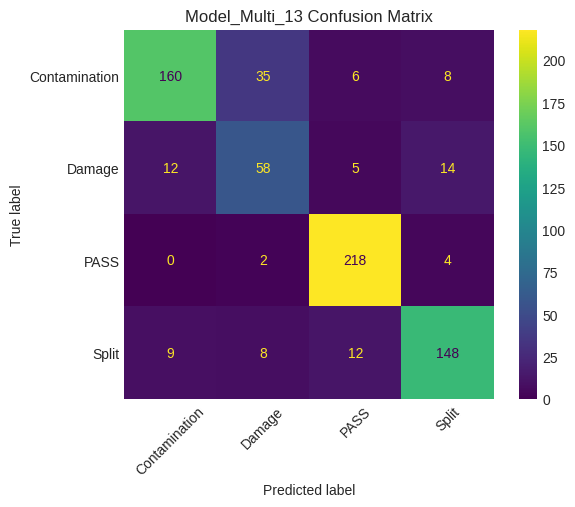

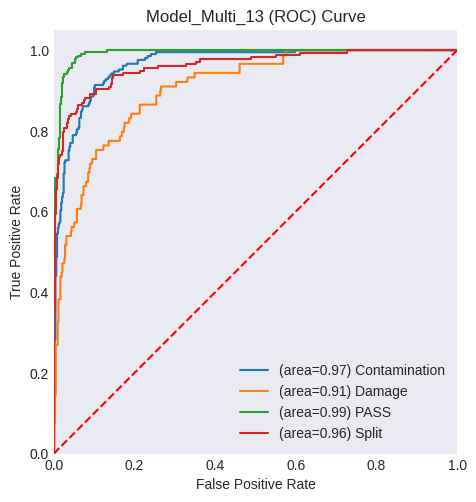

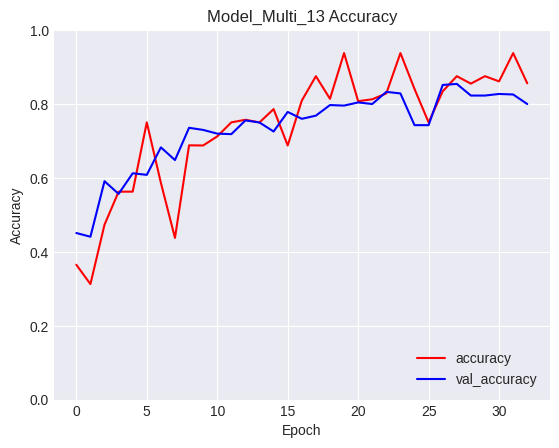

In [ ]:
report_multi_results(model_name, scale_factor, model, history, test_generator)

In [ ]:
model_results_df

Model  Scale Factor  Train Accuracy  Val Accuracy  Test Accuracy
0    Model_Multi_0          0.35        1.000000      0.845494       0.844063
1    Model_Multi_1          0.35        0.588668      0.583691       0.565093
2    Model_Multi_2          0.35        0.415314      0.536481       0.517883
3    Model_Multi_3          0.35        0.821133      0.816881       0.812589
4    Model_Multi_4          0.35        0.125000      0.336195       0.329041
5    Model_Multi_5          0.35        0.262787      0.320458       0.320458
6    Model_Multi_6          0.35        0.937500      0.812589       0.802575
7    Model_Multi_7          0.55        0.829403      0.859800       0.854077
8    Model_Multi_8          0.60        0.854518      0.834049       0.841202
9    Model_Multi_9          0.60        0.750000      0.802575       0.763949
10  Model_Multi_10          0.60        0.504747      0.628040       0.630901
11  Model_Multi_11          0.50        0.648086      0.698140       0.690987
12  Model_Multi_12          0.50        0.601838      0.303779       0.298999
13  Model_Multi_13          0.55        0.875000      0.854077       0.835479

In [ ]:
# save the model_results_df
model_results_df.to_csv('/content/drive/MyDrive/Colab Notebooks/multi_results.csv', index=False)

### ANALYSIS:
- Back to similar results with the previous models, marginal improvement by increasing scale factor
- (After the fact, I suspect this strange behavior had something to do with the Colab steps_per_epoch problem, but I never got around to re-running this model)


---
### Model Multi 14
Changes:
- Trying to fix colab even epoch wierdness: Removed steps_per_epoch!
- Changed early_stop monitor to 'loss'

In [ ]:
model_name = 'Model_Multi_14'
num_epochs = 100
original_width = 1024
original_height = 943
scale_factor = 0.55
target_size = (int(original_height*scale_factor), int(original_width*scale_factor))

# Instantiate an ImageDataGenerator for the training set with augmentations
train_datagen = ImageDataGenerator(rescale=1./65535,
                                   horizontal_flip=True,
                                   zoom_range=0.05,
                                   height_shift_range=0.05)

# Instantiate an ImageDataGenerator for the validation set without augmentations
val_datagen = ImageDataGenerator(rescale=1./65535)

# Instantiate the test generator
test_datagen = ImageDataGenerator(rescale=1./65535)

# create the train generator
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size= target_size,
        batch_size=16,
        shuffle=True,
        color_mode='grayscale',
        class_mode='categorical',
        seed=42
)

# create the validation generator
validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size= target_size,
        batch_size=16,
        shuffle=False,
        color_mode='grayscale',
        class_mode='categorical',
)

# create the test generator
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=16,
        shuffle=False,
        color_mode='grayscale',
        class_mode='categorical',
)


# Get the input shape
input_shape = (target_size[0], target_size[1], 1)

# Define the model
model = Sequential([
    Conv2D(32, (3, 3),
           activation='relu',
           input_shape=input_shape,
           padding='valid'),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='valid'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='valid'),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu', padding='valid'),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(512, activation='relu'),
    Dropout(0.2),

    Dense(512, activation='relu'),

    Dense(256, activation='relu'),
    Dense(4, activation='softmax')
])

from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# instantiate early stopping
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)


# Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(train_generator.classes),
                                                  y=train_generator.classes)
class_weight_dict = {i : class_weights[i] for i in range(len(class_weights))}


# fit the model
history = model.fit(train_generator,
                epochs=num_epochs,
                validation_data=validation_generator,
                class_weight=class_weight_dict,
                # shuffle=True,
                callbacks=[early_stopping]
)

Found 3281 images belonging to 4 classes.
Found 699 images belonging to 4 classes.
Found 699 images belonging to 4 classes.
Epoch 1/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 110s 497ms/step - categorical_accuracy: 0.2779 - loss: 1.4552 - val_categorical_accuracy: 0.4421 - val_loss: 1.2127
Epoch 2/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 102s 479ms/step - categorical_accuracy: 0.4418 - loss: 1.2236 - val_categorical_accuracy: 0.5279 - val_loss: 1.0230
Epoch 3/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 102s 480ms/step - categorical_accuracy: 0.5743 - loss: 1.0584 - val_categorical_accuracy: 0.5937 - val_loss: 0.9908
Epoch 4/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 103s 486ms/step - categorical_accuracy: 0.6693 - loss: 0.9076 - val_categorical_accuracy: 0.7353 - val_loss: 0.8337
Epoch 5/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 102s 483ms/step - categorical_accuracy: 0.7385 - loss: 0.7577 - val_categorical_accuracy: 0.7797 - val_loss: 0.6081
Epoch 6/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 103s 485ms/step - categorical_accuracy: 0.7786 - l

In [ ]:
from tensorflow.keras.models import load_model
model_path = f'/content/drive/MyDrive/LMIS_Classification/Models{model_name}.h5'
model.save(model_path)

44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 220ms/step
  Training Accuracy: 0.908
Validation Accuracy: 0.881
      Test Accuracy: 0.850
              precision    recall  f1-score   support

           0       0.92      0.72      0.81       209
           1       0.53      0.76      0.63        89
           2       0.97      0.96      0.97       224
           3       0.86      0.90      0.88       177

    accuracy                           0.85       699
   macro avg       0.82      0.84      0.82       699
weighted avg       0.87      0.85      0.85       699



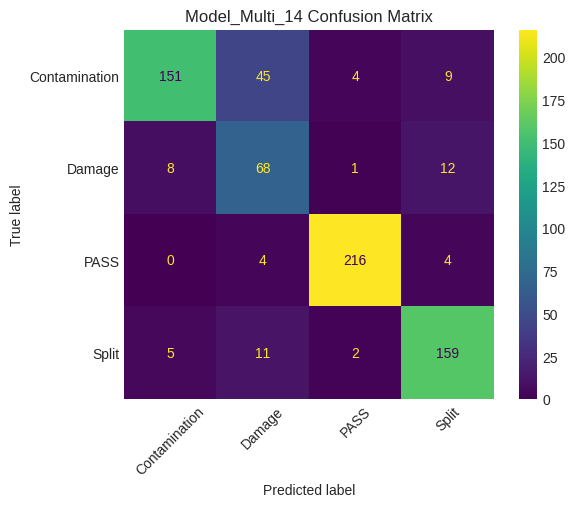

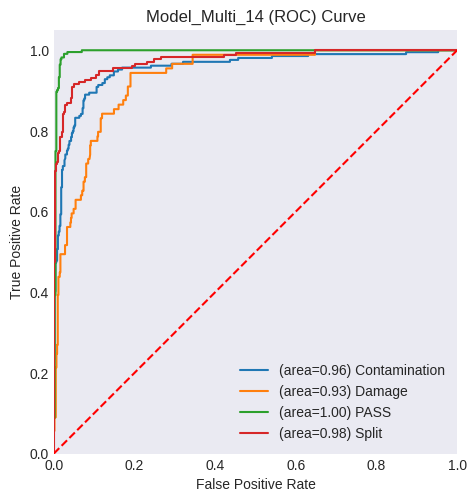

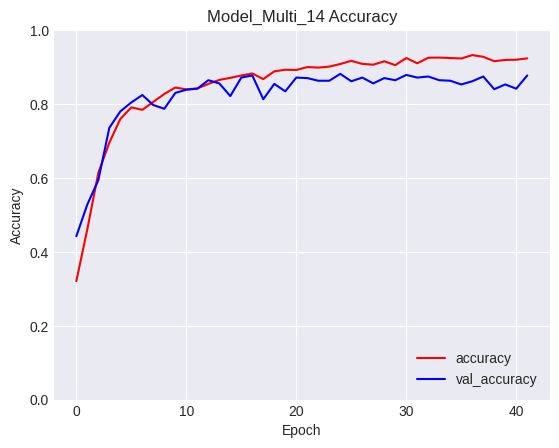

In [ ]:
report_multi_results(model_name, scale_factor, model, history, test_generator)

In [ ]:
model_results_df

Model  Scale Factor  Train Accuracy  Val Accuracy  Test Accuracy
0    Model_Multi_0          0.35        1.000000      0.845494       0.844063
1    Model_Multi_1          0.35        0.588668      0.583691       0.565093
2    Model_Multi_2          0.35        0.415314      0.536481       0.517883
3    Model_Multi_3          0.35        0.821133      0.816881       0.812589
4    Model_Multi_4          0.35        0.125000      0.336195       0.329041
5    Model_Multi_5          0.35        0.262787      0.320458       0.320458
6    Model_Multi_6          0.35        0.937500      0.812589       0.802575
7    Model_Multi_7          0.55        0.829403      0.859800       0.854077
8    Model_Multi_8          0.60        0.854518      0.834049       0.841202
9    Model_Multi_9          0.60        0.750000      0.802575       0.763949
10  Model_Multi_10          0.60        0.504747      0.628040       0.630901
11  Model_Multi_11          0.50        0.648086      0.698140       0.690987
12  Model_Multi_12          0.50        0.601838      0.303779       0.298999
13  Model_Multi_13          0.55        0.875000      0.854077       0.835479
14  Model_Multi_14          0.55        0.907955      0.881259       0.849785

In [ ]:
# save the model_results_df
model_results_df.to_csv('/content/drive/MyDrive/Colab Notebooks/multi_results.csv', index=False)

### ANALYSIS:
- That fixed the even epoch problem! I'm not sure why. The model seems to be training properly now. Best results yet, much improved in training and val.  That 'bug' was definately affecting the training.

---
### Model Multi 15
Changes:
- Changed scale_factor to 0.35
- Changed early stop to 'val_categorical_accuracy'

In [ ]:
model_name = 'Model_Multi_15'
num_epochs = 100
original_width = 1024
original_height = 943
scale_factor = 0.35
target_size = (int(original_height*scale_factor), int(original_width*scale_factor))

# Instantiate an ImageDataGenerator for the training set with augmentations
train_datagen = ImageDataGenerator(rescale=1./65535,
                                   horizontal_flip=True,
                                   zoom_range=0.05,
                                   height_shift_range=0.05)

# Instantiate an ImageDataGenerator for the validation set without augmentations
val_datagen = ImageDataGenerator(rescale=1./65535)

# Instantiate the test generator
test_datagen = ImageDataGenerator(rescale=1./65535)

# create the train generator
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size= target_size,
        batch_size=16,
        shuffle=True,
        color_mode='grayscale',
        class_mode='categorical',
        seed=42
)

# create the validation generator
validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size= target_size,
        batch_size=16,
        shuffle=False,
        color_mode='grayscale',
        class_mode='categorical',
)

# create the test generator
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=16,
        shuffle=False,
        color_mode='grayscale',
        class_mode='categorical',
)


# Get the input shape
input_shape = (target_size[0], target_size[1], 1)

# Define the model
model = Sequential([
    Conv2D(32, (3, 3),
           activation='relu',
           input_shape=input_shape,
           padding='valid'),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='valid'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='valid'),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu', padding='valid'),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(512, activation='relu'),
    Dropout(0.2),

    Dense(512, activation='relu'),

    Dense(256, activation='relu'),
    Dense(4, activation='softmax')
])

# optimizer
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# instantiate early stopping
early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=5, restore_best_weights=True)


# Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(train_generator.classes),
                                                  y=train_generator.classes)
class_weight_dict = {i : class_weights[i] for i in range(len(class_weights))}

model.summary()

# fit the model
history = model.fit(train_generator,
                epochs=num_epochs,
                validation_data=validation_generator,
                class_weight=class_weight_dict,
                callbacks=[early_stopping]
)

Found 3281 images belonging to 4 classes.
Found 699 images belonging to 4 classes.
Found 699 images belonging to 4 classes.


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_40 (Conv2D)                   │ (None, 328, 356, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_40 (MaxPooling2D)      │ (None, 164, 178, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_41 (Conv2D)                   │ (None, 162, 176, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_41 (MaxPooling2D)      │ (None, 81, 88, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_42 (Conv2D)                   │ (None, 79, 86, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_42 (MaxPooling2D)      │ (None, 39, 43, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_43 (Conv2D)                   │ (None, 37, 41, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_43 (MaxPooling2D)      │ (None, 18, 20, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 92160)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_40 (Dense)                     │ (None, 512)                 │      47,186,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_43 (Dense)                     │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 47,969,284 (182.99 MB)

 Trainable params: 47,969,284 (182.99 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 78s 345ms/step - categorical_accuracy: 0.3478 - loss: 1.3504 - val_categorical_accuracy: 0.5479 - val_loss: 1.0283
Epoch 2/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 67s 315ms/step - categorical_accuracy: 0.5607 - loss: 1.0759 - val_categorical_accuracy: 0.7024 - val_loss: 0.8233
Epoch 3/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 67s 315ms/step - categorical_accuracy: 0.6918 - loss: 0.8351 - val_categorical_accuracy: 0.6667 - val_loss: 0.7919
Epoch 4/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 67s 316ms/step - categorical_accuracy: 0.7392 - loss: 0.7271 - val_categorical_accuracy: 0.7454 - val_loss: 0.6828
Epoch 5/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 68s 318ms/step - categorical_accuracy: 0.7869 - loss: 0.6078 - val_categorical_accuracy: 0.7396 - val_loss: 0.6600
Epoch 6/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 67s 316ms/step - categorical_accuracy: 0.7992 - loss: 0.5552 - val_categorical_accuracy: 0.7110 - val_loss: 0.7386
Epoch 7/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 67s 315ms/step - catego

In [ ]:
from tensorflow.keras.models import load_model
model_path = f'/content/drive/MyDrive/LMIS_Classification/Models{model_name}.h5'
model.save(model_path)

44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 199ms/step
  Training Accuracy: 0.875
Validation Accuracy: 0.851
      Test Accuracy: 0.841
              precision    recall  f1-score   support

           0       0.87      0.78      0.82       209
           1       0.56      0.66      0.61        89
           2       0.95      0.95      0.95       224
           3       0.84      0.86      0.85       177

    accuracy                           0.84       699
   macro avg       0.81      0.81      0.81       699
weighted avg       0.85      0.84      0.84       699



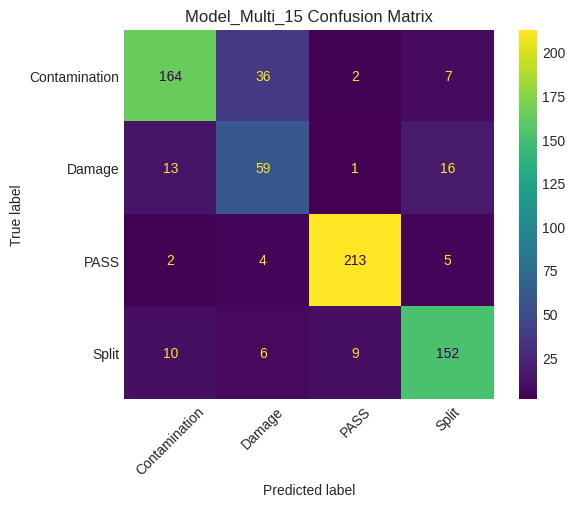

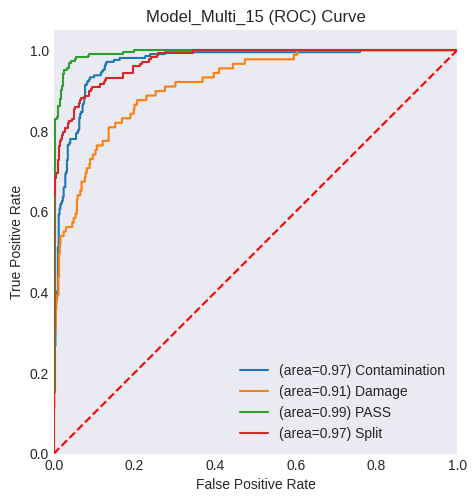

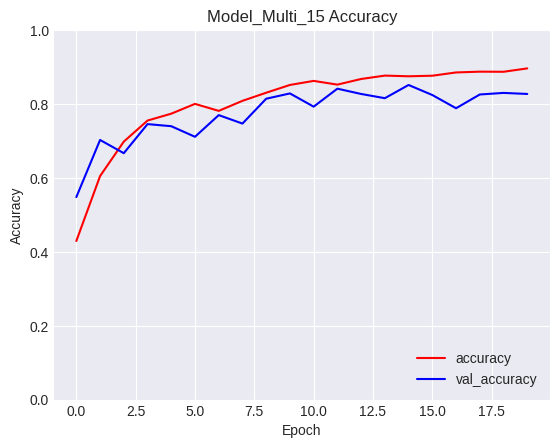

In [ ]:
report_multi_results(model_name, scale_factor, model, history, test_generator)

In [ ]:
model_results_df

Model  Scale Factor  Train Accuracy  Val Accuracy  Test Accuracy
0    Model_Multi_0          0.35        1.000000      0.845494       0.844063
1    Model_Multi_1          0.35        0.588668      0.583691       0.565093
2    Model_Multi_2          0.35        0.415314      0.536481       0.517883
3    Model_Multi_3          0.35        0.821133      0.816881       0.812589
4    Model_Multi_4          0.35        0.125000      0.336195       0.329041
5    Model_Multi_5          0.35        0.262787      0.320458       0.320458
6    Model_Multi_6          0.35        0.937500      0.812589       0.802575
7    Model_Multi_7          0.55        0.829403      0.859800       0.854077
8    Model_Multi_8          0.60        0.854518      0.834049       0.841202
9    Model_Multi_9          0.60        0.750000      0.802575       0.763949
10  Model_Multi_10          0.60        0.504747      0.628040       0.630901
11  Model_Multi_11          0.50        0.648086      0.698140       0.690987
12  Model_Multi_12          0.50        0.601838      0.303779       0.298999
13  Model_Multi_13          0.55        0.875000      0.854077       0.835479
14  Model_Multi_14          0.55        0.907955      0.881259       0.849785
15  Model_Multi_15          0.35        0.874733      0.851216       0.841202

In [ ]:
# save the model_results_df
model_results_df.to_csv('/content/drive/MyDrive/Colab Notebooks/multi_results.csv', index=False)

### ANALYSIS:
- Similar results to scale=0.55 for a lot less compute

---
### Model Multi 16
Changes:
- Changed batch size to 32

In [ ]:
model_name = 'Model_Multi_16'
num_epochs = 100
original_width = 1024
original_height = 943
scale_factor = 0.35
target_size = (int(original_height*scale_factor), int(original_width*scale_factor))

# Instantiate an ImageDataGenerator for the training set with augmentations
train_datagen = ImageDataGenerator(rescale=1./65535,
                                   horizontal_flip=True,
                                   zoom_range=0.05,
                                   height_shift_range=0.05)

# Instantiate an ImageDataGenerator for the validation set without augmentations
val_datagen = ImageDataGenerator(rescale=1./65535)

# Instantiate the test generator
test_datagen = ImageDataGenerator(rescale=1./65535)

# create the train generator
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size= target_size,
        batch_size=32,
        shuffle=True,
        color_mode='grayscale',
        class_mode='categorical',
        seed=42
)

# create the validation generator
validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size= target_size,
        batch_size=32,
        shuffle=False,
        color_mode='grayscale',
        class_mode='categorical',
)

# create the test generator
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=32,
        shuffle=False,
        color_mode='grayscale',
        class_mode='categorical',
)


# Get the input shape
input_shape = (target_size[0], target_size[1], 1)

# Define the model
model = Sequential([
    Conv2D(32, (3, 3),
           activation='relu',
           input_shape=input_shape,
           padding='valid'),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='valid'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='valid'),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu', padding='valid'),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(512, activation='relu'),
    Dropout(0.2),

    Dense(512, activation='relu'),

    Dense(256, activation='relu'),
    Dense(4, activation='softmax')
])

# optimizer
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# instantiate early stopping
early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=5, restore_best_weights=True)


# Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(train_generator.classes),
                                                  y=train_generator.classes)
class_weight_dict = {i : class_weights[i] for i in range(len(class_weights))}

model.summary()

# fit the model
history = model.fit(train_generator,
                epochs=num_epochs,
                validation_data=validation_generator,
                class_weight=class_weight_dict,
                callbacks=[early_stopping]
)

Found 3281 images belonging to 4 classes.
Found 699 images belonging to 4 classes.
Found 699 images belonging to 4 classes.


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_44 (Conv2D)                   │ (None, 328, 356, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_44 (MaxPooling2D)      │ (None, 164, 178, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_45 (Conv2D)                   │ (None, 162, 176, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_45 (MaxPooling2D)      │ (None, 81, 88, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_46 (Conv2D)                   │ (None, 79, 86, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_46 (MaxPooling2D)      │ (None, 39, 43, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_47 (Conv2D)                   │ (None, 37, 41, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_47 (MaxPooling2D)      │ (None, 18, 20, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 92160)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_44 (Dense)                     │ (None, 512)                 │      47,186,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_45 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_46 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_47 (Dense)                     │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 47,969,284 (182.99 MB)

 Trainable params: 47,969,284 (182.99 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 94s 768ms/step - categorical_accuracy: 0.2512 - loss: 1.3925 - val_categorical_accuracy: 0.2790 - val_loss: 1.4340
Epoch 2/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 67s 615ms/step - categorical_accuracy: 0.4178 - loss: 1.2223 - val_categorical_accuracy: 0.5751 - val_loss: 0.9670
Epoch 3/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 68s 617ms/step - categorical_accuracy: 0.5326 - loss: 1.0942 - val_categorical_accuracy: 0.5951 - val_loss: 1.0651
Epoch 4/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 67s 617ms/step - categorical_accuracy: 0.5900 - loss: 0.9894 - val_categorical_accuracy: 0.6195 - val_loss: 0.9314
Epoch 5/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 67s 612ms/step - categorical_accuracy: 0.6592 - loss: 0.8850 - val_categorical_accuracy: 0.6423 - val_loss: 0.9221
Epoch 6/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 67s 615ms/step - categorical_accuracy: 0.6790 - loss: 0.8120 - val_categorical_accuracy: 0.6595 - val_loss: 0.8600
Epoch 7/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 67s 612ms/step - catego

In [ ]:
from tensorflow.keras.models import load_model
model_path = f'/content/drive/MyDrive/LMIS_Classification/Models{model_name}.h5'
model.save(model_path)

22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 395ms/step
  Training Accuracy: 0.881
Validation Accuracy: 0.864
      Test Accuracy: 0.840
              precision    recall  f1-score   support

           0       0.83      0.82      0.83       209
           1       0.63      0.67      0.65        89
           2       0.94      0.96      0.95       224
           3       0.83      0.79      0.81       177

    accuracy                           0.84       699
   macro avg       0.81      0.81      0.81       699
weighted avg       0.84      0.84      0.84       699



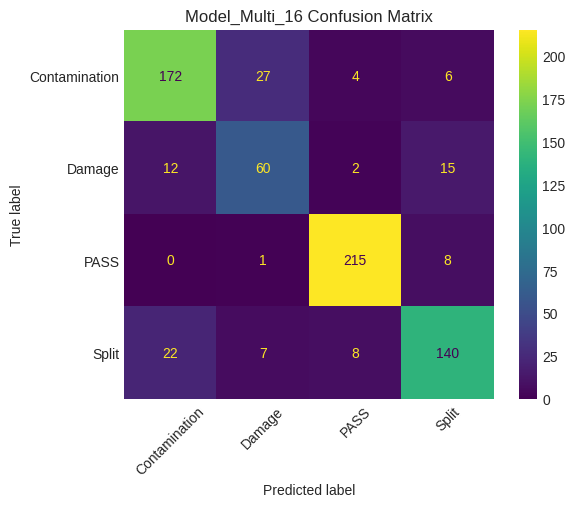

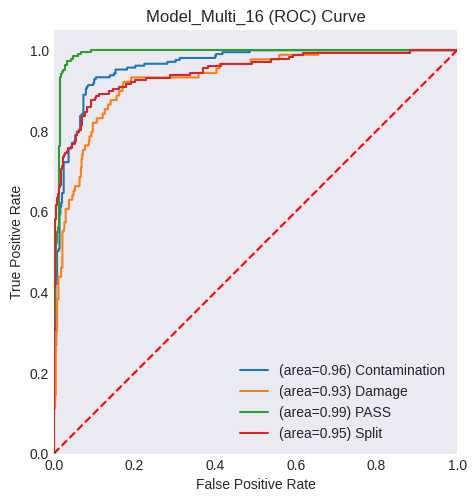

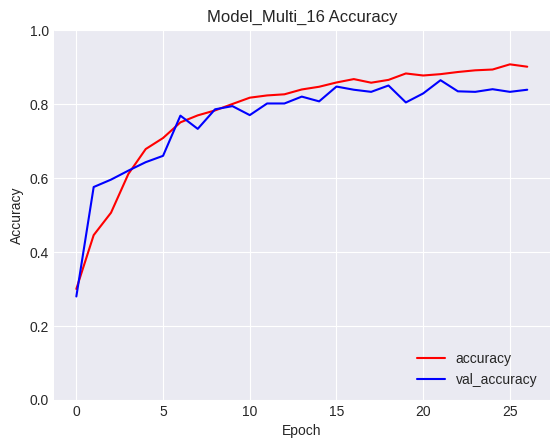

In [ ]:
report_multi_results(model_name, scale_factor, model, history, test_generator)

In [ ]:
model_results_df

Model  Scale Factor  Train Accuracy  Val Accuracy  Test Accuracy
0    Model_Multi_0          0.35        1.000000      0.845494       0.844063
1    Model_Multi_1          0.35        0.588668      0.583691       0.565093
2    Model_Multi_2          0.35        0.415314      0.536481       0.517883
3    Model_Multi_3          0.35        0.821133      0.816881       0.812589
4    Model_Multi_4          0.35        0.125000      0.336195       0.329041
5    Model_Multi_5          0.35        0.262787      0.320458       0.320458
6    Model_Multi_6          0.35        0.937500      0.812589       0.802575
7    Model_Multi_7          0.55        0.829403      0.859800       0.854077
8    Model_Multi_8          0.60        0.854518      0.834049       0.841202
9    Model_Multi_9          0.60        0.750000      0.802575       0.763949
10  Model_Multi_10          0.60        0.504747      0.628040       0.630901
11  Model_Multi_11          0.50        0.648086      0.698140       0.690987
12  Model_Multi_12          0.50        0.601838      0.303779       0.298999
13  Model_Multi_13          0.55        0.875000      0.854077       0.835479
14  Model_Multi_14          0.55        0.907955      0.881259       0.849785
15  Model_Multi_15          0.35        0.874733      0.851216       0.841202
16  Model_Multi_16          0.35        0.880524      0.864092       0.839771

In [ ]:
# save the model_results_df
model_results_df.to_csv('/content/drive/MyDrive/Colab Notebooks/multi_results.csv', index=False)

### ANALYSIS:
- Similar results in the test set, small improvement in Train and Val

---
### Model Multi 17
Changes:
- scale_factor = 0.6

In [ ]:
model_name = 'Model_Multi_17'
num_epochs = 100
original_width = 1024
original_height = 943
scale_factor = 0.6
target_size = (int(original_height*scale_factor), int(original_width*scale_factor))

# Instantiate an ImageDataGenerator for the training set with augmentations
train_datagen = ImageDataGenerator(rescale=1./65535,
                                   horizontal_flip=True,
                                   zoom_range=0.05,
                                   height_shift_range=0.05)

# Instantiate an ImageDataGenerator for the validation set without augmentations
val_datagen = ImageDataGenerator(rescale=1./65535)

# Instantiate the test generator
test_datagen = ImageDataGenerator(rescale=1./65535)

# create the train generator
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size= target_size,
        batch_size=32,
        shuffle=True,
        color_mode='grayscale',
        class_mode='categorical',
        seed=42
)

# create the validation generator
validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size= target_size,
        batch_size=32,
        shuffle=False,
        color_mode='grayscale',
        class_mode='categorical',
)

# create the test generator
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=32,
        shuffle=False,
        color_mode='grayscale',
        class_mode='categorical',
)


# Get the input shape
input_shape = (target_size[0], target_size[1], 1)

# Define the model
model = Sequential([
    Conv2D(32, (3, 3),
           activation='relu',
           input_shape=input_shape,
           padding='valid'),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='valid'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='valid'),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu', padding='valid'),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(512, activation='relu'),
    Dropout(0.2),

    Dense(512, activation='relu'),

    Dense(256, activation='relu'),
    Dense(4, activation='softmax')
])

# optimizer
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# instantiate early stopping
early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=5, restore_best_weights=True)


# Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(train_generator.classes),
                                                  y=train_generator.classes)
class_weight_dict = {i : class_weights[i] for i in range(len(class_weights))}

model.summary()

# fit the model
history = model.fit(train_generator,
                epochs=num_epochs,
                validation_data=validation_generator,
                class_weight=class_weight_dict,
                callbacks=[early_stopping]
)

Found 3281 images belonging to 4 classes.
Found 699 images belonging to 4 classes.
Found 699 images belonging to 4 classes.


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_48 (Conv2D)                   │ (None, 563, 612, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_48 (MaxPooling2D)      │ (None, 281, 306, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_49 (Conv2D)                   │ (None, 279, 304, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_49 (MaxPooling2D)      │ (None, 139, 152, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_50 (Conv2D)                   │ (None, 137, 150, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_50 (MaxPooling2D)      │ (None, 68, 75, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_51 (Conv2D)                   │ (None, 66, 73, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_51 (MaxPooling2D)      │ (None, 33, 36, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_12 (Flatten)                 │ (None, 304128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_48 (Dense)                     │ (None, 512)                 │     155,714,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_49 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_50 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,496,900 (596.99 MB)

 Trainable params: 156,496,900 (596.99 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - categorical_accuracy: 0.2895 - loss: 1.5944 - val_categorical_accuracy: 0.3820 - val_loss: 1.3169
Epoch 2/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - categorical_accuracy: 0.4035 - loss: 1.2590 - val_categorical_accuracy: 0.4106 - val_loss: 1.2196
Epoch 3/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 118s 1s/step - categorical_accuracy: 0.4791 - loss: 1.1446 - val_categorical_accuracy: 0.5894 - val_loss: 0.9943
Epoch 4/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - categorical_accuracy: 0.5138 - loss: 1.1045 - val_categorical_accuracy: 0.5808 - val_loss: 0.9653
Epoch 5/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - categorical_accuracy: 0.6139 - loss: 0.9493 - val_categorical_accuracy: 0.6595 - val_loss: 0.8643
Epoch 6/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 118s 1s/step - categorical_accuracy: 0.6472 - loss: 0.8901 - val_categorical_accuracy: 0.7554 - val_loss: 0.7815
Epoch 7/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - categorical_accuracy

In [ ]:
from tensorflow.keras.models import load_model
model_path = f'/content/drive/MyDrive/LMIS_Classification/Models{model_name}.h5'
model.save(model_path)

22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 461ms/step
  Training Accuracy: 0.874
Validation Accuracy: 0.866
      Test Accuracy: 0.866
              precision    recall  f1-score   support

           0       0.92      0.78      0.84       209
           1       0.60      0.75      0.67        89
           2       0.94      0.98      0.96       224
           3       0.88      0.88      0.88       177

    accuracy                           0.87       699
   macro avg       0.83      0.85      0.84       699
weighted avg       0.88      0.87      0.87       699



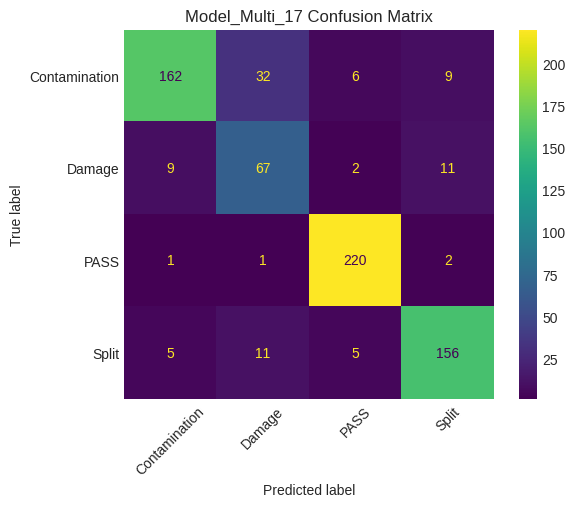

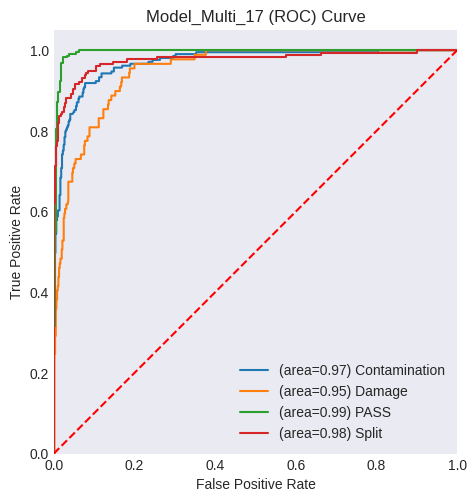

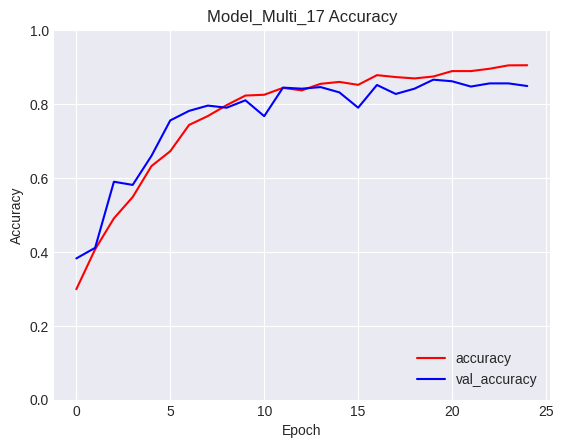

In [ ]:
report_multi_results(model_name, scale_factor, model, history, test_generator)

In [ ]:
model_results_df

Model  Scale Factor  Train Accuracy  Val Accuracy  Test Accuracy
0    Model_Multi_0          0.35        1.000000      0.845494       0.844063
1    Model_Multi_1          0.35        0.588668      0.583691       0.565093
2    Model_Multi_2          0.35        0.415314      0.536481       0.517883
3    Model_Multi_3          0.35        0.821133      0.816881       0.812589
4    Model_Multi_4          0.35        0.125000      0.336195       0.329041
5    Model_Multi_5          0.35        0.262787      0.320458       0.320458
6    Model_Multi_6          0.35        0.937500      0.812589       0.802575
7    Model_Multi_7          0.55        0.829403      0.859800       0.854077
8    Model_Multi_8          0.60        0.854518      0.834049       0.841202
9    Model_Multi_9          0.60        0.750000      0.802575       0.763949
10  Model_Multi_10          0.60        0.504747      0.628040       0.630901
11  Model_Multi_11          0.50        0.648086      0.698140       0.690987
12  Model_Multi_12          0.50        0.601838      0.303779       0.298999
13  Model_Multi_13          0.55        0.875000      0.854077       0.835479
14  Model_Multi_14          0.55        0.907955      0.881259       0.849785
15  Model_Multi_15          0.35        0.874733      0.851216       0.841202
16  Model_Multi_16          0.35        0.880524      0.864092       0.839771
17  Model_Multi_17          0.60        0.874124      0.865522       0.865522

In [ ]:
# save the model_results_df
model_results_df.to_csv('/content/drive/MyDrive/Colab Notebooks/multi_results.csv', index=False)

### ANALYSIS:
- More expensive in training compute, but 2.5% improvement in test accuracy
- Great AUC for PASS

---
### Model Multi 18
Changes:
- scale_factor = 0.6
- added Dense and Dropout layer

In [ ]:
model_name = 'Model_Multi_18'
num_epochs = 100
original_width = 1024
original_height = 943
scale_factor = 0.6
target_size = (int(original_height*scale_factor), int(original_width*scale_factor))

# Instantiate an ImageDataGenerator for the training set with augmentations
train_datagen = ImageDataGenerator(rescale=1./65535,
                                   horizontal_flip=True,
                                   zoom_range=0.05,
                                   height_shift_range=0.05)

# Instantiate an ImageDataGenerator for the validation set without augmentations
val_datagen = ImageDataGenerator(rescale=1./65535)

# Instantiate the test generator
test_datagen = ImageDataGenerator(rescale=1./65535)

# create the train generator
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size= target_size,
        batch_size=32,
        shuffle=True,
        color_mode='grayscale',
        class_mode='categorical',
        seed=42
)

# create the validation generator
validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size= target_size,
        batch_size=32,
        shuffle=False,
        color_mode='grayscale',
        class_mode='categorical',
)

# create the test generator
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=32,
        shuffle=False,
        color_mode='grayscale',
        class_mode='categorical',
)


# Get the input shape
input_shape = (target_size[0], target_size[1], 1)

# Define the model
model = Sequential([
    Conv2D(32, (3, 3),
           activation='relu',
           input_shape=input_shape,
           padding='valid'),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='valid'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='valid'),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu', padding='valid'),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(512, activation='relu'),
    Dropout(0.2),

    Dense(512, activation='relu'),
    Dropout(0.2),

    Dense(256, activation='relu'),

    Dense(256, activation='relu'),
    Dense(4, activation='softmax')
])

# optimizer
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# instantiate early stopping
early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=5, restore_best_weights=True)


# Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(train_generator.classes),
                                                  y=train_generator.classes)
class_weight_dict = {i : class_weights[i] for i in range(len(class_weights))}

model.summary()

Found 3281 images belonging to 4 classes.
Found 699 images belonging to 4 classes.
Found 699 images belonging to 4 classes.


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_52 (Conv2D)                   │ (None, 563, 612, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_52 (MaxPooling2D)      │ (None, 281, 306, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_53 (Conv2D)                   │ (None, 279, 304, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_53 (MaxPooling2D)      │ (None, 139, 152, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_54 (Conv2D)                   │ (None, 137, 150, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_54 (MaxPooling2D)      │ (None, 68, 75, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_55 (Conv2D)                   │ (None, 66, 73, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_55 (MaxPooling2D)      │ (None, 33, 36, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_13 (Flatten)                 │ (None, 304128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_52 (Dense)                     │ (None, 512)                 │     155,714,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_53 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_54 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_55 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_56 (Dense)                     │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,562,692 (597.24 MB)

 Trainable params: 156,562,692 (597.24 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# fit the model
history = model.fit(train_generator,
                epochs=num_epochs,
                validation_data=validation_generator,
                class_weight=class_weight_dict,
                callbacks=[early_stopping]
)

Epoch 1/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - categorical_accuracy: 0.2610 - loss: 1.4578 - val_categorical_accuracy: 0.3963 - val_loss: 1.2821
Epoch 2/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - categorical_accuracy: 0.3928 - loss: 1.2970 - val_categorical_accuracy: 0.5207 - val_loss: 1.0474
Epoch 3/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - categorical_accuracy: 0.4809 - loss: 1.1505 - val_categorical_accuracy: 0.4778 - val_loss: 1.1162
Epoch 4/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - categorical_accuracy: 0.5481 - loss: 1.0479 - val_categorical_accuracy: 0.5823 - val_loss: 1.0330
Epoch 5/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - categorical_accuracy: 0.5787 - loss: 1.0168 - val_categorical_accuracy: 0.6609 - val_loss: 0.8071
Epoch 6/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - categorical_accuracy: 0.6198 - loss: 0.9247 - val_categorical_accuracy: 0.5293 - val_loss: 1.0919
Epoch 7/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - categorical_accuracy

In [ ]:
from tensorflow.keras.models import load_model
model_path = f'/content/drive/MyDrive/LMIS_Classification/Models{model_name}.h5'
model.save(model_path)

22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 481ms/step
  Training Accuracy: 0.902
Validation Accuracy: 0.884
      Test Accuracy: 0.861
              precision    recall  f1-score   support

           0       0.89      0.77      0.83       209
           1       0.65      0.69      0.67        89
           2       0.96      0.99      0.97       224
           3       0.82      0.90      0.86       177

    accuracy                           0.86       699
   macro avg       0.83      0.84      0.83       699
weighted avg       0.86      0.86      0.86       699



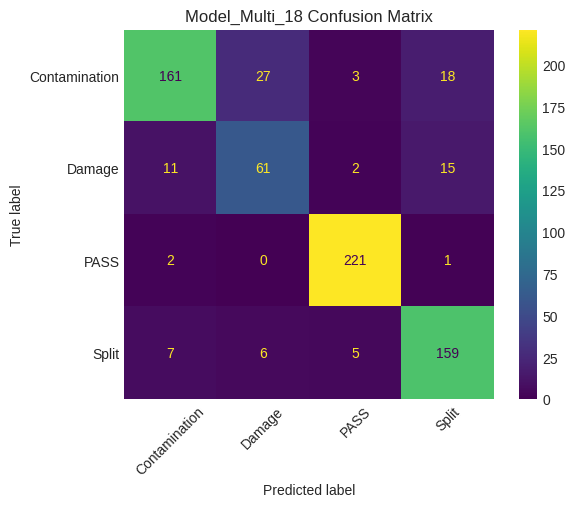

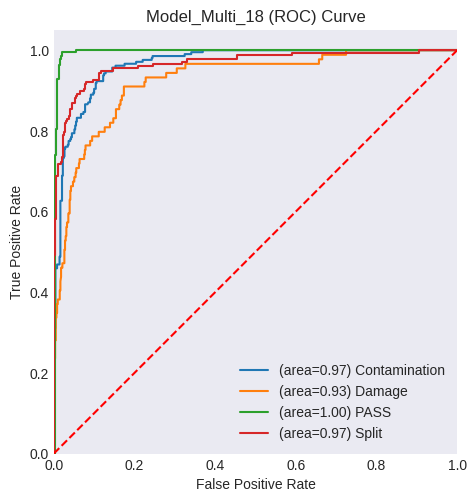

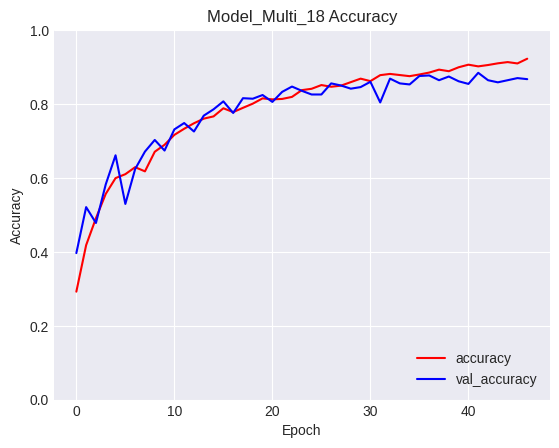

In [ ]:
report_multi_results(model_name, scale_factor, model, history, test_generator)

In [ ]:
model_results_df

Model  Scale Factor  Train Accuracy  Val Accuracy  Test Accuracy
0    Model_Multi_0          0.35        1.000000      0.845494       0.844063
1    Model_Multi_1          0.35        0.588668      0.583691       0.565093
2    Model_Multi_2          0.35        0.415314      0.536481       0.517883
3    Model_Multi_3          0.35        0.821133      0.816881       0.812589
4    Model_Multi_4          0.35        0.125000      0.336195       0.329041
5    Model_Multi_5          0.35        0.262787      0.320458       0.320458
6    Model_Multi_6          0.35        0.937500      0.812589       0.802575
7    Model_Multi_7          0.55        0.829403      0.859800       0.854077
8    Model_Multi_8          0.60        0.854518      0.834049       0.841202
9    Model_Multi_9          0.60        0.750000      0.802575       0.763949
10  Model_Multi_10          0.60        0.504747      0.628040       0.630901
11  Model_Multi_11          0.50        0.648086      0.698140       0.690987
12  Model_Multi_12          0.50        0.601838      0.303779       0.298999
13  Model_Multi_13          0.55        0.875000      0.854077       0.835479
14  Model_Multi_14          0.55        0.907955      0.881259       0.849785
15  Model_Multi_15          0.35        0.874733      0.851216       0.841202
16  Model_Multi_16          0.35        0.880524      0.864092       0.839771
17  Model_Multi_17          0.60        0.874124      0.865522       0.865522
18  Model_Multi_18          0.60        0.901554      0.884120       0.861230

In [ ]:
# save the model_results_df
model_results_df.to_csv('/content/drive/MyDrive/Colab Notebooks/multi_results.csv', index=False)

### ANALYSIS:
- Improvement in Train and Val, about the same in Test.
- Same compute burden of the dense layer as before since we added dropout.
- AUC looks great for PASS!

---
### Model Multi 19
Changes:
- During the development of a classification executable, I ran a large unseen data set outside of this notebook and got a lot of misclassification for PASS class images.  
    - added brightness data augmentation thinking that the cause might be due to differing avg brightness trends in the unseen data
    - increased the sample size for PASS class by labeling an additional 1012 images from the misclassified set

In [ ]:
model_name = 'Model_Multi_19'
num_epochs = 100
original_width = 1024
original_height = 943
scale_factor = 0.6
target_size = (int(original_height*scale_factor), int(original_width*scale_factor))

# Instantiate an ImageDataGenerator for the training set with augmentations
train_datagen = ImageDataGenerator(rescale=1./65535,
                                   horizontal_flip=True,
                                   zoom_range=0.05,
                                   height_shift_range=0.05,
                                   brightness_range=[0.8, 1.2]
)

# Instantiate an ImageDataGenerator for the validation set without augmentations
val_datagen = ImageDataGenerator(rescale=1./65535)

# Instantiate the test generator
test_datagen = ImageDataGenerator(rescale=1./65535)

# create the train generator
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size= target_size,
        batch_size=32,
        shuffle=True,
        color_mode='grayscale',
        class_mode='categorical',
        seed=42
)

# create the validation generator
validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size= target_size,
        batch_size=32,
        shuffle=False,
        color_mode='grayscale',
        class_mode='categorical',
)

# create the test generator
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=32,
        shuffle=False,
        color_mode='grayscale',
        class_mode='categorical',
)


# Get the input shape
input_shape = (target_size[0], target_size[1], 1)

# Define the model
model = Sequential([
    Conv2D(32, (3, 3),
           activation='relu',
           input_shape=input_shape,
           padding='valid'),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='valid'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='valid'),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu', padding='valid'),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(512, activation='relu'),
    Dropout(0.2),

    Dense(512, activation='relu'),
    Dropout(0.2),

    Dense(256, activation='relu'),

    Dense(256, activation='relu'),
    Dense(4, activation='softmax')
])

# optimizer
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# instantiate early stopping
early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=5, restore_best_weights=True)


# Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(train_generator.classes),
                                                  y=train_generator.classes)
class_weight_dict = {i : class_weights[i] for i in range(len(class_weights))}

model.summary()

Found 3989 images belonging to 4 classes.
Found 851 images belonging to 4 classes.
Found 851 images belonging to 4 classes.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 563, 612, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 281, 306, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 279, 304, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 139, 152, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 137, 150, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 68, 75, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 66, 73, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 33, 36, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 304128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 512)                 │     155,714,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,562,692 (597.24 MB)

 Trainable params: 156,562,692 (597.24 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# fit the model
history = model.fit(train_generator,
                epochs=num_epochs,
                validation_data=validation_generator,
                class_weight=class_weight_dict,
                callbacks=[early_stopping]
)

Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - categorical_accuracy: 0.4351 - loss: 1.3034 - val_categorical_accuracy: 0.5511 - val_loss: 1.1330
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 154s 1s/step - categorical_accuracy: 0.5463 - loss: 1.1155 - val_categorical_accuracy: 0.6075 - val_loss: 1.0056
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - categorical_accuracy: 0.5893 - loss: 1.0321 - val_categorical_accuracy: 0.4830 - val_loss: 1.3290
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - categorical_accuracy: 0.6299 - loss: 0.9850 - val_categorical_accuracy: 0.4642 - val_loss: 1.1138
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 154s 1s/step - categorical_accuracy: 0.6117 - loss: 1.0037 - val_categorical_accuracy: 0.6675 - val_loss: 0.8919
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - categorical_accuracy: 0.6713 - loss: 0.9214 - val_categorical_accuracy: 0.6369 - val_loss: 1.0642
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - categorical_accuracy

In [ ]:
from tensorflow.keras.models import load_model
model_path = f'/content/drive/MyDrive/LMIS_Classification/Models{model_name}.h5'
model.save(model_path)

27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 466ms/step
  Training Accuracy: 0.866
Validation Accuracy: 0.871
      Test Accuracy: 0.857
              precision    recall  f1-score   support

           0       0.91      0.77      0.83       209
           1       0.58      0.67      0.62        89
           2       0.93      0.96      0.94       376
           3       0.82      0.84      0.83       177

    accuracy                           0.86       851
   macro avg       0.81      0.81      0.81       851
weighted avg       0.86      0.86      0.86       851



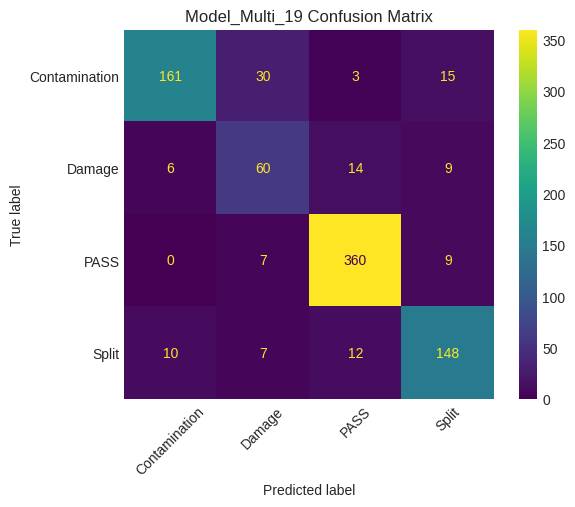

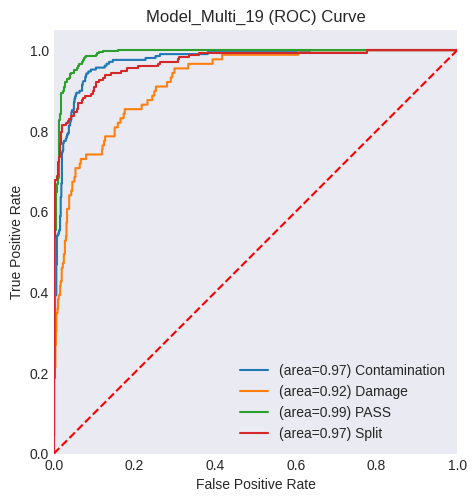

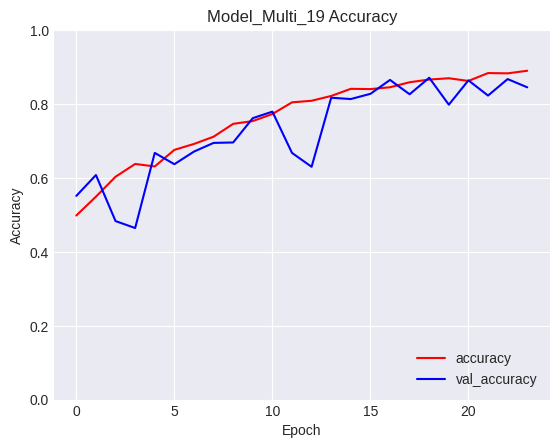

In [ ]:
report_multi_results(model_name, scale_factor, model, history, test_generator)

In [ ]:
model_results_df

Model  Scale Factor  Train Accuracy  Val Accuracy  Test Accuracy
0    Model_Multi_0          0.35        1.000000      0.845494       0.844063
1    Model_Multi_1          0.35        0.588668      0.583691       0.565093
2    Model_Multi_2          0.35        0.415314      0.536481       0.517883
3    Model_Multi_3          0.35        0.821133      0.816881       0.812589
4    Model_Multi_4          0.35        0.125000      0.336195       0.329041
5    Model_Multi_5          0.35        0.262787      0.320458       0.320458
6    Model_Multi_6          0.35        0.937500      0.812589       0.802575
7    Model_Multi_7          0.55        0.829403      0.859800       0.854077
8    Model_Multi_8          0.60        0.854518      0.834049       0.841202
9    Model_Multi_9          0.60        0.750000      0.802575       0.763949
10  Model_Multi_10          0.60        0.504747      0.628040       0.630901
11  Model_Multi_11          0.50        0.648086      0.698140       0.690987
12  Model_Multi_12          0.50        0.601838      0.303779       0.298999
13  Model_Multi_13          0.55        0.875000      0.854077       0.835479
14  Model_Multi_14          0.55        0.907955      0.881259       0.849785
15  Model_Multi_15          0.35        0.874733      0.851216       0.841202
16  Model_Multi_16          0.35        0.880524      0.864092       0.839771
17  Model_Multi_17          0.60        0.874124      0.865522       0.865522
18  Model_Multi_18          0.60        0.901554      0.884120       0.861230
19  Model_Multi_19          0.60        0.865881      0.870740       0.856639

In [ ]:
# save the model_results_df
model_results_df.to_csv('/content/drive/MyDrive/Colab Notebooks/multi_results.csv', index=False)

### ANALYSIS:
- Not quite as good as the previous model, however it performed much better on the unseen data set offline
- Going to keep the additional 1012 PASS images in the sets moving forward

---
### Model Multi 20
Changes:
- scale_factor = 0.35
- added dense layer

In [ ]:
model_name = 'Model_Multi_20'
num_epochs = 100
original_width = 1024
original_height = 943
scale_factor = 0.35
target_size = (int(original_height*scale_factor), int(original_width*scale_factor))

# Instantiate an ImageDataGenerator for the training set with augmentations
train_datagen = ImageDataGenerator(rescale=1./65535,
                                   horizontal_flip=True,
                                   zoom_range=0.05,
                                   height_shift_range=0.05,
                                   brightness_range=[0.8, 1.2]
)

# Instantiate an ImageDataGenerator for the validation set without augmentations
val_datagen = ImageDataGenerator(rescale=1./65535)

# Instantiate the test generator
test_datagen = ImageDataGenerator(rescale=1./65535)

# create the train generator
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size= target_size,
        batch_size=32,
        shuffle=True,
        color_mode='grayscale',
        class_mode='categorical',
        seed=42
)

# create the validation generator
validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size= target_size,
        batch_size=32,
        shuffle=False,
        color_mode='grayscale',
        class_mode='categorical',
)

# create the test generator
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=32,
        shuffle=False,
        color_mode='grayscale',
        class_mode='categorical',
)


# Get the input shape
input_shape = (target_size[0], target_size[1], 1)

# Define the model
padding = 'valid'
model = Sequential([
    Conv2D(32, (3, 3),
           activation='relu',
           input_shape=input_shape,
           padding=padding),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding=padding),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding=padding),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu', padding=padding),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(512, activation='relu'),
    Dropout(0.2),

    Dense(512, activation='relu'),
    Dropout(0.2),

    Dense(512, activation='relu'),
    Dropout(0.2),

    Dense(256, activation='relu'),

    Dense(256, activation='relu'),
    Dense(4, activation='softmax')
])

# optimizer
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# instantiate early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)


# Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(train_generator.classes),
                                                  y=train_generator.classes)
class_weight_dict = {i : class_weights[i] for i in range(len(class_weights))}

model.summary()

Found 3989 images belonging to 4 classes.
Found 851 images belonging to 4 classes.
Found 851 images belonging to 4 classes.


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_52 (Conv2D)                   │ (None, 328, 356, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_51 (MaxPooling2D)      │ (None, 164, 178, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_53 (Conv2D)                   │ (None, 162, 176, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_52 (MaxPooling2D)      │ (None, 81, 88, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_54 (Conv2D)                   │ (None, 79, 86, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_53 (MaxPooling2D)      │ (None, 39, 43, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_55 (Conv2D)                   │ (None, 37, 41, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_54 (MaxPooling2D)      │ (None, 18, 20, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 92160)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_80 (Dense)                     │ (None, 512)                 │      47,186,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_39 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_81 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_40 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_82 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_41 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_83 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_84 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_85 (Dense)                     │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 48,297,732 (184.24 MB)

 Trainable params: 48,297,732 (184.24 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# fit the model
history = model.fit(train_generator,
                epochs=num_epochs,
                validation_data=validation_generator,
                class_weight=class_weight_dict,
                callbacks=[early_stopping]
)

Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 106s 739ms/step - accuracy: 0.3348 - loss: 1.3561 - val_accuracy: 0.5817 - val_loss: 1.0760
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 85s 642ms/step - accuracy: 0.5775 - loss: 1.0926 - val_accuracy: 0.4642 - val_loss: 1.3099
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 88s 667ms/step - accuracy: 0.5995 - loss: 1.0386 - val_accuracy: 0.4407 - val_loss: 1.4505
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 84s 642ms/step - accuracy: 0.6104 - loss: 0.9943 - val_accuracy: 0.5687 - val_loss: 1.0227
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 85s 645ms/step - accuracy: 0.6622 - loss: 0.9411 - val_accuracy: 0.6486 - val_loss: 0.9741
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 85s 645ms/step - accuracy: 0.6506 - loss: 0.9482 - val_accuracy: 0.7203 - val_loss: 0.7315
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 84s 642ms/step - accuracy: 0.6739 - loss: 0.8929 - val_accuracy: 0.7368 - val_loss: 0.7302
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 87s 666ms/step - accuracy: 0.7156 

In [ ]:
from tensorflow.keras.models import load_model
model_path = f'/content/drive/MyDrive/LMIS_Classification/Models{model_name}.h5'
model.save(model_path)

27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 348ms/step
  Training Accuracy: 0.924
Validation Accuracy: 0.888
      Test Accuracy: 0.875
              precision    recall  f1-score   support

           0       0.87      0.81      0.84       209
           1       0.57      0.73      0.64        89
           2       0.95      0.97      0.96       376
           3       0.91      0.82      0.87       177

    accuracy                           0.88       851
   macro avg       0.83      0.83      0.83       851
weighted avg       0.88      0.88      0.88       851



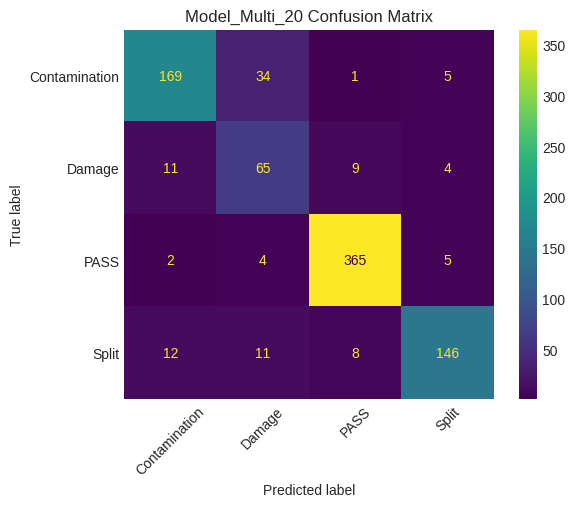

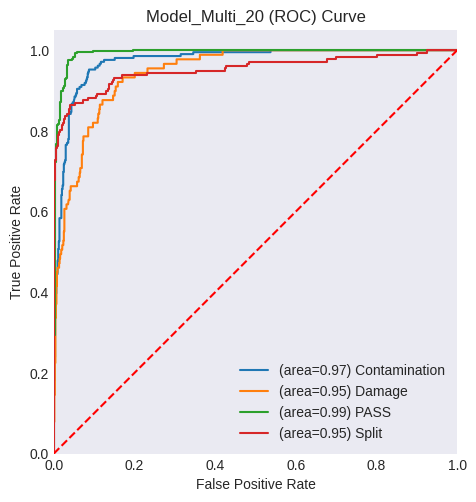

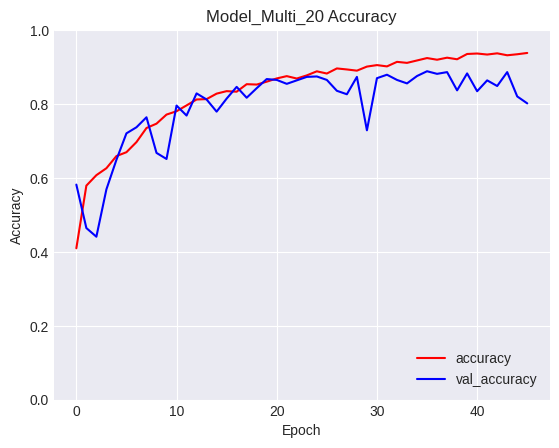

In [ ]:
report_multi_results(model_name, scale_factor, model, history, test_generator)

In [ ]:
model_results_df

Model  Scale Factor  Train Accuracy  Val Accuracy  Test Accuracy
0    Model_Multi_0          0.35        1.000000      0.845494       0.844063
1    Model_Multi_1          0.35        0.588668      0.583691       0.565093
2    Model_Multi_2          0.35        0.415314      0.536481       0.517883
3    Model_Multi_3          0.35        0.821133      0.816881       0.812589
4    Model_Multi_4          0.35        0.125000      0.336195       0.329041
5    Model_Multi_5          0.35        0.262787      0.320458       0.320458
6    Model_Multi_6          0.35        0.937500      0.812589       0.802575
7    Model_Multi_7          0.55        0.829403      0.859800       0.854077
8    Model_Multi_8          0.60        0.854518      0.834049       0.841202
9    Model_Multi_9          0.60        0.750000      0.802575       0.763949
10  Model_Multi_10          0.60        0.504747      0.628040       0.630901
11  Model_Multi_11          0.50        0.648086      0.698140       0.690987
12  Model_Multi_12          0.50        0.601838      0.303779       0.298999
13  Model_Multi_13          0.55        0.875000      0.854077       0.835479
14  Model_Multi_14          0.55        0.907955      0.881259       0.849785
15  Model_Multi_15          0.35        0.874733      0.851216       0.841202
16  Model_Multi_16          0.35        0.880524      0.864092       0.839771
17  Model_Multi_17          0.60        0.874124      0.865522       0.865522
18  Model_Multi_18          0.60        0.901554      0.884120       0.861230
19  Model_Multi_19          0.60        0.865881      0.870740       0.856639
20  Model_Multi_20          0.35        0.924041      0.888367       0.875441

In [ ]:
# save the model_results_df
model_results_df.to_csv('/content/drive/MyDrive/Colab Notebooks/multi_results.csv', index=False)

### ANALYSIS:
- 2% improvement in test acc while reducing compute cost.
- Slightly overfit

---
### Model Binary 0
Changes:
- Exploring if it would make sense to use binary pass vs fail instead of multiclass
- Baseline; same as Multi 20 architecture
- changed to sigmoid, etc for binary

In [ ]:
model_name = 'Model_Binary_0'
num_epochs = 100
original_width = 1024
original_height = 943
scale_factor = 0.35
target_size = (int(original_height*scale_factor), int(original_width*scale_factor))

# Instantiate an ImageDataGenerator for the training set with augmentations
train_datagen = ImageDataGenerator(rescale=1./65535,
                                   horizontal_flip=True,
                                   zoom_range=0.05,
                                   height_shift_range=0.05,
                                   brightness_range=[0.8, 1.2]
)

# Instantiate an ImageDataGenerator for the validation set without augmentations
val_datagen = ImageDataGenerator(rescale=1./65535)

# Instantiate the test generator
test_datagen = ImageDataGenerator(rescale=1./65535)

# create the train generator
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size= target_size,
        batch_size=32,
        shuffle=True,
        color_mode='grayscale',
        class_mode='binary',
        seed=42
)

# create the validation generator
validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size= target_size,
        batch_size=32,
        shuffle=False,
        color_mode='grayscale',
        class_mode='binary',
)

# create the test generator
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=32,
        shuffle=False,
        color_mode='grayscale',
        class_mode='binary',
)


# Get the input shape
input_shape = (target_size[0], target_size[1], 1)

# Define the model
padding = 'valid'
model = Sequential([
    Conv2D(32, (3, 3),
           activation='relu',
           input_shape=input_shape,
           padding=padding),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding=padding),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding=padding),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu', padding=padding),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(512, activation='relu'),
    Dropout(0.2),

    Dense(512, activation='relu'),
    Dropout(0.2),

    Dense(512, activation='relu'),
    Dropout(0.2),

    Dense(256, activation='relu'),

    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')
])

# optimizer
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# instantiate early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)


# Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(train_generator.classes),
                                                  y=train_generator.classes)
class_weight_dict = {i : class_weights[i] for i in range(len(class_weights))}

model.summary()

Found 3983 images belonging to 2 classes.
Found 851 images belonging to 2 classes.
Found 850 images belonging to 2 classes.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 328, 356, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 164, 178, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 162, 176, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 81, 88, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 79, 86, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 39, 43, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 37, 41, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 18, 20, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 92160)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      47,186,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 48,296,961 (184.24 MB)

 Trainable params: 48,296,961 (184.24 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# fit the model
history = model.fit(train_generator,
                epochs=num_epochs,
                validation_data=validation_generator,
                class_weight=class_weight_dict,
                callbacks=[early_stopping]
)

Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 127s 852ms/step - accuracy: 0.5837 - loss: 0.6357 - val_accuracy: 0.8202 - val_loss: 0.4511
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 85s 648ms/step - accuracy: 0.8037 - loss: 0.4389 - val_accuracy: 0.7767 - val_loss: 0.5392
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 86s 652ms/step - accuracy: 0.8018 - loss: 0.4341 - val_accuracy: 0.8437 - val_loss: 0.3923
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 84s 641ms/step - accuracy: 0.8120 - loss: 0.4089 - val_accuracy: 0.8355 - val_loss: 0.3744
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 85s 645ms/step - accuracy: 0.8152 - loss: 0.3971 - val_accuracy: 0.8414 - val_loss: 0.3720
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 86s 657ms/step - accuracy: 0.8300 - loss: 0.3601 - val_accuracy: 0.8566 - val_loss: 0.3480
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 85s 645ms/step - accuracy: 0.8507 - loss: 0.3291 - val_accuracy: 0.8179 - val_loss: 0.3895
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 86s 655ms/step - accuracy: 0.8611 

In [ ]:
from tensorflow.keras.models import load_model
model_path = f'/content/drive/MyDrive/LMIS_Classification/Models{model_name}.h5'
model.save(model_path)

Found 3983 images belonging to 2 classes.
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 343ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 44s 349ms/step
  Training Accuracy: 0.969
Validation Accuracy: 0.965
      Test Accuracy: 0.961
              precision    recall  f1-score   support

           0       0.98      0.95      0.96       474
           1       0.94      0.97      0.96       376

    accuracy                           0.96       850
   macro avg       0.96      0.96      0.96       850
weighted avg       0.96      0.96      0.96       850



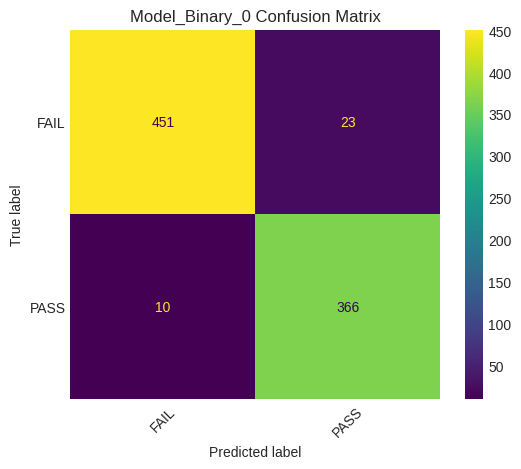

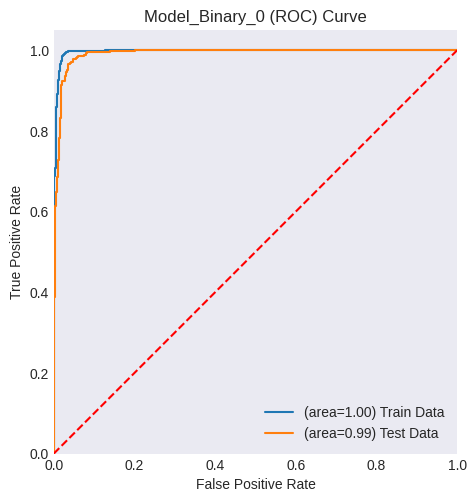

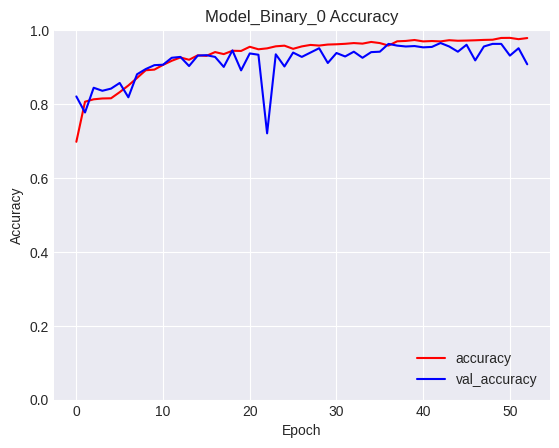

In [ ]:
# create a train generator that is not shuffled for the report
train_generator = test_datagen.flow_from_directory(
        train_dir,
        target_size= target_size,
        batch_size=32,
        shuffle=False,
        color_mode='grayscale',
        class_mode='binary',
        seed=42
)

report_binary_results(model_name, scale_factor, model, history, train_generator, test_generator)

In [ ]:
model_results_df

Model  Scale Factor  Train Accuracy  Val Accuracy  Test Accuracy
0    Model_Multi_0          0.35        1.000000      0.845494       0.844063
1    Model_Multi_1          0.35        0.588668      0.583691       0.565093
2    Model_Multi_2          0.35        0.415314      0.536481       0.517883
3    Model_Multi_3          0.35        0.821133      0.816881       0.812589
4    Model_Multi_4          0.35        0.125000      0.336195       0.329041
5    Model_Multi_5          0.35        0.262787      0.320458       0.320458
6    Model_Multi_6          0.35        0.937500      0.812589       0.802575
7    Model_Multi_7          0.55        0.829403      0.859800       0.854077
8    Model_Multi_8          0.60        0.854518      0.834049       0.841202
9    Model_Multi_9          0.60        0.750000      0.802575       0.763949
10  Model_Multi_10          0.60        0.504747      0.628040       0.630901
11  Model_Multi_11          0.50        0.648086      0.698140       0.690987
12  Model_Multi_12          0.50        0.601838      0.303779       0.298999
13  Model_Multi_13          0.55        0.875000      0.854077       0.835479
14  Model_Multi_14          0.55        0.907955      0.881259       0.849785
15  Model_Multi_15          0.35        0.874733      0.851216       0.841202
16  Model_Multi_16          0.35        0.880524      0.864092       0.839771
17  Model_Multi_17          0.60        0.874124      0.865522       0.865522
18  Model_Multi_18          0.60        0.901554      0.884120       0.861230
19  Model_Multi_19          0.60        0.865881      0.870740       0.856639
20  Model_Multi_20          0.35        0.924041      0.888367       0.875441
21  Model_Binary_0          0.35        0.969119      0.964747       0.961176

In [ ]:
# save the model_results_df
model_results_df.to_csv('/content/drive/MyDrive/Colab Notebooks/multi_results.csv', index=False)

### ANALYSIS:
- As expected, the accuracy improved dramatically (there is a big difference between PASS and non-PASS images)
- However, the false pos rate is 4.8% (which is why we are doing this exercise), and is not great compared to the PASS false-pos rate of some of the previous models (i.e. model 14 at 1.5%)
- Since we know we can get similar or better results for PASS false pos with the multi- model, going back to iterating on that

---
### Model Multi 21
Changes:
- Added in etch class
    - Late discovery from TFS stakeholder that they want Etch class included
    - Labeled an additional 1050 Etch images and add them to the sets, randomized of course.
- Same as model 20, except 5 softmax nodes

In [ ]:
# Re-assign the directory paths to the new data sets in Colab
train_dir = '/content/Sets_with_etch/Train'
print('====Train Directory====')
get_folder_counts(train_dir)
val_dir = '/content/Sets_with_etch/Validation'
print('====Validation Directory====')
get_folder_counts(val_dir)
test_dir = '/content/Sets_with_etch/Test'
print('====Test Directory====')
get_folder_counts(test_dir)

In [ ]:
model_name = 'Model_Multi_21'
num_epochs = 100
original_width = 1024
original_height = 943
scale_factor = 0.35
target_size = (int(original_height*scale_factor), int(original_width*scale_factor))

# Instantiate an ImageDataGenerator for the training set with augmentations
train_datagen = ImageDataGenerator(rescale=1./65535,
                                   horizontal_flip=True,
                                   zoom_range=0.05,
                                   height_shift_range=0.05,
                                   brightness_range=[0.8, 1.2]
)

# Instantiate an ImageDataGenerator for the validation set without augmentations
val_datagen = ImageDataGenerator(rescale=1./65535)

# Instantiate the test generator
test_datagen = ImageDataGenerator(rescale=1./65535)

# create the train generator
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size= target_size,
        batch_size=32,
        shuffle=True,
        color_mode='grayscale',
        class_mode='categorical',
        seed=42
)

# create the validation generator
validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size= target_size,
        batch_size=32,
        shuffle=False,
        color_mode='grayscale',
        class_mode='categorical',
)

# create the test generator
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=32,
        shuffle=False,
        color_mode='grayscale',
        class_mode='categorical',
)


# Get the input shape
input_shape = (target_size[0], target_size[1], 1)

# Define the model
padding = 'valid'
model = Sequential([
    Conv2D(32, (3, 3),
           activation='relu',
           input_shape=input_shape,
           padding=padding),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding=padding),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding=padding),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu', padding=padding),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(512, activation='relu'),
    Dropout(0.2),

    Dense(512, activation='relu'),
    Dropout(0.2),

    Dense(512, activation='relu'),
    Dropout(0.2),

    Dense(256, activation='relu'),

    Dense(256, activation='relu'),
    Dense(5, activation='softmax')
])

# optimizer
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# instantiate early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)


# Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(train_generator.classes),
                                                  y=train_generator.classes)
class_weight_dict = {i : class_weights[i] for i in range(len(class_weights))}

model.summary()

Found 4919 images belonging to 5 classes.
Found 1050 images belonging to 5 classes.
Found 1050 images belonging to 5 classes.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 328, 356, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 164, 178, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 162, 176, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 81, 88, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 79, 86, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 39, 43, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 37, 41, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 18, 20, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 92160)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │      47,186,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 48,297,989 (184.24 MB)

 Trainable params: 48,297,989 (184.24 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# fit the model
history = model.fit(train_generator,
                epochs=num_epochs,
                validation_data=validation_generator,
                class_weight=class_weight_dict,
                callbacks=[early_stopping]
)

Epoch 1/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 138s 776ms/step - accuracy: 0.2758 - loss: 1.5696 - val_accuracy: 0.4743 - val_loss: 1.2734
Epoch 2/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 104s 650ms/step - accuracy: 0.4757 - loss: 1.2955 - val_accuracy: 0.4924 - val_loss: 1.2131
Epoch 3/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 103s 640ms/step - accuracy: 0.5225 - loss: 1.2180 - val_accuracy: 0.4571 - val_loss: 1.4413
Epoch 4/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 103s 644ms/step - accuracy: 0.5510 - loss: 1.1558 - val_accuracy: 0.5352 - val_loss: 1.1926
Epoch 5/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 103s 642ms/step - accuracy: 0.6184 - loss: 1.0781 - val_accuracy: 0.4590 - val_loss: 1.4530
Epoch 6/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 103s 642ms/step - accuracy: 0.6347 - loss: 1.0261 - val_accuracy: 0.5876 - val_loss: 1.0606
Epoch 7/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 103s 642ms/step - accuracy: 0.6456 - loss: 1.0092 - val_accuracy: 0.6410 - val_loss: 0.9558
Epoch 8/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 105s 654ms/step - accuracy: 

In [ ]:
from tensorflow.keras.models import load_model
model_path = f'/content/drive/MyDrive/LMIS_Classification/Models{model_name}.h5'
model.save(model_path)

33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 385ms/step
  Training Accuracy: 0.875
Validation Accuracy: 0.869
      Test Accuracy: 0.847
              precision    recall  f1-score   support

           0       0.85      0.80      0.82       249
           1       0.52      0.72      0.61        92
           2       0.85      0.87      0.86       155
           3       0.94      0.91      0.93       376
           4       0.87      0.83      0.85       178

    accuracy                           0.85      1050
   macro avg       0.81      0.83      0.81      1050
weighted avg       0.86      0.85      0.85      1050



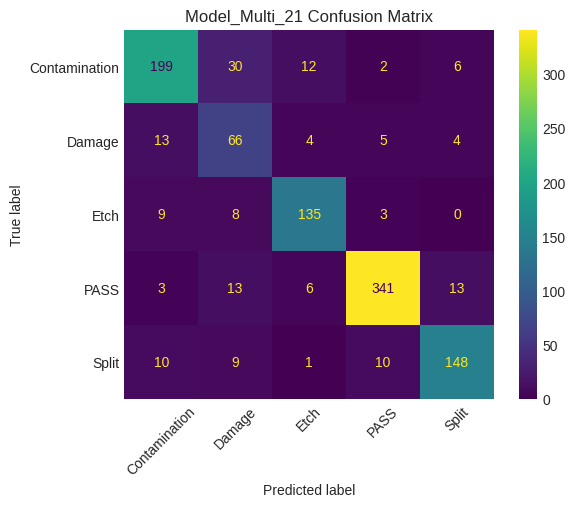

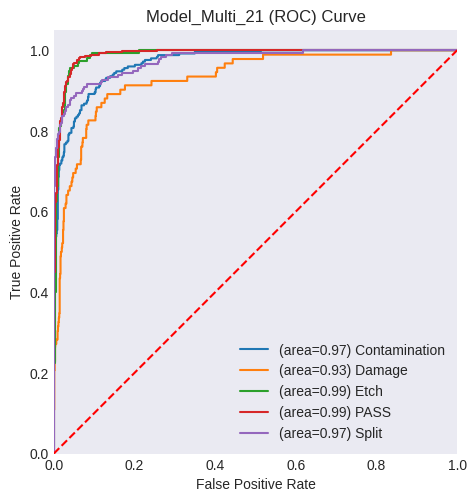

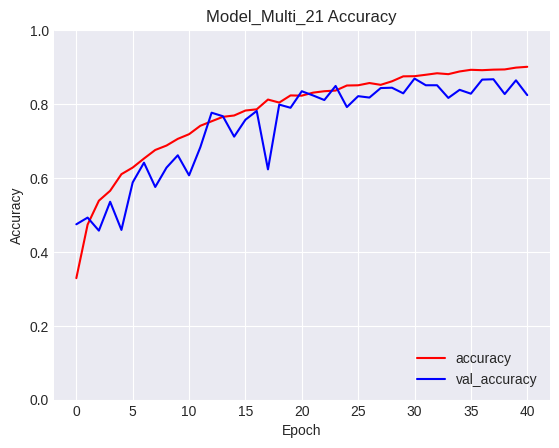

In [ ]:
report_multi_results(model_name, scale_factor, model, history, test_generator)

In [ ]:
model_results_df

Model  Scale Factor  Train Accuracy  Val Accuracy  Test Accuracy
0    Model_Multi_0          0.35        1.000000      0.845494       0.844063
1    Model_Multi_1          0.35        0.588668      0.583691       0.565093
2    Model_Multi_2          0.35        0.415314      0.536481       0.517883
3    Model_Multi_3          0.35        0.821133      0.816881       0.812589
4    Model_Multi_4          0.35        0.125000      0.336195       0.329041
5    Model_Multi_5          0.35        0.262787      0.320458       0.320458
6    Model_Multi_6          0.35        0.937500      0.812589       0.802575
7    Model_Multi_7          0.55        0.829403      0.859800       0.854077
8    Model_Multi_8          0.60        0.854518      0.834049       0.841202
9    Model_Multi_9          0.60        0.750000      0.802575       0.763949
10  Model_Multi_10          0.60        0.504747      0.628040       0.630901
11  Model_Multi_11          0.50        0.648086      0.698140       0.690987
12  Model_Multi_12          0.50        0.601838      0.303779       0.298999
13  Model_Multi_13          0.55        0.875000      0.854077       0.835479
14  Model_Multi_14          0.55        0.907955      0.881259       0.849785
15  Model_Multi_15          0.35        0.874733      0.851216       0.841202
16  Model_Multi_16          0.35        0.880524      0.864092       0.839771
17  Model_Multi_17          0.60        0.874124      0.865522       0.865522
18  Model_Multi_18          0.60        0.901554      0.884120       0.861230
19  Model_Multi_19          0.60        0.865881      0.870740       0.856639
20  Model_Multi_20          0.35        0.924041      0.888367       0.875441
21  Model_Binary_0          0.35        0.969119      0.964747       0.961176
22  Model_Multi_21          0.35        0.874975      0.868571       0.846667

In [ ]:
# save the model_results_df
model_results_df.to_csv('/content/drive/MyDrive/Colab Notebooks/multi_results.csv', index=False)

### Analysis:
- About 3% less accurate than the pre-Etch multiclass model 20
- Interesting doing very well on Etch class, AUC=0.99

---
### Model Multi 22
Changes:
- Removed brightness data augmentation, since acc went down right after we added it

In [ ]:
model_name = 'Model_Multi_22'
num_epochs = 100
original_width = 1024
original_height = 943
scale_factor = 0.35
target_size = (int(original_height*scale_factor), int(original_width*scale_factor))

# Instantiate an ImageDataGenerator for the training set with augmentations
train_datagen = ImageDataGenerator(rescale=1./65535,
                                   horizontal_flip=True,
                                   zoom_range=0.05,
                                   height_shift_range=0.05
                                  #  brightness_range=[0.8, 1.2]
)

# Instantiate an ImageDataGenerator for the validation set without augmentations
val_datagen = ImageDataGenerator(rescale=1./65535)

# Instantiate the test generator
test_datagen = ImageDataGenerator(rescale=1./65535)

# create the train generator
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size= target_size,
        batch_size=32,
        shuffle=True,
        color_mode='grayscale',
        class_mode='categorical',
        seed=42
)

# create the validation generator
validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size= target_size,
        batch_size=32,
        shuffle=False,
        color_mode='grayscale',
        class_mode='categorical',
)

# create the test generator
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=32,
        shuffle=False,
        color_mode='grayscale',
        class_mode='categorical',
)


# Get the input shape
input_shape = (target_size[0], target_size[1], 1)

# Define the model
padding = 'valid'
model = Sequential([
    Conv2D(32, (3, 3),
           activation='relu',
           input_shape=input_shape,
           padding=padding),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding=padding),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding=padding),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu', padding=padding),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(512, activation='relu'),
    Dropout(0.2),

    Dense(512, activation='relu'),
    Dropout(0.2),

    Dense(512, activation='relu'),
    Dropout(0.2),

    Dense(256, activation='relu'),

    Dense(256, activation='relu'),
    Dense(5, activation='softmax')
])

# optimizer
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# instantiate early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)


# Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(train_generator.classes),
                                                  y=train_generator.classes)
class_weight_dict = {i : class_weights[i] for i in range(len(class_weights))}

model.summary()

Found 4919 images belonging to 5 classes.
Found 1050 images belonging to 5 classes.
Found 1050 images belonging to 5 classes.


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 328, 356, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 164, 178, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 162, 176, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 81, 88, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 79, 86, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 39, 43, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 37, 41, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 18, 20, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 92160)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 512)                 │      47,186,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 48,297,989 (184.24 MB)

 Trainable params: 48,297,989 (184.24 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# fit the model
history = model.fit(train_generator,
                epochs=num_epochs,
                validation_data=validation_generator,
                class_weight=class_weight_dict,
                callbacks=[early_stopping]
)

Epoch 1/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 110s 648ms/step - accuracy: 0.2431 - loss: 1.5699 - val_accuracy: 0.4467 - val_loss: 1.3564
Epoch 2/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 99s 617ms/step - accuracy: 0.4549 - loss: 1.2783 - val_accuracy: 0.4667 - val_loss: 1.3991
Epoch 3/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 99s 616ms/step - accuracy: 0.5370 - loss: 1.1966 - val_accuracy: 0.5000 - val_loss: 1.4551
Epoch 4/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 98s 613ms/step - accuracy: 0.5743 - loss: 1.1259 - val_accuracy: 0.6095 - val_loss: 1.0651
Epoch 5/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 99s 614ms/step - accuracy: 0.6398 - loss: 0.9875 - val_accuracy: 0.6286 - val_loss: 1.0254
Epoch 6/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 99s 616ms/step - accuracy: 0.6554 - loss: 0.9741 - val_accuracy: 0.6143 - val_loss: 1.0402
Epoch 7/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 99s 618ms/step - accuracy: 0.6736 - loss: 0.9223 - val_accuracy: 0.6790 - val_loss: 0.9033
Epoch 8/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 98s 612ms/step - accuracy: 0.6866 

In [ ]:
from tensorflow.keras.models import load_model
model_path = f'/content/drive/MyDrive/LMIS_Classification/Models{model_name}.h5'
model.save(model_path)

33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 396ms/step
  Training Accuracy: 0.888
Validation Accuracy: 0.881
      Test Accuracy: 0.864
              precision    recall  f1-score   support

           0       0.86      0.81      0.83       249
           1       0.61      0.73      0.66        92
           2       0.84      0.92      0.88       155
           3       0.93      0.94      0.93       376
           4       0.92      0.81      0.86       178

    accuracy                           0.86      1050
   macro avg       0.83      0.84      0.83      1050
weighted avg       0.87      0.86      0.87      1050



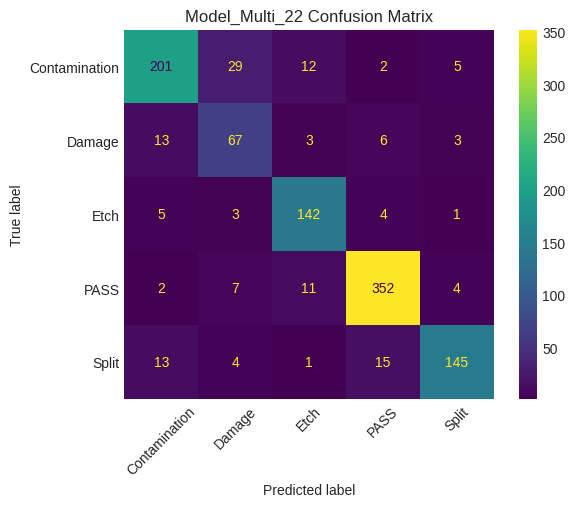

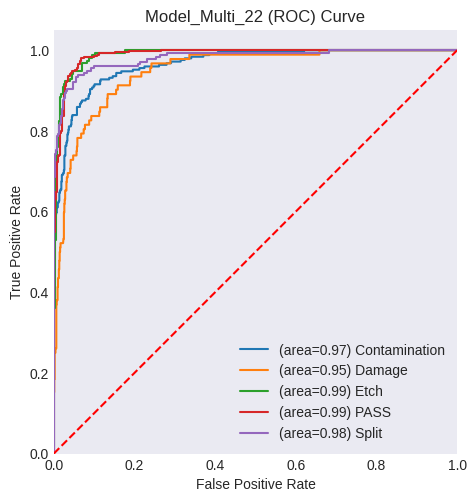

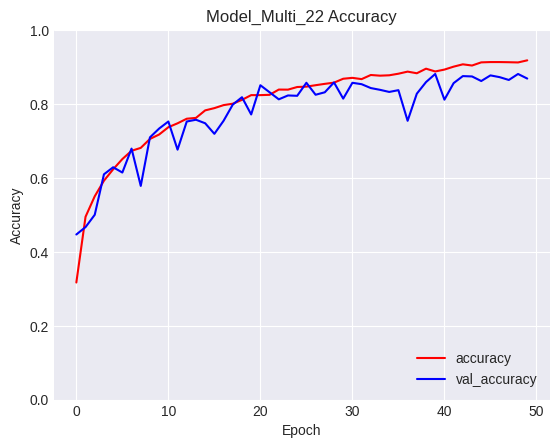

In [ ]:
report_multi_results(model_name, scale_factor, model, history, test_generator)

In [ ]:
model_results_df

Model  Scale Factor  Train Accuracy  Val Accuracy  Test Accuracy
0    Model_Multi_0          0.35        1.000000      0.845494       0.844063
1    Model_Multi_1          0.35        0.588668      0.583691       0.565093
2    Model_Multi_2          0.35        0.415314      0.536481       0.517883
3    Model_Multi_3          0.35        0.821133      0.816881       0.812589
4    Model_Multi_4          0.35        0.125000      0.336195       0.329041
5    Model_Multi_5          0.35        0.262787      0.320458       0.320458
6    Model_Multi_6          0.35        0.937500      0.812589       0.802575
7    Model_Multi_7          0.55        0.829403      0.859800       0.854077
8    Model_Multi_8          0.60        0.854518      0.834049       0.841202
9    Model_Multi_9          0.60        0.750000      0.802575       0.763949
10  Model_Multi_10          0.60        0.504747      0.628040       0.630901
11  Model_Multi_11          0.50        0.648086      0.698140       0.690987
12  Model_Multi_12          0.50        0.601838      0.303779       0.298999
13  Model_Multi_13          0.55        0.875000      0.854077       0.835479
14  Model_Multi_14          0.55        0.907955      0.881259       0.849785
15  Model_Multi_15          0.35        0.874733      0.851216       0.841202
16  Model_Multi_16          0.35        0.880524      0.864092       0.839771
17  Model_Multi_17          0.60        0.874124      0.865522       0.865522
18  Model_Multi_18          0.60        0.901554      0.884120       0.861230
19  Model_Multi_19          0.60        0.865881      0.870740       0.856639
20  Model_Multi_20          0.35        0.924041      0.888367       0.875441
21  Model_Binary_0          0.35        0.969119      0.964747       0.961176
22  Model_Multi_21          0.35        0.874975      0.868571       0.846667
23  Model_Multi_22          0.35        0.887782      0.880952       0.863810

In [ ]:
# save the model_results_df
model_results_df.to_csv('/content/drive/MyDrive/Colab Notebooks/multi_results.csv', index=False)

### ANALYSIS:
- Improvement ~1% in accuracy accross Train, Val, Test, but...
- PASS false pos is 4% which is higher than model 21 at 3%.

---
### Model Multi 23
Changes:
- Changed optimizer to RMSprop

In [ ]:
model_name = 'Model_Multi_23'
num_epochs = 100
original_width = 1024
original_height = 943
scale_factor = 0.35
target_size = (int(original_height*scale_factor), int(original_width*scale_factor))

# Instantiate an ImageDataGenerator for the training set with augmentations
train_datagen = ImageDataGenerator(rescale=1./65535,
                                   horizontal_flip=True,
                                   zoom_range=0.05,
                                   height_shift_range=0.05
                                  #  brightness_range=[0.8, 1.2]
)

# Instantiate an ImageDataGenerator for the validation set without augmentations
val_datagen = ImageDataGenerator(rescale=1./65535)

# Instantiate the test generator
test_datagen = ImageDataGenerator(rescale=1./65535)

# create the train generator
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size= target_size,
        batch_size=32,
        shuffle=True,
        color_mode='grayscale',
        class_mode='categorical',
        seed=42
)

# create the validation generator
validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size= target_size,
        batch_size=32,
        shuffle=False,
        color_mode='grayscale',
        class_mode='categorical',
)

# create the test generator
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=32,
        shuffle=False,
        color_mode='grayscale',
        class_mode='categorical',
)


# Get the input shape
input_shape = (target_size[0], target_size[1], 1)

# Define the model
padding = 'valid'
model = Sequential([
    Conv2D(32, (3, 3),
           activation='relu',
           input_shape=input_shape,
           padding=padding),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding=padding),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding=padding),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu', padding=padding),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(512, activation='relu'),
    Dropout(0.2),

    Dense(512, activation='relu'),
    Dropout(0.2),

    Dense(512, activation='relu'),
    Dropout(0.2),

    Dense(256, activation='relu'),

    Dense(256, activation='relu'),
    Dense(5, activation='softmax')
])

# optimizer
from tensorflow.keras.optimizers import RMSprop
optimizer = RMSprop(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# instantiate early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)


# Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(train_generator.classes),
                                                  y=train_generator.classes)
class_weight_dict = {i : class_weights[i] for i in range(len(class_weights))}

model.summary()

Found 4919 images belonging to 5 classes.
Found 1050 images belonging to 5 classes.
Found 1050 images belonging to 5 classes.


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 328, 356, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 164, 178, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 162, 176, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 81, 88, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 79, 86, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 39, 43, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 37, 41, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 18, 20, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 92160)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 512)                 │      47,186,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 48,297,989 (184.24 MB)

 Trainable params: 48,297,989 (184.24 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# fit the model
history = model.fit(train_generator,
                epochs=num_epochs,
                validation_data=validation_generator,
                class_weight=class_weight_dict,
                callbacks=[early_stopping]
)

Epoch 1/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 110s 654ms/step - accuracy: 0.2260 - loss: 1.6127 - val_accuracy: 0.3505 - val_loss: 1.4478
Epoch 2/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 101s 627ms/step - accuracy: 0.2825 - loss: 1.4928 - val_accuracy: 0.4190 - val_loss: 1.4497
Epoch 3/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 102s 637ms/step - accuracy: 0.4320 - loss: 1.3571 - val_accuracy: 0.4543 - val_loss: 1.3763
Epoch 4/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 102s 636ms/step - accuracy: 0.5098 - loss: 1.2250 - val_accuracy: 0.4057 - val_loss: 1.5461
Epoch 5/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 102s 637ms/step - accuracy: 0.5134 - loss: 1.2089 - val_accuracy: 0.4133 - val_loss: 1.6022
Epoch 6/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 102s 637ms/step - accuracy: 0.5460 - loss: 1.1404 - val_accuracy: 0.4914 - val_loss: 1.5007
Epoch 7/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 101s 631ms/step - accuracy: 0.5888 - loss: 1.0907 - val_accuracy: 0.4467 - val_loss: 1.5931
Epoch 8/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 102s 637ms/step - accuracy: 

In [ ]:
from tensorflow.keras.models import load_model
model_path = f'/content/drive/MyDrive/LMIS_Classification/Models{model_name}.h5'
model.save(model_path)

33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 377ms/step
  Training Accuracy: 0.876
Validation Accuracy: 0.875
      Test Accuracy: 0.855
              precision    recall  f1-score   support

           0       0.88      0.78      0.82       249
           1       0.59      0.70      0.64        92
           2       0.83      0.91      0.87       155
           3       0.94      0.92      0.93       376
           4       0.84      0.87      0.85       178

    accuracy                           0.86      1050
   macro avg       0.81      0.83      0.82      1050
weighted avg       0.86      0.86      0.86      1050



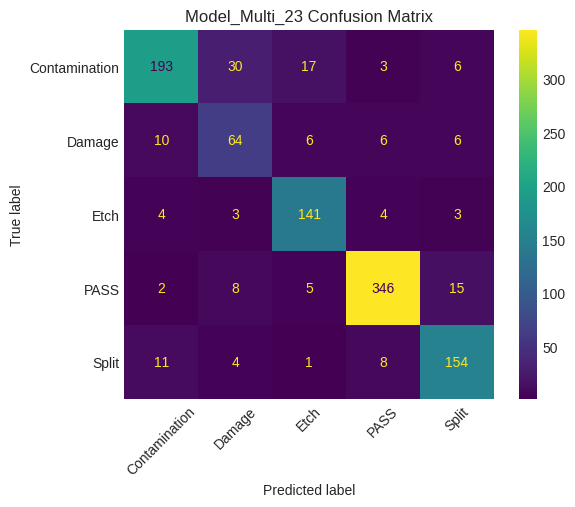

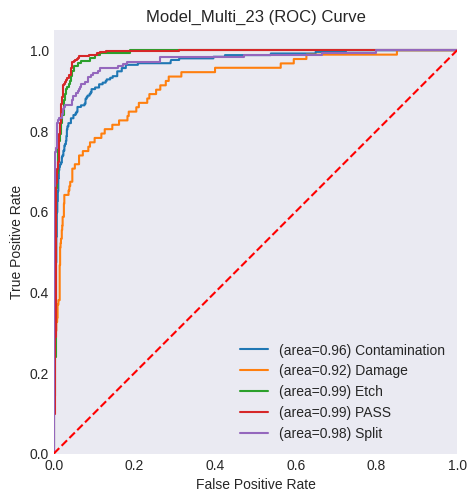

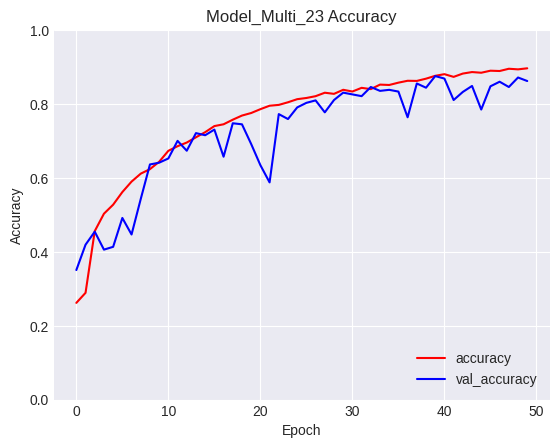

In [ ]:
report_multi_results(model_name, scale_factor, model, history, test_generator)

In [ ]:
model_results_df

Model  Scale Factor  Train Accuracy  Val Accuracy  Test Accuracy
0    Model_Multi_0          0.35        1.000000      0.845494       0.844063
1    Model_Multi_1          0.35        0.588668      0.583691       0.565093
2    Model_Multi_2          0.35        0.415314      0.536481       0.517883
3    Model_Multi_3          0.35        0.821133      0.816881       0.812589
4    Model_Multi_4          0.35        0.125000      0.336195       0.329041
5    Model_Multi_5          0.35        0.262787      0.320458       0.320458
6    Model_Multi_6          0.35        0.937500      0.812589       0.802575
7    Model_Multi_7          0.55        0.829403      0.859800       0.854077
8    Model_Multi_8          0.60        0.854518      0.834049       0.841202
9    Model_Multi_9          0.60        0.750000      0.802575       0.763949
10  Model_Multi_10          0.60        0.504747      0.628040       0.630901
11  Model_Multi_11          0.50        0.648086      0.698140       0.690987
12  Model_Multi_12          0.50        0.601838      0.303779       0.298999
13  Model_Multi_13          0.55        0.875000      0.854077       0.835479
14  Model_Multi_14          0.55        0.907955      0.881259       0.849785
15  Model_Multi_15          0.35        0.874733      0.851216       0.841202
16  Model_Multi_16          0.35        0.880524      0.864092       0.839771
17  Model_Multi_17          0.60        0.874124      0.865522       0.865522
18  Model_Multi_18          0.60        0.901554      0.884120       0.861230
19  Model_Multi_19          0.60        0.865881      0.870740       0.856639
20  Model_Multi_20          0.35        0.924041      0.888367       0.875441
21  Model_Binary_0          0.35        0.969119      0.964747       0.961176
22  Model_Multi_21          0.35        0.874975      0.868571       0.846667
23  Model_Multi_22          0.35        0.887782      0.880952       0.863810
24  Model_Multi_23          0.35        0.875991      0.875238       0.855238

In [ ]:
# save the model_results_df
model_results_df.to_csv('/content/drive/MyDrive/Colab Notebooks/multi_results.csv', index=False)

### ANALYSIS:
- Comparable to model 21 with respect to acc and PASS false-pos

---
### Model Multi 24
Changes:
- Adding batch normalization to dense layers
    - Trying again now that steps_per_epoch issue is resolved

In [ ]:
model_name = 'Model_Multi_24'
num_epochs = 100
original_width = 1024
original_height = 943
scale_factor = 0.35
target_size = (int(original_height*scale_factor), int(original_width*scale_factor))

# Instantiate an ImageDataGenerator for the training set with augmentations
train_datagen = ImageDataGenerator(rescale=1./65535,
                                   horizontal_flip=True,
                                   zoom_range=0.05,
                                   height_shift_range=0.05
                                  #  brightness_range=[0.8, 1.2]
)

# Instantiate an ImageDataGenerator for the validation set without augmentations
val_datagen = ImageDataGenerator(rescale=1./65535)

# Instantiate the test generator
test_datagen = ImageDataGenerator(rescale=1./65535)

# create the train generator
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size= target_size,
        batch_size=32,
        shuffle=True,
        color_mode='grayscale',
        class_mode='categorical',
        seed=42
)

# create the validation generator
validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size= target_size,
        batch_size=32,
        shuffle=False,
        color_mode='grayscale',
        class_mode='categorical',
)

# create the test generator
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=32,
        shuffle=False,
        color_mode='grayscale',
        class_mode='categorical',
)


# Get the input shape
input_shape = (target_size[0], target_size[1], 1)

# Define the model
padding = 'valid'
model = Sequential([
    Conv2D(32, (3, 3),
           activation='relu',
           input_shape=input_shape,
           padding=padding),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding=padding),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding=padding),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu', padding=padding),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(256, activation='relu'),
    BatchNormalization(),

    Dense(256, activation='relu'),
    BatchNormalization(),

    Dense(5, activation='softmax')
])

# optimizer
from tensorflow.keras.optimizers import RMSprop
optimizer = RMSprop(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# instantiate early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)


# Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(train_generator.classes),
                                                  y=train_generator.classes)
class_weight_dict = {i : class_weights[i] for i in range(len(class_weights))}

model.summary()

Found 4919 images belonging to 5 classes.
Found 1050 images belonging to 5 classes.
Found 1050 images belonging to 5 classes.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 328, 356, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 164, 178, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 162, 176, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 81, 88, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 79, 86, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 39, 43, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 37, 41, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 18, 20, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 92160)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      47,186,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,0

 Total params: 48,306,181 (184.27 MB)

 Trainable params: 48,302,085 (184.26 MB)

 Non-trainable params: 4,096 (16.00 KB)

In [ ]:
# fit the model
history = model.fit(train_generator,
                epochs=num_epochs,
                validation_data=validation_generator,
                class_weight=class_weight_dict,
                callbacks=[early_stopping]
)

Epoch 1/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 126s 707ms/step - accuracy: 0.3435 - loss: 1.7667 - val_accuracy: 0.4276 - val_loss: 1.5527
Epoch 2/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 107s 666ms/step - accuracy: 0.4696 - loss: 1.4880 - val_accuracy: 0.3429 - val_loss: 1.8798
Epoch 3/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 107s 665ms/step - accuracy: 0.5328 - loss: 1.3103 - val_accuracy: 0.6248 - val_loss: 1.1535
Epoch 4/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 101s 626ms/step - accuracy: 0.5658 - loss: 1.2289 - val_accuracy: 0.6133 - val_loss: 1.0576
Epoch 5/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 97s 608ms/step - accuracy: 0.5662 - loss: 1.1954 - val_accuracy: 0.5524 - val_loss: 1.9955
Epoch 6/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 99s 616ms/step - accuracy: 0.6020 - loss: 1.1267 - val_accuracy: 0.3210 - val_loss: 2.1778
Epoch 7/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 98s 608ms/step - accuracy: 0.6182 - loss: 1.1109 - val_accuracy: 0.2400 - val_loss: 5.1822
Epoch 8/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 98s 610ms/step - accuracy: 0.63

In [ ]:
from tensorflow.keras.models import load_model
model_path = f'/content/drive/MyDrive/LMIS_Classification/Models{model_name}.h5'
model.save(model_path)

33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 355ms/step
  Training Accuracy: 0.642
Validation Accuracy: 0.670
      Test Accuracy: 0.641
              precision    recall  f1-score   support

           0       0.63      0.65      0.64       249
           1       0.21      0.27      0.24        92
           2       0.66      0.79      0.72       155
           3       0.76      0.81      0.79       376
           4       0.65      0.33      0.43       178

    accuracy                           0.64      1050
   macro avg       0.58      0.57      0.56      1050
weighted avg       0.65      0.64      0.63      1050



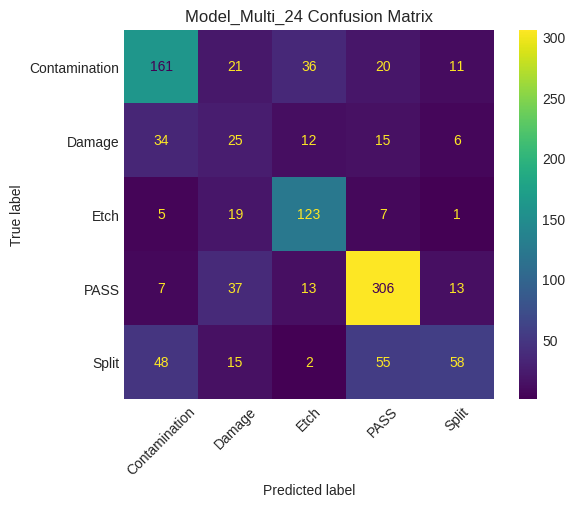

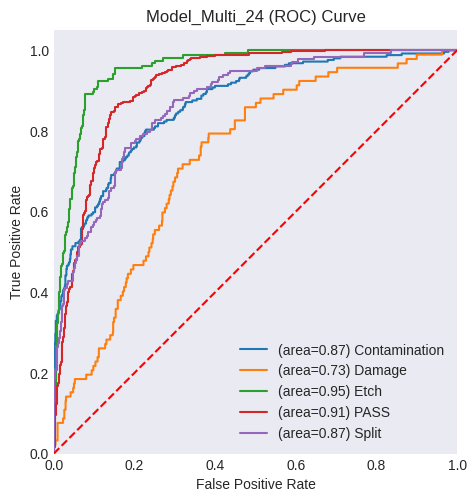

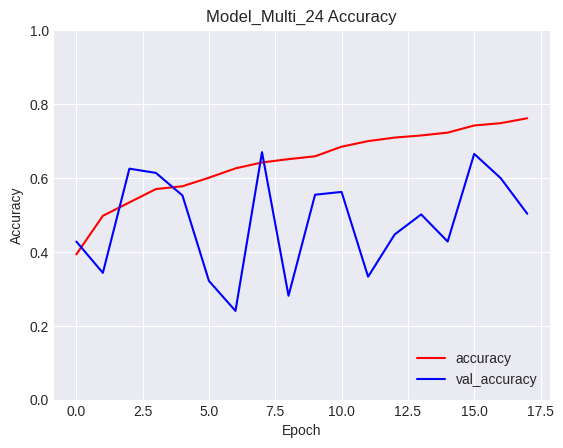

In [ ]:
report_multi_results(model_name, scale_factor, model, history, test_generator)

In [ ]:
model_results_df

Model  Scale Factor  Train Accuracy  Val Accuracy  Test Accuracy
0    Model_Multi_0          0.35        1.000000      0.845494       0.844063
1    Model_Multi_1          0.35        0.588668      0.583691       0.565093
2    Model_Multi_2          0.35        0.415314      0.536481       0.517883
3    Model_Multi_3          0.35        0.821133      0.816881       0.812589
4    Model_Multi_4          0.35        0.125000      0.336195       0.329041
5    Model_Multi_5          0.35        0.262787      0.320458       0.320458
6    Model_Multi_6          0.35        0.937500      0.812589       0.802575
7    Model_Multi_7          0.55        0.829403      0.859800       0.854077
8    Model_Multi_8          0.60        0.854518      0.834049       0.841202
9    Model_Multi_9          0.60        0.750000      0.802575       0.763949
10  Model_Multi_10          0.60        0.504747      0.628040       0.630901
11  Model_Multi_11          0.50        0.648086      0.698140       0.690987
12  Model_Multi_12          0.50        0.601838      0.303779       0.298999
13  Model_Multi_13          0.55        0.875000      0.854077       0.835479
14  Model_Multi_14          0.55        0.907955      0.881259       0.849785
15  Model_Multi_15          0.35        0.874733      0.851216       0.841202
16  Model_Multi_16          0.35        0.880524      0.864092       0.839771
17  Model_Multi_17          0.60        0.874124      0.865522       0.865522
18  Model_Multi_18          0.60        0.901554      0.884120       0.861230
19  Model_Multi_19          0.60        0.865881      0.870740       0.856639
20  Model_Multi_20          0.35        0.924041      0.888367       0.875441
21  Model_Binary_0          0.35        0.969119      0.964747       0.961176
22  Model_Multi_21          0.35        0.874975      0.868571       0.846667
23  Model_Multi_22          0.35        0.887782      0.880952       0.863810
24  Model_Multi_24          0.35        0.641594      0.669524       0.640952

In [ ]:
# save the model_results_df
model_results_df.to_csv('/content/drive/MyDrive/Colab Notebooks/multi_results.csv', index=False)

### ANALYSIS:
- Still horrible.  Not sure what I'm doing wrong, Batch Norm is supposed to help the model converge faster and add some normalization.  Going to put a pin in this one again, maybe try again later

---
### Model Multi 25
Changes:
- Not much luck breaking through that 85-87% accuracy with my standard architecturs
- trying a 6 CONV layer architecture from 'Deep Learning for Vision Systems' -Mohamed Elgendy

In [ ]:
model_name = 'Model_Multi_25'
num_epochs = 100
original_width = 1024
original_height = 943
scale_factor = 0.35
target_size = (int(original_height*scale_factor), int(original_width*scale_factor))

# Instantiate an ImageDataGenerator for the training set with augmentations
train_datagen = ImageDataGenerator(rescale=1./65535,
                                   horizontal_flip=True,
                                   zoom_range=0.05,
                                   height_shift_range=0.05
                                  #  brightness_range=[0.8, 1.2]
)

# Instantiate an ImageDataGenerator for the validation set without augmentations
val_datagen = ImageDataGenerator(rescale=1./65535)

# Instantiate the test generator
test_datagen = ImageDataGenerator(rescale=1./65535)

# create the train generator
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size= target_size,
        batch_size=32,
        shuffle=True,
        color_mode='grayscale',
        class_mode='categorical',
        seed=42
)

# create the validation generator
validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size= target_size,
        batch_size=1,
        shuffle=False,
        color_mode='grayscale',
        class_mode='categorical',
)

# create the test generator
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=1,
        shuffle=False,
        color_mode='grayscale',
        class_mode='categorical',
)


# Get the input shape
input_shape = (target_size[0], target_size[1], 1)


# Define the model
base_hidden_units = 32
weight_decay = 1e-4

# import regularizers
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Activation

model = Sequential()

# CONV1
model.add(Conv2D(base_hidden_units,
                 kernel_size=(3, 3),
                 padding='same',
                 kernel_regularizer=regularizers.l2(weight_decay),
                 input_shape=input_shape
                 ))
model.add(Activation('relu'))
model.add(BatchNormalization())

# CONV2
model.add(Conv2D(base_hidden_units,
                 kernel_size=(3, 3),
                 padding='same',
                 kernel_regularizer=regularizers.l2(weight_decay)
                 ))
model.add(Activation('relu'))
model.add(BatchNormalization())

# POOL + DROPOUT
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# CONV 3
model.add(Conv2D(2*base_hidden_units,
                 kernel_size=(3, 3),
                 padding='same',
                 kernel_regularizer=regularizers.l2(weight_decay)
                 ))
model.add(Activation('relu'))
model.add(BatchNormalization())

# CONV 4
model.add(Conv2D(2*base_hidden_units,
                 kernel_size=(3, 3),
                 padding='same',
                 kernel_regularizer=regularizers.l2(weight_decay)
                 ))
model.add(Activation('relu'))
model.add(BatchNormalization())

# POOL + DROPOUT
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# CONV 5
model.add(Conv2D(4*base_hidden_units,
                 kernel_size=(3, 3),
                 padding='same',
                 kernel_regularizer=regularizers.l2(weight_decay)
                 ))
model.add(Activation('relu'))
model.add(BatchNormalization())

# CONV 6
model.add(Conv2D(4*base_hidden_units,
                 kernel_size=(3, 3),
                 padding='same',
                 kernel_regularizer=regularizers.l2(weight_decay)
                 ))
model.add(Activation('relu'))
model.add(BatchNormalization())

# POOL + DROPOUT
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

# FLATTEN
model.add(Flatten())

# DENSE
model.add(Dense(5, activation='softmax'))


# optimizer
optimizer = Adam(learning_rate=0.0001, decay=1e-6)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# instantiate early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)


# Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(train_generator.classes),
                                                  y=train_generator.classes)
class_weight_dict = {i : class_weights[i] for i in range(len(class_weights))}

model.summary()

Found 4919 images belonging to 5 classes.
Found 1050 images belonging to 5 classes.
Found 1050 images belonging to 5 classes.


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)                   │ (None, 330, 358, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 330, 358, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ (None, 330, 358, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 330, 358, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 330, 358, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_26               │ (None, 330, 358, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 165, 179, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 165, 179, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 165, 179, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 165, 179, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_27               │ (None, 165, 179, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 165, 179, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 165, 179, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_28               │ (None, 165, 179, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 82, 89, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 82, 89, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 82, 89, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 82, 89, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_29               │ (None, 82, 89, 128)         │             512 │
│ (BatchNormalization)                 │                             │              

 Total params: 1,442,789 (5.50 MB)

 Trainable params: 1,441,893 (5.50 MB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
# fit the model
history = model.fit(train_generator,
                epochs=num_epochs,
                validation_data=validation_generator,
                class_weight=class_weight_dict,
                callbacks=[early_stopping]
)

Epoch 1/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 133s 716ms/step - accuracy: 0.3856 - loss: 5.4943 - val_accuracy: 0.1476 - val_loss: 3.8053
Epoch 2/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 102s 636ms/step - accuracy: 0.4880 - loss: 2.8527 - val_accuracy: 0.1629 - val_loss: 2.7752
Epoch 3/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 101s 633ms/step - accuracy: 0.5294 - loss: 2.7549 - val_accuracy: 0.4743 - val_loss: 1.5082
Epoch 4/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 102s 636ms/step - accuracy: 0.5464 - loss: 2.5379 - val_accuracy: 0.4629 - val_loss: 2.5658
Epoch 5/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 103s 640ms/step - accuracy: 0.5649 - loss: 2.3660 - val_accuracy: 0.4305 - val_loss: 4.6395
Epoch 6/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 102s 636ms/step - accuracy: 0.5729 - loss: 2.1803 - val_accuracy: 0.4562 - val_loss: 3.4928
Epoch 7/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 101s 634ms/step - accuracy: 0.5710 - loss: 1.9948 - val_accuracy: 0.5619 - val_loss: 2.1261
Epoch 8/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 101s 632ms/step - accuracy: 

In [ ]:
from tensorflow.keras.models import load_model
model_path = f'/content/drive/MyDrive/LMIS_Classification/Models{model_name}.h5'
model.save(model_path)

1050/1050 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step
  Training Accuracy: 0.728
Validation Accuracy: 0.757
      Test Accuracy: 0.758
              precision    recall  f1-score   support

           0       0.84      0.65      0.73       249
           1       0.57      0.54      0.56        92
           2       0.81      0.78      0.79       155
           3       0.73      0.99      0.84       376
           4       0.82      0.51      0.63       178

    accuracy                           0.76      1050
   macro avg       0.75      0.69      0.71      1050
weighted avg       0.77      0.76      0.75      1050



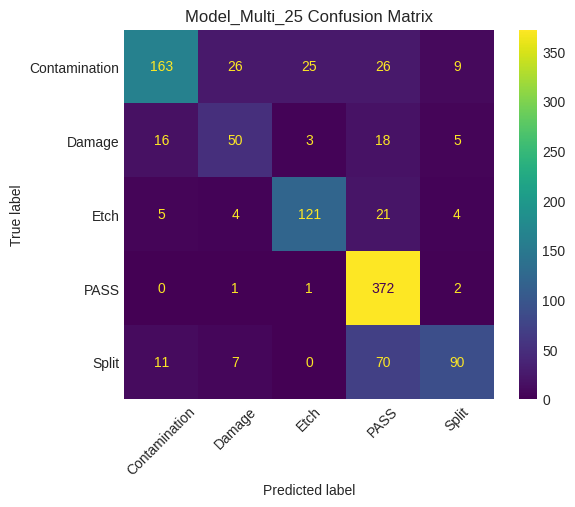

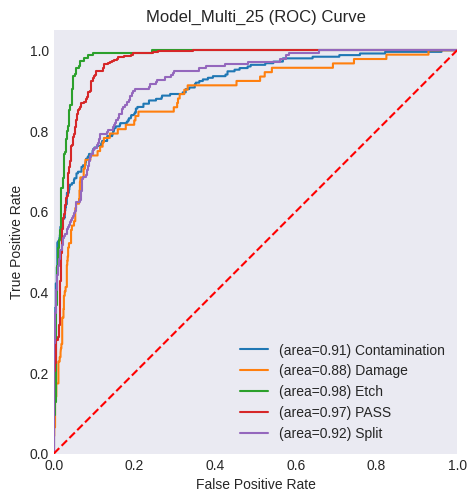

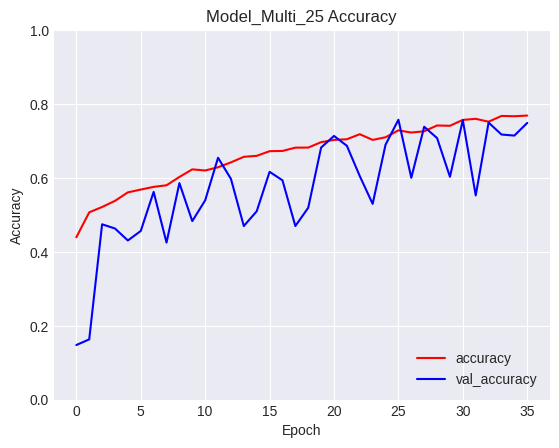

In [ ]:
report_multi_results(model_name, scale_factor, model, history, test_generator)

In [ ]:
model_results_df

Model  Scale Factor  Train Accuracy  Val Accuracy  Test Accuracy
0    Model_Multi_0          0.35        1.000000      0.845494       0.844063
1    Model_Multi_1          0.35        0.588668      0.583691       0.565093
2    Model_Multi_2          0.35        0.415314      0.536481       0.517883
3    Model_Multi_3          0.35        0.821133      0.816881       0.812589
4    Model_Multi_4          0.35        0.125000      0.336195       0.329041
5    Model_Multi_5          0.35        0.262787      0.320458       0.320458
6    Model_Multi_6          0.35        0.937500      0.812589       0.802575
7    Model_Multi_7          0.55        0.829403      0.859800       0.854077
8    Model_Multi_8          0.60        0.854518      0.834049       0.841202
9    Model_Multi_9          0.60        0.750000      0.802575       0.763949
10  Model_Multi_10          0.60        0.504747      0.628040       0.630901
11  Model_Multi_11          0.50        0.648086      0.698140       0.690987
12  Model_Multi_12          0.50        0.601838      0.303779       0.298999
13  Model_Multi_13          0.55        0.875000      0.854077       0.835479
14  Model_Multi_14          0.55        0.907955      0.881259       0.849785
15  Model_Multi_15          0.35        0.874733      0.851216       0.841202
16  Model_Multi_16          0.35        0.880524      0.864092       0.839771
17  Model_Multi_17          0.60        0.874124      0.865522       0.865522
18  Model_Multi_18          0.60        0.901554      0.884120       0.861230
19  Model_Multi_19          0.60        0.865881      0.870740       0.856639
20  Model_Multi_20          0.35        0.924041      0.888367       0.875441
21  Model_Binary_0          0.35        0.969119      0.964747       0.961176
22  Model_Multi_21          0.35        0.874975      0.868571       0.846667
23  Model_Multi_22          0.35        0.887782      0.880952       0.863810
24  Model_Multi_24          0.35        0.641594      0.669524       0.640952
25  Model_Multi_25          0.35        0.728400      0.757143       0.758095

In [ ]:
# save the model_results_df
model_results_df.to_csv('/content/drive/MyDrive/Colab Notebooks/multi_results.csv', index=False)

### ANALYSIS:
- Not good, and took a long time to get there.
- PASS false pos is horrible at 20%!

---
### Model Multi 26
Changes:
- Previous attempt did not have any MLP layers
- 'Deep Learning for Vision Systems' with my MLP layers


In [ ]:
model_name = 'Model_Multi_26'
num_epochs = 100
original_width = 1024
original_height = 943
scale_factor = 0.35
target_size = (int(original_height*scale_factor), int(original_width*scale_factor))

# Instantiate an ImageDataGenerator for the training set with augmentations
train_datagen = ImageDataGenerator(rescale=1./65535,
                                   horizontal_flip=True,
                                   zoom_range=0.05,
                                   height_shift_range=0.05
                                  #  brightness_range=[0.8, 1.2]
)

# Instantiate an ImageDataGenerator for the validation set without augmentations
val_datagen = ImageDataGenerator(rescale=1./65535)

# Instantiate the test generator
test_datagen = ImageDataGenerator(rescale=1./65535)

# create the train generator
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size= target_size,
        batch_size=32,
        shuffle=True,
        color_mode='grayscale',
        class_mode='categorical',
        seed=42
)

# create the validation generator
validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size= target_size,
        batch_size=1,
        shuffle=False,
        color_mode='grayscale',
        class_mode='categorical',
)

# create the test generator
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=1,
        shuffle=False,
        color_mode='grayscale',
        class_mode='categorical',
)


# Get the input shape
input_shape = (target_size[0], target_size[1], 1)


# Define the model
base_hidden_units = 32
weight_decay = 1e-4

# import regularizers
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Activation

model = Sequential()

# CONV1
model.add(Conv2D(base_hidden_units,
                 kernel_size=(3, 3),
                 padding='same',
                 kernel_regularizer=regularizers.l2(weight_decay),
                 input_shape=input_shape
                 ))
model.add(Activation('relu'))
# model.add(BatchNormalization())

# CONV2
model.add(Conv2D(base_hidden_units,
                 kernel_size=(3, 3),
                 padding='same',
                 kernel_regularizer=regularizers.l2(weight_decay)
                 ))
model.add(Activation('relu'))
# model.add(BatchNormalization())

# POOL + DROPOUT
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.2))

# CONV 3
model.add(Conv2D(2*base_hidden_units,
                 kernel_size=(3, 3),
                 padding='same',
                 kernel_regularizer=regularizers.l2(weight_decay)
                 ))
model.add(Activation('relu'))
# model.add(BatchNormalization())

# CONV 4
model.add(Conv2D(2*base_hidden_units,
                 kernel_size=(3, 3),
                 padding='same',
                 kernel_regularizer=regularizers.l2(weight_decay)
                 ))
model.add(Activation('relu'))
# model.add(BatchNormalization())

# POOL + DROPOUT
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.3))

# CONV 5
model.add(Conv2D(4*base_hidden_units,
                 kernel_size=(3, 3),
                 padding='same',
                 kernel_regularizer=regularizers.l2(weight_decay)
                 ))
model.add(Activation('relu'))
# model.add(BatchNormalization())

# CONV 6
model.add(Conv2D(4*base_hidden_units,
                 kernel_size=(3, 3),
                 padding='same',
                 kernel_regularizer=regularizers.l2(weight_decay)
                 ))
model.add(Activation('relu'))
# model.add(BatchNormalization())

# POOL + DROPOUT
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.4))

# FLATTEN
model.add(Flatten())

# MY MLP
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(256, activation='relu'))

model.add(Dense(256, activation='relu'))

model.add(Dense(5, activation='softmax'))


# optimizer
optimizer = Adam(learning_rate=0.00001, decay=1e-6)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# instantiate early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)


# Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(train_generator.classes),
                                                  y=train_generator.classes)
class_weight_dict = {i : class_weights[i] for i in range(len(class_weights))}

model.summary()

Found 4919 images belonging to 5 classes.
Found 1050 images belonging to 5 classes.
Found 1050 images belonging to 5 classes.


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 330, 358, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_12 (Activation)           │ (None, 330, 358, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 330, 358, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_13 (Activation)           │ (None, 330, 358, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 165, 179, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 165, 179, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_14 (Activation)           │ (None, 165, 179, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 165, 179, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_15 (Activation)           │ (None, 165, 179, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 82, 89, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 82, 89, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_16 (Activation)           │ (None, 82, 89, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 82, 89, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_17 (Activation)           │ (None, 82, 89, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 41, 44, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 230912)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 512)                 │     118,227,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 119,237,605 (454.86 MB)

 Trainable params: 119,237,605 (454.86 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# fit the model
history = model.fit(train_generator,
                epochs=num_epochs,
                validation_data=validation_generator,
                class_weight=class_weight_dict,
                callbacks=[early_stopping]
)

Epoch 1/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 113s 661ms/step - accuracy: 0.2401 - loss: 1.6349 - val_accuracy: 0.2686 - val_loss: 1.5711
Epoch 2/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 102s 637ms/step - accuracy: 0.2969 - loss: 1.6083 - val_accuracy: 0.3114 - val_loss: 1.5028
Epoch 3/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 102s 636ms/step - accuracy: 0.3175 - loss: 1.5156 - val_accuracy: 0.3657 - val_loss: 1.3855
Epoch 4/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 103s 644ms/step - accuracy: 0.4067 - loss: 1.4032 - val_accuracy: 0.4886 - val_loss: 1.2333
Epoch 5/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 103s 646ms/step - accuracy: 0.4800 - loss: 1.2993 - val_accuracy: 0.4467 - val_loss: 1.3403
Epoch 6/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 104s 647ms/step - accuracy: 0.4880 - loss: 1.2726 - val_accuracy: 0.4867 - val_loss: 1.2869
Epoch 7/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 104s 650ms/step - accuracy: 0.5283 - loss: 1.2315 - val_accuracy: 0.5200 - val_loss: 1.2126
Epoch 8/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 103s 641ms/step - accuracy: 

In [ ]:
from tensorflow.keras.models import load_model
model_path = f'/content/drive/MyDrive/LMIS_Classification/{model_name}.h5'
model.save(model_path)

1050/1050 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step
  Training Accuracy: 0.774
Validation Accuracy: 0.771
      Test Accuracy: 0.765
              precision    recall  f1-score   support

           0       0.75      0.64      0.69       249
           1       0.47      0.54      0.51        92
           2       0.81      0.87      0.84       155
           3       0.87      0.87      0.87       376
           4       0.69      0.73      0.71       178

    accuracy                           0.76      1050
   macro avg       0.72      0.73      0.72      1050
weighted avg       0.77      0.76      0.77      1050



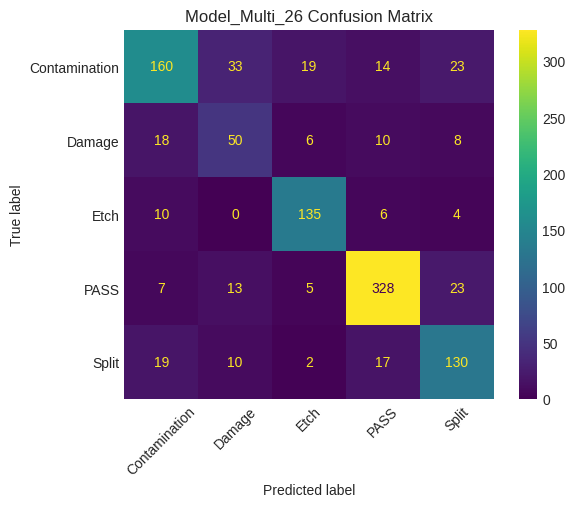

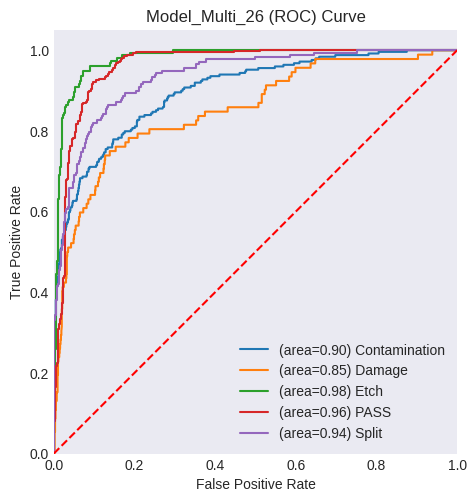

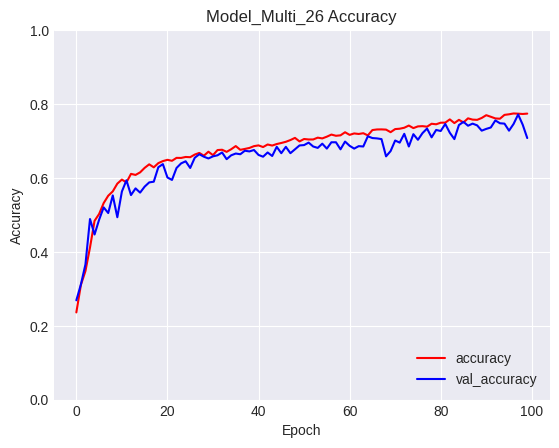

In [ ]:
report_multi_results(model_name, scale_factor, model, history, test_generator)

In [ ]:
model_results_df

Model  Scale Factor  Train Accuracy  Val Accuracy  Test Accuracy
0    Model_Multi_0          0.35        1.000000      0.845494       0.844063
1    Model_Multi_1          0.35        0.588668      0.583691       0.565093
2    Model_Multi_2          0.35        0.415314      0.536481       0.517883
3    Model_Multi_3          0.35        0.821133      0.816881       0.812589
4    Model_Multi_4          0.35        0.125000      0.336195       0.329041
5    Model_Multi_5          0.35        0.262787      0.320458       0.320458
6    Model_Multi_6          0.35        0.937500      0.812589       0.802575
7    Model_Multi_7          0.55        0.829403      0.859800       0.854077
8    Model_Multi_8          0.60        0.854518      0.834049       0.841202
9    Model_Multi_9          0.60        0.750000      0.802575       0.763949
10  Model_Multi_10          0.60        0.504747      0.628040       0.630901
11  Model_Multi_11          0.50        0.648086      0.698140       0.690987
12  Model_Multi_12          0.50        0.601838      0.303779       0.298999
13  Model_Multi_13          0.55        0.875000      0.854077       0.835479
14  Model_Multi_14          0.55        0.907955      0.881259       0.849785
15  Model_Multi_15          0.35        0.874733      0.851216       0.841202
16  Model_Multi_16          0.35        0.880524      0.864092       0.839771
17  Model_Multi_17          0.60        0.874124      0.865522       0.865522
18  Model_Multi_18          0.60        0.901554      0.884120       0.861230
19  Model_Multi_19          0.60        0.865881      0.870740       0.856639
20  Model_Multi_20          0.35        0.924041      0.888367       0.875441
21  Model_Binary_0          0.35        0.969119      0.964747       0.961176
22  Model_Multi_21          0.35        0.874975      0.868571       0.846667
23  Model_Multi_22          0.35        0.887782      0.880952       0.863810
24  Model_Multi_24          0.35        0.641594      0.669524       0.640952
25  Model_Multi_25          0.35        0.728400      0.757143       0.758095
26  Model_Multi_26          0.35        0.773531      0.771429       0.764762

In [ ]:
# save the model_results_df
model_results_df.to_csv('/content/drive/MyDrive/Colab Notebooks/multi_results.csv', index=False)

### ANALYSIS:
- Very slow training, was still going at max of 100 epochs
- Training was still improving when it stopped

---
### Model Multi 27
Changes:
- 'Deep Learning for Vision Systems' with my MLP layers
- Continue training Model 26 that maxed out at 100 epochs


In [ ]:
model_name = 'Model_Multi_27'
num_epochs = 1000
original_width = 1024
original_height = 943
scale_factor = 0.35
target_size = (int(original_height*scale_factor), int(original_width*scale_factor))

# Instantiate an ImageDataGenerator for the training set with augmentations
train_datagen = ImageDataGenerator(rescale=1./65535,
                                   horizontal_flip=True,
                                   zoom_range=0.05,
                                   height_shift_range=0.05
                                  #  brightness_range=[0.8, 1.2]
)

# Instantiate an ImageDataGenerator for the validation set without augmentations
val_datagen = ImageDataGenerator(rescale=1./65535)

# Instantiate the test generator
test_datagen = ImageDataGenerator(rescale=1./65535)

# create the train generator
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size= target_size,
        batch_size=32,
        shuffle=True,
        color_mode='grayscale',
        class_mode='categorical',
        seed=42
)

# create the validation generator
validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size= target_size,
        batch_size=1,
        shuffle=False,
        color_mode='grayscale',
        class_mode='categorical',
)

# create the test generator
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=1,
        shuffle=False,
        color_mode='grayscale',
        class_mode='categorical',
)


# Get the input shape
input_shape = (target_size[0], target_size[1], 1)


# Define the model
base_hidden_units = 32
weight_decay = 1e-4

# import regularizers
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Activation

model = Sequential()

# CONV1
model.add(Conv2D(base_hidden_units,
                 kernel_size=(3, 3),
                 padding='same',
                 kernel_regularizer=regularizers.l2(weight_decay),
                 input_shape=input_shape
                 ))
model.add(Activation('relu'))
# model.add(BatchNormalization())

# CONV2
model.add(Conv2D(base_hidden_units,
                 kernel_size=(3, 3),
                 padding='same',
                 kernel_regularizer=regularizers.l2(weight_decay)
                 ))
model.add(Activation('relu'))
# model.add(BatchNormalization())

# POOL + DROPOUT
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.2))

# CONV 3
model.add(Conv2D(2*base_hidden_units,
                 kernel_size=(3, 3),
                 padding='same',
                 kernel_regularizer=regularizers.l2(weight_decay)
                 ))
model.add(Activation('relu'))
# model.add(BatchNormalization())

# CONV 4
model.add(Conv2D(2*base_hidden_units,
                 kernel_size=(3, 3),
                 padding='same',
                 kernel_regularizer=regularizers.l2(weight_decay)
                 ))
model.add(Activation('relu'))
# model.add(BatchNormalization())

# POOL + DROPOUT
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.3))

# CONV 5
model.add(Conv2D(4*base_hidden_units,
                 kernel_size=(3, 3),
                 padding='same',
                 kernel_regularizer=regularizers.l2(weight_decay)
                 ))
model.add(Activation('relu'))
# model.add(BatchNormalization())

# CONV 6
model.add(Conv2D(4*base_hidden_units,
                 kernel_size=(3, 3),
                 padding='same',
                 kernel_regularizer=regularizers.l2(weight_decay)
                 ))
model.add(Activation('relu'))
# model.add(BatchNormalization())

# POOL + DROPOUT
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.4))

# FLATTEN
model.add(Flatten())

# MY MLP
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(256, activation='relu'))

model.add(Dense(256, activation='relu'))

model.add(Dense(5, activation='softmax'))


# optimizer
optimizer = Adam(learning_rate=0.00001, decay=1e-6)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# instantiate early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)


# Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(train_generator.classes),
                                                  y=train_generator.classes)
class_weight_dict = {i : class_weights[i] for i in range(len(class_weights))}

model.summary()

Found 4919 images belonging to 5 classes.
Found 1050 images belonging to 5 classes.
Found 1050 images belonging to 5 classes.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 330, 358, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 330, 358, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 330, 358, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 330, 358, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 165, 179, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 165, 179, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 165, 179, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 165, 179, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 165, 179, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 82, 89, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 82, 89, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 82, 89, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 82, 89, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 82, 89, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 41, 44, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 230912)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │     118,227,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 119,237,605 (454.86 MB)

 Trainable params: 119,237,605 (454.86 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# load the weights from model 26
model.load_weights('/content/drive/MyDrive/LMIS_Classification/Model_Multi_26.h5')

In [ ]:
# fit the model
history = model.fit(train_generator,
                epochs=num_epochs,
                validation_data=validation_generator,
                class_weight=class_weight_dict,
                callbacks=[early_stopping]
)

Epoch 1/1000
154/154 ━━━━━━━━━━━━━━━━━━━━ 136s 721ms/step - accuracy: 0.7657 - loss: 0.7188 - val_accuracy: 0.7390 - val_loss: 0.7344
Epoch 2/1000
154/154 ━━━━━━━━━━━━━━━━━━━━ 102s 635ms/step - accuracy: 0.7861 - loss: 0.6972 - val_accuracy: 0.7324 - val_loss: 0.7578
Epoch 3/1000
154/154 ━━━━━━━━━━━━━━━━━━━━ 101s 633ms/step - accuracy: 0.7758 - loss: 0.6940 - val_accuracy: 0.7590 - val_loss: 0.6812
Epoch 4/1000
154/154 ━━━━━━━━━━━━━━━━━━━━ 101s 632ms/step - accuracy: 0.7750 - loss: 0.6872 - val_accuracy: 0.7610 - val_loss: 0.6648
Epoch 5/1000
154/154 ━━━━━━━━━━━━━━━━━━━━ 101s 629ms/step - accuracy: 0.7825 - loss: 0.6910 - val_accuracy: 0.7581 - val_loss: 0.6787
Epoch 6/1000
154/154 ━━━━━━━━━━━━━━━━━━━━ 101s 632ms/step - accuracy: 0.7707 - loss: 0.7019 - val_accuracy: 0.7486 - val_loss: 0.7425
Epoch 7/1000
154/154 ━━━━━━━━━━━━━━━━━━━━ 101s 633ms/step - accuracy: 0.7856 - loss: 0.6932 - val_accuracy: 0.7695 - val_loss: 0.6497
Epoch 8/1000
154/154 ━━━━━━━━━━━━━━━━━━━━ 102s 634ms/step - ac

In [ ]:
from tensorflow.keras.models import load_model
model_path = f'/content/drive/MyDrive/LMIS_Classification/{model_name}.h5'
model.save(model_path)

1050/1050 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step
  Training Accuracy: 0.829
Validation Accuracy: 0.827
      Test Accuracy: 0.813
              precision    recall  f1-score   support

           0       0.79      0.71      0.75       249
           1       0.52      0.61      0.56        92
           2       0.86      0.92      0.89       155
           3       0.92      0.90      0.91       376
           4       0.75      0.78      0.76       178

    accuracy                           0.81      1050
   macro avg       0.77      0.78      0.78      1050
weighted avg       0.82      0.81      0.81      1050



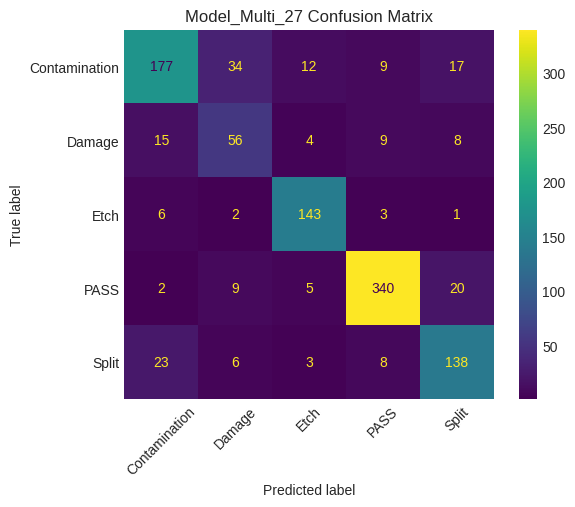

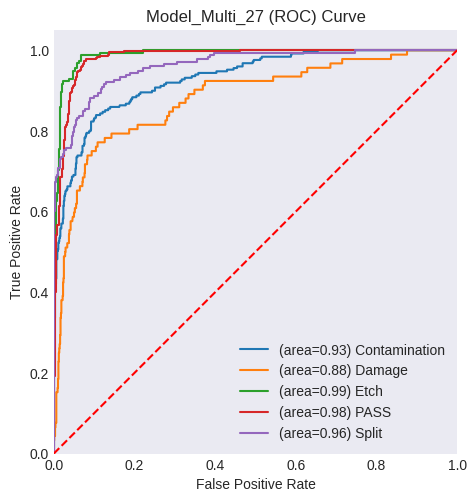

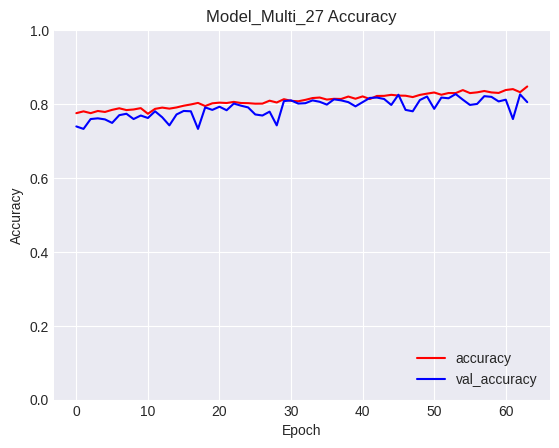

In [ ]:
report_multi_results(model_name, scale_factor, model, history, test_generator)

In [ ]:
model_results_df

Model  Scale Factor  Train Accuracy  Val Accuracy  Test Accuracy
0    Model_Multi_0          0.35        1.000000      0.845494       0.844063
1    Model_Multi_1          0.35        0.588668      0.583691       0.565093
2    Model_Multi_2          0.35        0.415314      0.536481       0.517883
3    Model_Multi_3          0.35        0.821133      0.816881       0.812589
4    Model_Multi_4          0.35        0.125000      0.336195       0.329041
5    Model_Multi_5          0.35        0.262787      0.320458       0.320458
6    Model_Multi_6          0.35        0.937500      0.812589       0.802575
7    Model_Multi_7          0.55        0.829403      0.859800       0.854077
8    Model_Multi_8          0.60        0.854518      0.834049       0.841202
9    Model_Multi_9          0.60        0.750000      0.802575       0.763949
10  Model_Multi_10          0.60        0.504747      0.628040       0.630901
11  Model_Multi_11          0.50        0.648086      0.698140       0.690987
12  Model_Multi_12          0.50        0.601838      0.303779       0.298999
13  Model_Multi_13          0.55        0.875000      0.854077       0.835479
14  Model_Multi_14          0.55        0.907955      0.881259       0.849785
15  Model_Multi_15          0.35        0.874733      0.851216       0.841202
16  Model_Multi_16          0.35        0.880524      0.864092       0.839771
17  Model_Multi_17          0.60        0.874124      0.865522       0.865522
18  Model_Multi_18          0.60        0.901554      0.884120       0.861230
19  Model_Multi_19          0.60        0.865881      0.870740       0.856639
20  Model_Multi_20          0.35        0.924041      0.888367       0.875441
21  Model_Binary_0          0.35        0.969119      0.964747       0.961176
22  Model_Multi_21          0.35        0.874975      0.868571       0.846667
23  Model_Multi_22          0.35        0.887782      0.880952       0.863810
24  Model_Multi_23          0.35        0.875991      0.875238       0.855238
25  Model_Multi_24          0.35        0.641594      0.669524       0.640952
26  Model_Multi_25          0.35        0.728400      0.757143       0.758095
27  Model_Multi_27          0.35        0.829234      0.826667       0.813333

In [ ]:
# save the model_results_df
model_results_df.to_csv('/content/drive/MyDrive/Colab Notebooks/multi_results.csv', index=False)

### ANALYSIS:
- Early stopped finally for a total of 164 epochs
- Might have still been very slowly improving, but PASS false pos still not great at 4.5%

---
### Model Multi 28
Changes:
- Running Model 14 with best PASS FPR on additional Etch class

In [ ]:
model_name = 'Model_Multi_28'
num_epochs = 100
original_width = 1024
original_height = 943
scale_factor = 0.55
target_size = (int(original_height*scale_factor), int(original_width*scale_factor))

# Instantiate an ImageDataGenerator for the training set with augmentations
train_datagen = ImageDataGenerator(rescale=1./65535,
                                   horizontal_flip=True,
                                   zoom_range=0.05,
                                   height_shift_range=0.05)

# Instantiate an ImageDataGenerator for the validation set without augmentations
val_datagen = ImageDataGenerator(rescale=1./65535)

# Instantiate the test generator
test_datagen = ImageDataGenerator(rescale=1./65535)

# create the train generator
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size= target_size,
        batch_size=16,
        shuffle=True,
        color_mode='grayscale',
        class_mode='categorical',
        seed=42
)

# create the validation generator
validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size= target_size,
        batch_size=16,
        shuffle=False,
        color_mode='grayscale',
        class_mode='categorical',
)

# create the test generator
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=16,
        shuffle=False,
        color_mode='grayscale',
        class_mode='categorical',
)


# Get the input shape
input_shape = (target_size[0], target_size[1], 1)

# Define the model
model = Sequential([
    Conv2D(32, (3, 3),
           activation='relu',
           input_shape=input_shape,
           padding='valid'),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='valid'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='valid'),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu', padding='valid'),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(512, activation='relu'),
    Dropout(0.2),

    Dense(512, activation='relu'),

    Dense(256, activation='relu'),
    Dense(5, activation='softmax')
])

from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# instantiate early stopping
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)


# Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(train_generator.classes),
                                                  y=train_generator.classes)
class_weight_dict = {i : class_weights[i] for i in range(len(class_weights))}

model.summary()


Found 4919 images belonging to 5 classes.
Found 1050 images belonging to 5 classes.
Found 1050 images belonging to 5 classes.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 516, 561, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 258, 280, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 256, 278, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 128, 139, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 126, 137, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 63, 68, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 61, 66, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 30, 33, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 253440)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │     129,761,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 130,544,901 (497.99 MB)

 Trainable params: 130,544,901 (497.99 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# fit the model
history = model.fit(train_generator,
                epochs=num_epochs,
                validation_data=validation_generator,
                class_weight=class_weight_dict,
                # shuffle=True,
                callbacks=[early_stopping]
)

Epoch 1/100
308/308 ━━━━━━━━━━━━━━━━━━━━ 182s 544ms/step - categorical_accuracy: 0.1909 - loss: 1.6111 - val_categorical_accuracy: 0.1733 - val_loss: 1.5846
Epoch 2/100
308/308 ━━━━━━━━━━━━━━━━━━━━ 159s 507ms/step - categorical_accuracy: 0.2976 - loss: 1.4503 - val_categorical_accuracy: 0.4952 - val_loss: 1.2411
Epoch 3/100
308/308 ━━━━━━━━━━━━━━━━━━━━ 159s 504ms/step - categorical_accuracy: 0.4653 - loss: 1.2641 - val_categorical_accuracy: 0.5133 - val_loss: 1.2745
Epoch 4/100
308/308 ━━━━━━━━━━━━━━━━━━━━ 157s 501ms/step - categorical_accuracy: 0.5866 - loss: 1.1267 - val_categorical_accuracy: 0.6924 - val_loss: 0.8854
Epoch 5/100
308/308 ━━━━━━━━━━━━━━━━━━━━ 156s 496ms/step - categorical_accuracy: 0.6343 - loss: 1.0440 - val_categorical_accuracy: 0.6324 - val_loss: 0.9669
Epoch 6/100
308/308 ━━━━━━━━━━━━━━━━━━━━ 156s 498ms/step - categorical_accuracy: 0.6875 - loss: 0.9103 - val_categorical_accuracy: 0.7086 - val_loss: 0.7988
Epoch 7/100
308/308 ━━━━━━━━━━━━━━━━━━━━ 156s 497ms/step -

In [ ]:
from tensorflow.keras.models import load_model
model_path = f'/content/drive/MyDrive/LMIS_Classification/{model_name}.h5'
model.save(model_path)

66/66 ━━━━━━━━━━━━━━━━━━━━ 14s 207ms/step
  Training Accuracy: 0.942
Validation Accuracy: 0.880
      Test Accuracy: 0.835
FPR for PASS class: 0.0267
              precision    recall  f1-score   support

           0       0.90      0.65      0.76       249
           1       0.52      0.74      0.61        92
           2       0.78      0.90      0.84       155
           3       0.95      0.92      0.94       376
           4       0.83      0.90      0.86       178

    accuracy                           0.84      1050
   macro avg       0.79      0.82      0.80      1050
weighted avg       0.85      0.84      0.84      1050



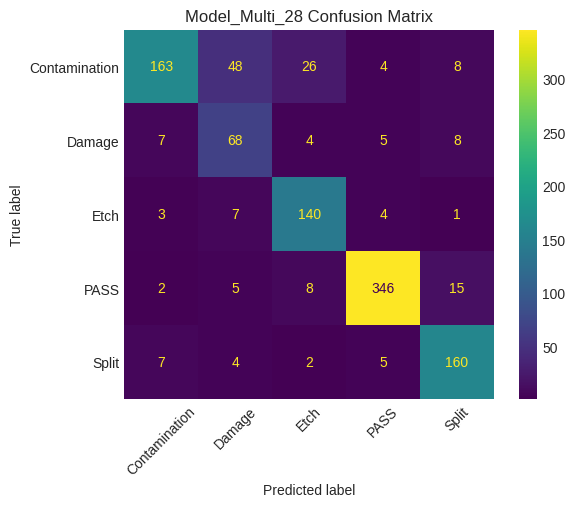

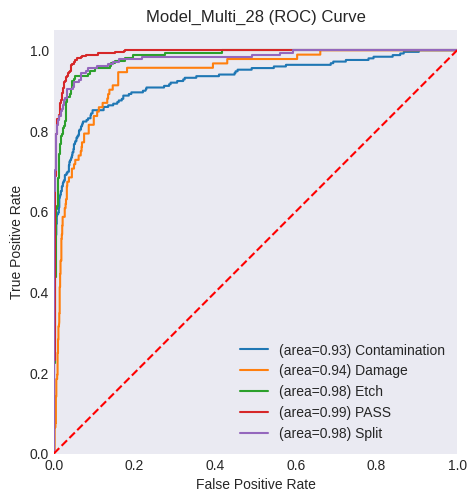

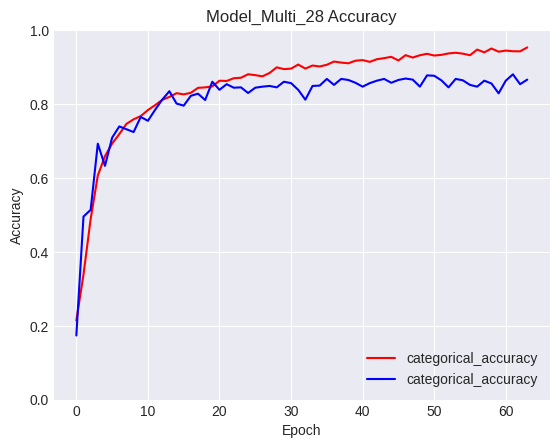

In [ ]:
report_multi_results(model_name, scale_factor, model, history, test_generator)

In [ ]:
model_results_df

Model  Scale Factor  Train Accuracy  Val Accuracy  Test Accuracy
0    Model_Multi_0          0.35        1.000000      0.845494       0.844063
1    Model_Multi_1          0.35        0.588668      0.583691       0.565093
2    Model_Multi_2          0.35        0.415314      0.536481       0.517883
3    Model_Multi_3          0.35        0.821133      0.816881       0.812589
4    Model_Multi_4          0.35        0.125000      0.336195       0.329041
5    Model_Multi_5          0.35        0.262787      0.320458       0.320458
6    Model_Multi_6          0.35        0.937500      0.812589       0.802575
7    Model_Multi_7          0.55        0.829403      0.859800       0.854077
8    Model_Multi_8          0.60        0.854518      0.834049       0.841202
9    Model_Multi_9          0.60        0.750000      0.802575       0.763949
10  Model_Multi_10          0.60        0.504747      0.628040       0.630901
11  Model_Multi_11          0.50        0.648086      0.698140       0.690987
12  Model_Multi_12          0.50        0.601838      0.303779       0.298999
13  Model_Multi_13          0.55        0.875000      0.854077       0.835479
14  Model_Multi_14          0.55        0.907955      0.881259       0.849785
15  Model_Multi_15          0.35        0.874733      0.851216       0.841202
16  Model_Multi_16          0.35        0.880524      0.864092       0.839771
17  Model_Multi_17          0.60        0.874124      0.865522       0.865522
18  Model_Multi_18          0.60        0.901554      0.884120       0.861230
19  Model_Multi_19          0.60        0.865881      0.870740       0.856639
20  Model_Multi_20          0.35        0.924041      0.888367       0.875441
21  Model_Binary_0          0.35        0.969119      0.964747       0.961176
22  Model_Multi_21          0.35        0.874975      0.868571       0.846667
23  Model_Multi_22          0.35        0.887782      0.880952       0.863810
24  Model_Multi_23          0.35        0.875991      0.875238       0.855238
25  Model_Multi_24          0.35        0.641594      0.669524       0.640952
26  Model_Multi_25          0.35        0.728400      0.757143       0.758095
27  Model_Multi_27          0.35        0.829234      0.826667       0.813333
28  Model_Multi_28          0.55        0.942468      0.880000       0.835238

In [ ]:
# save the model_results_df
model_results_df.to_csv('/content/drive/MyDrive/Colab Notebooks/multi_results.csv', index=False)

### ANALYSIS:
- Somewhat coparable to model 21 with respect to accuracy and pass FPR
- Somewhat overfit

---
### Model Multi 29
Changes:
- Adding dropout

In [ ]:
model_name = 'Model_Multi_29'
num_epochs = 1000
original_width = 1024
original_height = 943
scale_factor = 0.55
target_size = (int(original_height*scale_factor), int(original_width*scale_factor))

# Instantiate an ImageDataGenerator for the training set with augmentations
train_datagen = ImageDataGenerator(rescale=1./65535,
                                   horizontal_flip=True,
                                   zoom_range=0.05,
                                   height_shift_range=0.05)

# Instantiate an ImageDataGenerator for the validation set without augmentations
val_datagen = ImageDataGenerator(rescale=1./65535)

# Instantiate the test generator
test_datagen = ImageDataGenerator(rescale=1./65535)

# create the train generator
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size= target_size,
        batch_size=16,
        shuffle=True,
        color_mode='grayscale',
        class_mode='categorical',
        seed=42
)

# create the validation generator
validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size= target_size,
        batch_size=16,
        shuffle=False,
        color_mode='grayscale',
        class_mode='categorical',
)

# create the test generator
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=16,
        shuffle=False,
        color_mode='grayscale',
        class_mode='categorical',
)


# Get the input shape
input_shape = (target_size[0], target_size[1], 1)

# Define the model
model = Sequential([
    Conv2D(32, (3, 3),
           activation='relu',
           input_shape=input_shape,
           padding='valid'),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='valid'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='valid'),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu', padding='valid'),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(512, activation='relu'),
    Dropout(0.2),

    Dense(512, activation='relu'),
    Dropout(0.2),

    Dense(256, activation='relu'),
    Dense(5, activation='softmax')
])

from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# instantiate early stopping
early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=10, restore_best_weights=True)


# Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(train_generator.classes),
                                                  y=train_generator.classes)
class_weight_dict = {i : class_weights[i] for i in range(len(class_weights))}

model.summary()


Found 4919 images belonging to 5 classes.
Found 1050 images belonging to 5 classes.
Found 1050 images belonging to 5 classes.


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 516, 561, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 258, 280, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 256, 278, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 128, 139, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 126, 137, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 63, 68, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 61, 66, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 30, 33, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 253440)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 512)                 │     129,761,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 130,544,901 (497.99 MB)

 Trainable params: 130,544,901 (497.99 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# fit the model
history = model.fit(train_generator,
                epochs=num_epochs,
                validation_data=validation_generator,
                class_weight=class_weight_dict,
                # shuffle=True,
                callbacks=[early_stopping]
)

Epoch 1/1000
308/308 ━━━━━━━━━━━━━━━━━━━━ 165s 507ms/step - categorical_accuracy: 0.2155 - loss: 1.6002 - val_categorical_accuracy: 0.2771 - val_loss: 1.4974
Epoch 2/1000
308/308 ━━━━━━━━━━━━━━━━━━━━ 156s 496ms/step - categorical_accuracy: 0.2954 - loss: 1.4864 - val_categorical_accuracy: 0.3333 - val_loss: 1.3843
Epoch 3/1000
308/308 ━━━━━━━━━━━━━━━━━━━━ 155s 493ms/step - categorical_accuracy: 0.3936 - loss: 1.3434 - val_categorical_accuracy: 0.4648 - val_loss: 1.2181
Epoch 4/1000
308/308 ━━━━━━━━━━━━━━━━━━━━ 155s 494ms/step - categorical_accuracy: 0.4960 - loss: 1.2009 - val_categorical_accuracy: 0.5000 - val_loss: 1.2148
Epoch 5/1000
308/308 ━━━━━━━━━━━━━━━━━━━━ 155s 492ms/step - categorical_accuracy: 0.6085 - loss: 1.0373 - val_categorical_accuracy: 0.6505 - val_loss: 0.9314
Epoch 6/1000
308/308 ━━━━━━━━━━━━━━━━━━━━ 156s 496ms/step - categorical_accuracy: 0.6136 - loss: 1.0047 - val_categorical_accuracy: 0.5781 - val_loss: 1.0229
Epoch 7/1000
308/308 ━━━━━━━━━━━━━━━━━━━━ 156s 496ms

In [ ]:
from tensorflow.keras.models import load_model
model_path = f'/content/drive/MyDrive/LMIS_Classification/{model_name}.h5'
model.save(model_path)

66/66 ━━━━━━━━━━━━━━━━━━━━ 17s 235ms/step
  Training Accuracy: 0.875
Validation Accuracy: 0.852
      Test Accuracy: 0.832
 FPR for PASS class: 0.0593
              precision    recall  f1-score   support

           0       0.82      0.82      0.82       249
           1       0.64      0.61      0.62        92
           2       0.87      0.84      0.85       155
           3       0.90      0.91      0.90       376
           4       0.79      0.80      0.79       178

    accuracy                           0.83      1050
   macro avg       0.80      0.79      0.80      1050
weighted avg       0.83      0.83      0.83      1050



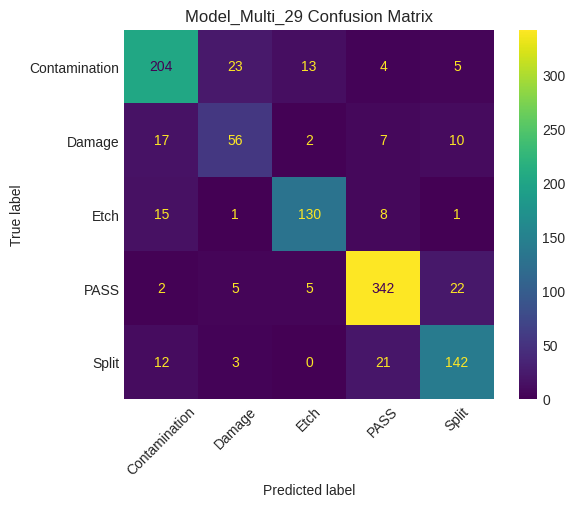

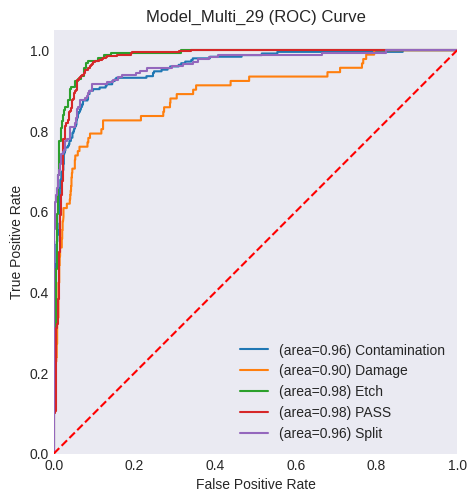

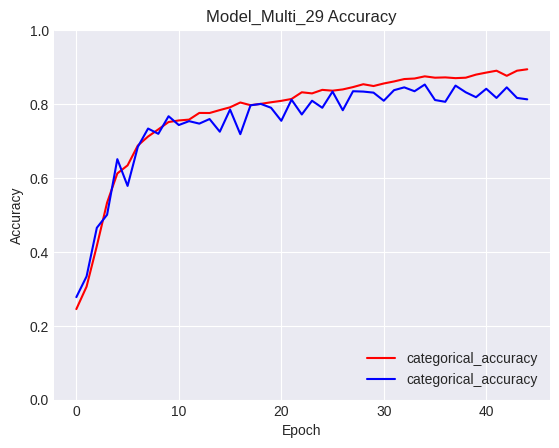

In [ ]:
report_multi_results(model_name, scale_factor, model, history, test_generator)

In [ ]:
model_results_df

Model  Scale Factor  Train Accuracy  Val Accuracy  Test Accuracy
0    Model_Multi_0          0.35        1.000000      0.845494       0.844063
1    Model_Multi_1          0.35        0.588668      0.583691       0.565093
2    Model_Multi_2          0.35        0.415314      0.536481       0.517883
3    Model_Multi_3          0.35        0.821133      0.816881       0.812589
4    Model_Multi_4          0.35        0.125000      0.336195       0.329041
5    Model_Multi_5          0.35        0.262787      0.320458       0.320458
6    Model_Multi_6          0.35        0.937500      0.812589       0.802575
7    Model_Multi_7          0.55        0.829403      0.859800       0.854077
8    Model_Multi_8          0.60        0.854518      0.834049       0.841202
9    Model_Multi_9          0.60        0.750000      0.802575       0.763949
10  Model_Multi_10          0.60        0.504747      0.628040       0.630901
11  Model_Multi_11          0.50        0.648086      0.698140       0.690987
12  Model_Multi_12          0.50        0.601838      0.303779       0.298999
13  Model_Multi_13          0.55        0.875000      0.854077       0.835479
14  Model_Multi_14          0.55        0.907955      0.881259       0.849785
15  Model_Multi_15          0.35        0.874733      0.851216       0.841202
16  Model_Multi_16          0.35        0.880524      0.864092       0.839771
17  Model_Multi_17          0.60        0.874124      0.865522       0.865522
18  Model_Multi_18          0.60        0.901554      0.884120       0.861230
19  Model_Multi_19          0.60        0.865881      0.870740       0.856639
20  Model_Multi_20          0.35        0.924041      0.888367       0.875441
21  Model_Binary_0          0.35        0.969119      0.964747       0.961176
22  Model_Multi_21          0.35        0.874975      0.868571       0.846667
23  Model_Multi_22          0.35        0.887782      0.880952       0.863810
24  Model_Multi_23          0.35        0.875991      0.875238       0.855238
25  Model_Multi_24          0.35        0.641594      0.669524       0.640952
26  Model_Multi_25          0.35        0.728400      0.757143       0.758095
27  Model_Multi_27          0.35        0.829234      0.826667       0.813333
28  Model_Multi_28          0.55        0.942468      0.880000       0.835238
29  Model_Multi_29          0.55        0.874568      0.852381       0.832381

In [ ]:
# save the model_results_df
model_results_df.to_csv('/content/drive/MyDrive/Colab Notebooks/multi_results.csv', index=False)

### ANALYSIS:
- Reduced overfitting, but at the cost of PASS FPR = 6%... too much.

---
### Model Multi 30
Changes:
- Last day of training for this project timeline, going to adjust a few things in one last attempt
    - scale_factor = 0.35
    - early stop monitor = val_loss
    - val, test batch size = 1
    - train batch size = 32

In [ ]:
model_name = 'Model_Multi_30'
num_epochs = 1000
original_width = 1024
original_height = 943
scale_factor = 0.35
target_size = (int(original_height*scale_factor), int(original_width*scale_factor))

# Instantiate an ImageDataGenerator for the training set with augmentations
train_datagen = ImageDataGenerator(rescale=1./65535,
                                   horizontal_flip=True,
                                   zoom_range=0.05,
                                   height_shift_range=0.05)

# Instantiate an ImageDataGenerator for the validation set without augmentations
val_datagen = ImageDataGenerator(rescale=1./65535)

# Instantiate the test generator
test_datagen = ImageDataGenerator(rescale=1./65535)

# create the train generator
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size= target_size,
        batch_size=32,
        shuffle=True,
        color_mode='grayscale',
        class_mode='categorical',
        seed=42
)

# create the validation generator
validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size= target_size,
        batch_size=1,
        shuffle=False,
        color_mode='grayscale',
        class_mode='categorical',
)

# create the test generator
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=1,
        shuffle=False,
        color_mode='grayscale',
        class_mode='categorical',
)


# Get the input shape
input_shape = (target_size[0], target_size[1], 1)

# Define the model
model = Sequential([
    Conv2D(32, (3, 3),
           activation='relu',
           input_shape=input_shape,
           padding='valid'),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='valid'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='valid'),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu', padding='valid'),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(512, activation='relu'),
    Dropout(0.2),

    Dense(512, activation='relu'),
    Dropout(0.2),

    Dense(256, activation='relu'),
    Dense(5, activation='softmax')
])

from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# instantiate early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


# Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(train_generator.classes),
                                                  y=train_generator.classes)
class_weight_dict = {i : class_weights[i] for i in range(len(class_weights))}

model.summary()


Found 4919 images belonging to 5 classes.
Found 1050 images belonging to 5 classes.
Found 1050 images belonging to 5 classes.


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)                   │ (None, 328, 356, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 164, 178, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 162, 176, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 81, 88, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 79, 86, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 39, 43, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 37, 41, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 18, 20, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 92160)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 512)                 │      47,186,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 47,969,541 (182.99 MB)

 Trainable params: 47,969,541 (182.99 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# fit the model
history = model.fit(train_generator,
                epochs=num_epochs,
                validation_data=validation_generator,
                class_weight=class_weight_dict,
                callbacks=[early_stopping]
)

Epoch 1/1000
154/154 ━━━━━━━━━━━━━━━━━━━━ 121s 708ms/step - categorical_accuracy: 0.2321 - loss: 1.5693 - val_categorical_accuracy: 0.3143 - val_loss: 1.5173
Epoch 2/1000
154/154 ━━━━━━━━━━━━━━━━━━━━ 109s 678ms/step - categorical_accuracy: 0.3675 - loss: 1.3733 - val_categorical_accuracy: 0.3362 - val_loss: 3.9765
Epoch 3/1000
154/154 ━━━━━━━━━━━━━━━━━━━━ 108s 678ms/step - categorical_accuracy: 0.5134 - loss: 1.2073 - val_categorical_accuracy: 0.6429 - val_loss: 0.9573
Epoch 4/1000
154/154 ━━━━━━━━━━━━━━━━━━━━ 109s 680ms/step - categorical_accuracy: 0.6179 - loss: 1.0661 - val_categorical_accuracy: 0.6676 - val_loss: 0.9905
Epoch 5/1000
154/154 ━━━━━━━━━━━━━━━━━━━━ 109s 678ms/step - categorical_accuracy: 0.6690 - loss: 0.9608 - val_categorical_accuracy: 0.6476 - val_loss: 1.0725
Epoch 6/1000
154/154 ━━━━━━━━━━━━━━━━━━━━ 108s 676ms/step - categorical_accuracy: 0.6889 - loss: 0.9110 - val_categorical_accuracy: 0.7371 - val_loss: 0.7296
Epoch 7/1000
154/154 ━━━━━━━━━━━━━━━━━━━━ 110s 687ms

In [ ]:
from tensorflow.keras.models import load_model
model_path = f'/content/drive/MyDrive/LMIS_Classification/{model_name}.h5'
model.save(model_path)

1050/1050 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step
  Training Accuracy: 0.882
Validation Accuracy: 0.871
      Test Accuracy: 0.860
 FPR for PASS class: 0.0490
              precision    recall  f1-score   support

           0       0.90      0.74      0.81       249
           1       0.58      0.73      0.65        92
           2       0.84      0.94      0.89       155
           3       0.92      0.97      0.94       376
           4       0.88      0.81      0.84       178

    accuracy                           0.86      1050
   macro avg       0.83      0.84      0.83      1050
weighted avg       0.87      0.86      0.86      1050



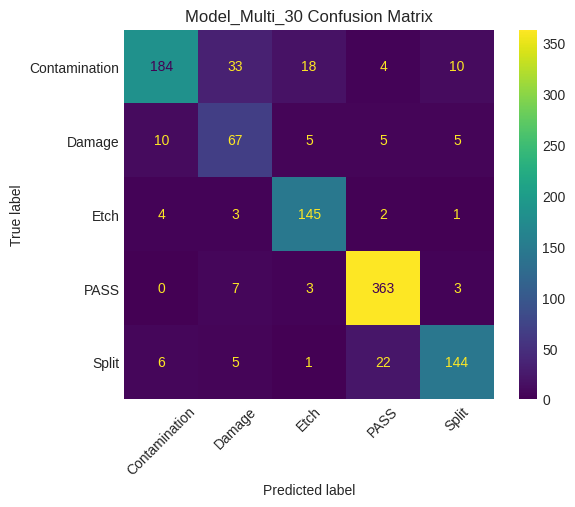

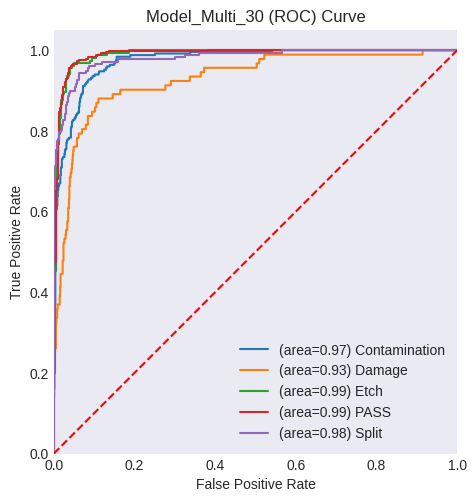

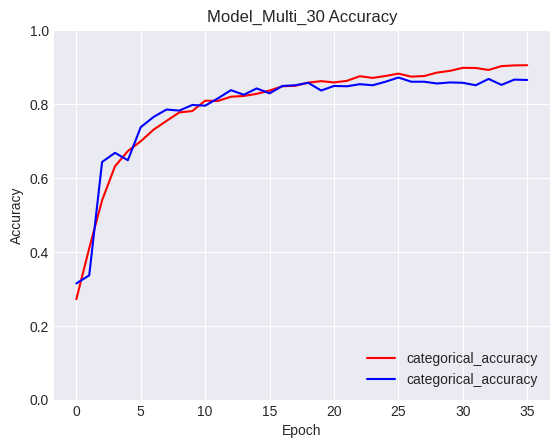

In [ ]:
report_multi_results(model_name, scale_factor, model, history, test_generator)

In [ ]:
model_results_df

Model  Scale Factor  Train Accuracy  Val Accuracy  Test Accuracy
0    Model_Multi_0          0.35        1.000000      0.845494       0.844063
1    Model_Multi_1          0.35        0.588668      0.583691       0.565093
2    Model_Multi_2          0.35        0.415314      0.536481       0.517883
3    Model_Multi_3          0.35        0.821133      0.816881       0.812589
4    Model_Multi_4          0.35        0.125000      0.336195       0.329041
5    Model_Multi_5          0.35        0.262787      0.320458       0.320458
6    Model_Multi_6          0.35        0.937500      0.812589       0.802575
7    Model_Multi_7          0.55        0.829403      0.859800       0.854077
8    Model_Multi_8          0.60        0.854518      0.834049       0.841202
9    Model_Multi_9          0.60        0.750000      0.802575       0.763949
10  Model_Multi_10          0.60        0.504747      0.628040       0.630901
11  Model_Multi_11          0.50        0.648086      0.698140       0.690987
12  Model_Multi_12          0.50        0.601838      0.303779       0.298999
13  Model_Multi_13          0.55        0.875000      0.854077       0.835479
14  Model_Multi_14          0.55        0.907955      0.881259       0.849785
15  Model_Multi_15          0.35        0.874733      0.851216       0.841202
16  Model_Multi_16          0.35        0.880524      0.864092       0.839771
17  Model_Multi_17          0.60        0.874124      0.865522       0.865522
18  Model_Multi_18          0.60        0.901554      0.884120       0.861230
19  Model_Multi_19          0.60        0.865881      0.870740       0.856639
20  Model_Multi_20          0.35        0.924041      0.888367       0.875441
21  Model_Binary_0          0.35        0.969119      0.964747       0.961176
22  Model_Multi_21          0.35        0.874975      0.868571       0.846667
23  Model_Multi_22          0.35        0.887782      0.880952       0.863810
24  Model_Multi_23          0.35        0.875991      0.875238       0.855238
25  Model_Multi_24          0.35        0.641594      0.669524       0.640952
26  Model_Multi_25          0.35        0.728400      0.757143       0.758095
27  Model_Multi_27          0.35        0.829234      0.826667       0.813333
28  Model_Multi_28          0.55        0.942468      0.880000       0.835238
29  Model_Multi_29          0.55        0.874568      0.852381       0.832381
30  Model_Multi_30          0.35        0.881887      0.871429       0.860000

In [ ]:
# save the model_results_df
model_results_df.to_csv('/content/drive/MyDrive/Colab Notebooks/multi_results.csv', index=False)

### ANALYSIS:
- Comparable to model 23, but PASS FPR = 5%

---
---
## Best Models at PASS FPR < 1%
- Taking the best models with respect to accuracy, PASS FPR from after the Etch class was added
- The probabality of a PASS class will be reduced for each model until it is just barely under 1% by one image result.
- The best model will be the one with the best accuracy at this setting


---
### Model Multi 31
Changes:
- Model 21 with PASS FPR adjusted down

In [ ]:
model_name = 'Model_Multi_31'
num_epochs = 100
original_width = 1024
original_height = 943
scale_factor = 0.35
target_size = (int(original_height*scale_factor), int(original_width*scale_factor))

# Instantiate an ImageDataGenerator for the training set with augmentations
train_datagen = ImageDataGenerator(rescale=1./65535,
                                   horizontal_flip=True,
                                   zoom_range=0.05,
                                   height_shift_range=0.05,
                                   brightness_range=[0.8, 1.2]
)

# Instantiate an ImageDataGenerator for the validation set without augmentations
val_datagen = ImageDataGenerator(rescale=1./65535)

# Instantiate the test generator
test_datagen = ImageDataGenerator(rescale=1./65535)

# create the train generator
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size= target_size,
        batch_size=32,
        shuffle=True,
        color_mode='grayscale',
        class_mode='categorical',
        seed=42
)

# create the validation generator
validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size= target_size,
        batch_size=32,
        shuffle=False,
        color_mode='grayscale',
        class_mode='categorical',
)

# create the test generator
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=1,
        shuffle=False,
        color_mode='grayscale',
        class_mode='categorical',
)


# Get the input shape
input_shape = (target_size[0], target_size[1], 1)

# Define the model
padding = 'valid'
model = Sequential([
    Conv2D(32, (3, 3),
           activation='relu',
           input_shape=input_shape,
           padding=padding),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding=padding),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding=padding),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu', padding=padding),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(512, activation='relu'),
    Dropout(0.2),

    Dense(512, activation='relu'),
    Dropout(0.2),

    Dense(512, activation='relu'),
    Dropout(0.2),

    Dense(256, activation='relu'),

    Dense(256, activation='relu'),
    Dense(5, activation='softmax')
])

# optimizer
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


Found 4919 images belonging to 5 classes.
Found 1050 images belonging to 5 classes.
Found 1050 images belonging to 5 classes.


In [ ]:
# Load the weights from the .pkl file
# from tensorflow.keras.models import load_model
model.load_weights('Models\\Model_Multi_21.h5')

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 328, 356, 32)      320       
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 164, 178, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 162, 176, 64)      18496     
                                                                 
 max_pooling2d_41 (MaxPoolin  (None, 81, 88, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_42 (Conv2D)          (None, 79, 86, 128)       73856     
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 39, 43, 128)    

1050/1050 [==============================] - 32s 31ms/step
 Pre-adjusted Test Accuracy: 0.847
         FPR for PASS class: 0.0089
Pass Probability Adjustment: -0.620000
Post-adjusted Test Accuracy: 0.8029
              precision    recall  f1-score   support

           0       0.83      0.80      0.82       249
           1       0.47      0.75      0.58        92
           2       0.83      0.88      0.85       155
           3       0.98      0.76      0.85       376
           4       0.74      0.87      0.80       178

    accuracy                           0.80      1050
   macro avg       0.77      0.81      0.78      1050
weighted avg       0.84      0.80      0.81      1050



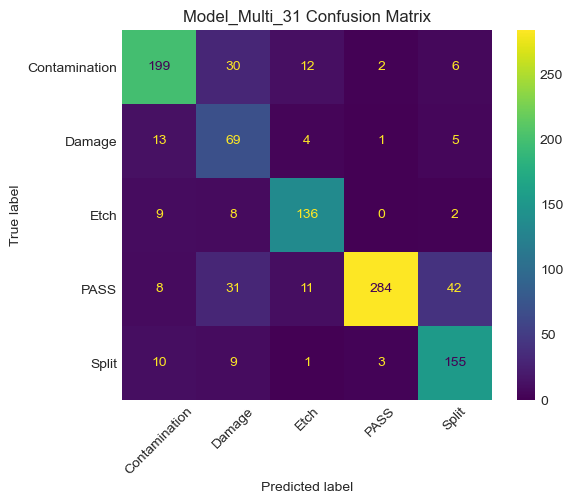

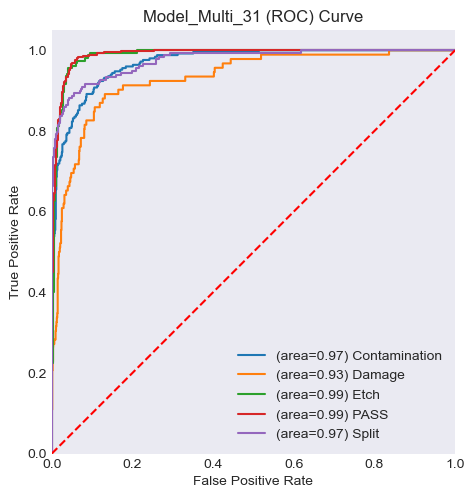

In [ ]:
report_multi_results(model_name, 
                     scale_factor, 
                     model, 
                     test_generator, 
                     pass_max_fpr=0.01, 
                     metric='accuracy', 
                     val_metric='val_accuracy')

### ANALYSIS:
- Test acc = 80.29% at PASS FPR = 0.89%
- PASS False-negative rate = 24.5%

---
### Model Multi 32
Changes:
- Model 23 with PASS FPR adjusted down

In [ ]:
model_name = 'Model_Multi_32'
num_epochs = 100
original_width = 1024
original_height = 943
scale_factor = 0.35
target_size = (int(original_height*scale_factor), int(original_width*scale_factor))

# Instantiate an ImageDataGenerator for the training set with augmentations
train_datagen = ImageDataGenerator(rescale=1./65535,
                                   horizontal_flip=True,
                                   zoom_range=0.05,
                                   height_shift_range=0.05
                                  #  brightness_range=[0.8, 1.2]
)

# Instantiate an ImageDataGenerator for the validation set without augmentations
val_datagen = ImageDataGenerator(rescale=1./65535)

# Instantiate the test generator
test_datagen = ImageDataGenerator(rescale=1./65535)

# create the train generator
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size= target_size,
        batch_size=32,
        shuffle=True,
        color_mode='grayscale',
        class_mode='categorical',
        seed=42
)

# create the validation generator
validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size= target_size,
        batch_size=32,
        shuffle=False,
        color_mode='grayscale',
        class_mode='categorical',
)

# create the test generator
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=32,
        shuffle=False,
        color_mode='grayscale',
        class_mode='categorical',
)


# Get the input shape
input_shape = (target_size[0], target_size[1], 1)

# Define the model
padding = 'valid'
model = Sequential([
    Conv2D(32, (3, 3),
           activation='relu',
           input_shape=input_shape,
           padding=padding),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding=padding),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding=padding),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu', padding=padding),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(512, activation='relu'),
    Dropout(0.2),

    Dense(512, activation='relu'),
    Dropout(0.2),

    Dense(512, activation='relu'),
    Dropout(0.2),

    Dense(256, activation='relu'),

    Dense(256, activation='relu'),
    Dense(5, activation='softmax')
])

# optimizer
from tensorflow.keras.optimizers import RMSprop
optimizer = RMSprop(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


Found 4919 images belonging to 5 classes.
Found 1050 images belonging to 5 classes.
Found 1050 images belonging to 5 classes.


In [ ]:
# Load the weights from the .pkl file
# from tensorflow.keras.models import load_model
model.load_weights('Models\\Model_Multi_23.h5')

model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_44 (Conv2D)          (None, 328, 356, 32)      320       
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 164, 178, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_45 (Conv2D)          (None, 162, 176, 64)      18496     
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 81, 88, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (None, 79, 86, 128)       73856     
                                                                 
 max_pooling2d_46 (MaxPoolin  (None, 39, 43, 128)    

33/33 [==============================] - 25s 753ms/step
 Pre-adjusted Test Accuracy: 0.855
         FPR for PASS class: 0.0089
Pass Probability Adjustment: -0.662000
Post-adjusted Test Accuracy: 0.8019
              precision    recall  f1-score   support

           0       0.87      0.78      0.82       249
           1       0.52      0.72      0.60        92
           2       0.81      0.91      0.86       155
           3       0.98      0.75      0.85       376
           4       0.68      0.90      0.77       178

    accuracy                           0.80      1050
   macro avg       0.77      0.81      0.78      1050
weighted avg       0.84      0.80      0.81      1050



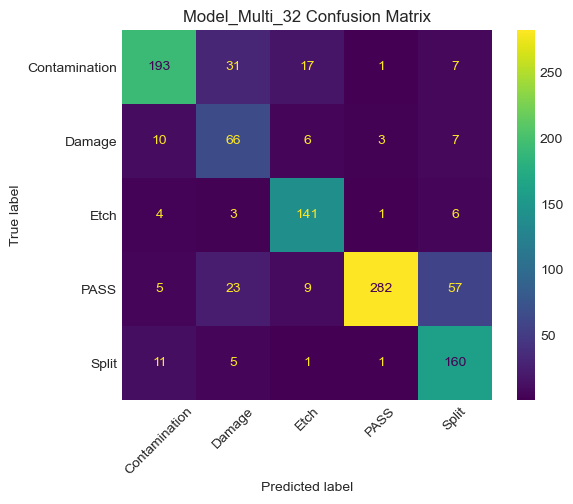

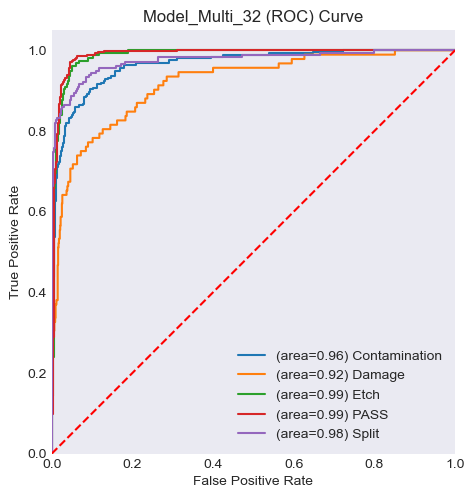

In [ ]:
report_multi_results(model_name, 
                     scale_factor, 
                     model, 
                     test_generator, 
                     pass_max_fpr=0.01, 
                     metric='accuracy', 
                     val_metric='val_accuracy')

### ANALYSIS:
- Test acc = 80.19% at PASS FPR = 0.89%
- PASS False-negative rate = 25.0%

---
### Model Multi 33
Changes:
- Model 28 with PASS FPR adjusted down

In [ ]:
model_name = 'Model_Multi_33'
num_epochs = 100
original_width = 1024
original_height = 943
scale_factor = 0.55
target_size = (int(original_height*scale_factor), int(original_width*scale_factor))

# Instantiate an ImageDataGenerator for the training set with augmentations
train_datagen = ImageDataGenerator(rescale=1./65535,
                                   horizontal_flip=True,
                                   zoom_range=0.05,
                                   height_shift_range=0.05)

# Instantiate an ImageDataGenerator for the validation set without augmentations
val_datagen = ImageDataGenerator(rescale=1./65535)

# Instantiate the test generator
test_datagen = ImageDataGenerator(rescale=1./65535)

# create the train generator
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size= target_size,
        batch_size=16,
        shuffle=True,
        color_mode='grayscale',
        class_mode='categorical',
        seed=42
)

# create the validation generator
validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size= target_size,
        batch_size=16,
        shuffle=False,
        color_mode='grayscale',
        class_mode='categorical',
)

# create the test generator
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=16,
        shuffle=False,
        color_mode='grayscale',
        class_mode='categorical',
)


# Get the input shape
input_shape = (target_size[0], target_size[1], 1)

# Define the model
model = Sequential([
    Conv2D(32, (3, 3),
           activation='relu',
           input_shape=input_shape,
           padding='valid'),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='valid'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='valid'),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu', padding='valid'),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(512, activation='relu'),
    Dropout(0.2),

    Dense(512, activation='relu'),

    Dense(256, activation='relu'),
    Dense(5, activation='softmax')
])

from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])


Found 4919 images belonging to 5 classes.
Found 1050 images belonging to 5 classes.
Found 1050 images belonging to 5 classes.


In [ ]:
# Load the weights from the .pkl file
# from tensorflow.keras.models import load_model
model.load_weights('Models\\Model_Multi_28.h5')

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 516, 561, 32)      320       
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 258, 280, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 256, 278, 64)      18496     
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 128, 139, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 126, 137, 128)     73856     
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 63, 68, 128)     

66/66 [==============================] - 107s 2s/step
 Pre-adjusted Test Accuracy: 0.835
         FPR for PASS class: 0.0089
Pass Probability Adjustment: -0.689000
Post-adjusted Test Accuracy: 0.8048
              precision    recall  f1-score   support

           0       0.88      0.65      0.75       249
           1       0.49      0.74      0.59        92
           2       0.74      0.92      0.82       155
           3       0.98      0.82      0.89       376
           4       0.74      0.92      0.82       178

    accuracy                           0.80      1050
   macro avg       0.77      0.81      0.78      1050
weighted avg       0.84      0.80      0.81      1050



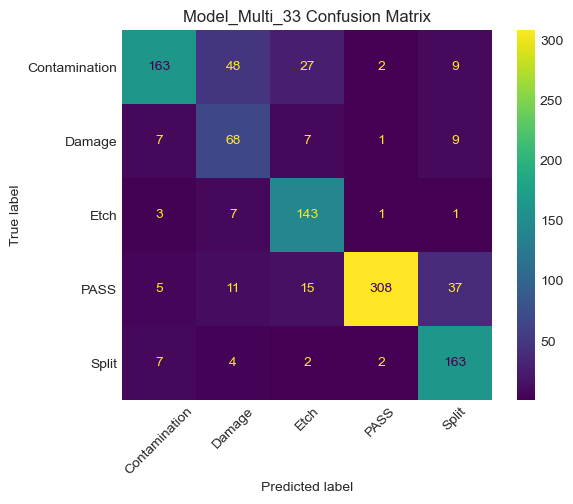

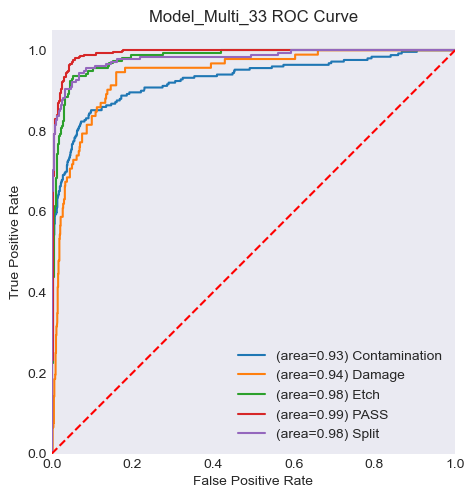

In [ ]:
report_multi_results(model_name, 
                     scale_factor, 
                     model, 
                     test_generator, 
                     pass_max_fpr=0.01, 
                     metric='accuracy', 
                     val_metric='val_accuracy')

### ANALYSIS:
- Test acc = 80.48% at PASS FPR = 0.89%
- PASS False-negative rate = 18.1%
- WE HAVE A WINNER!!!

---
---
## Conclusions

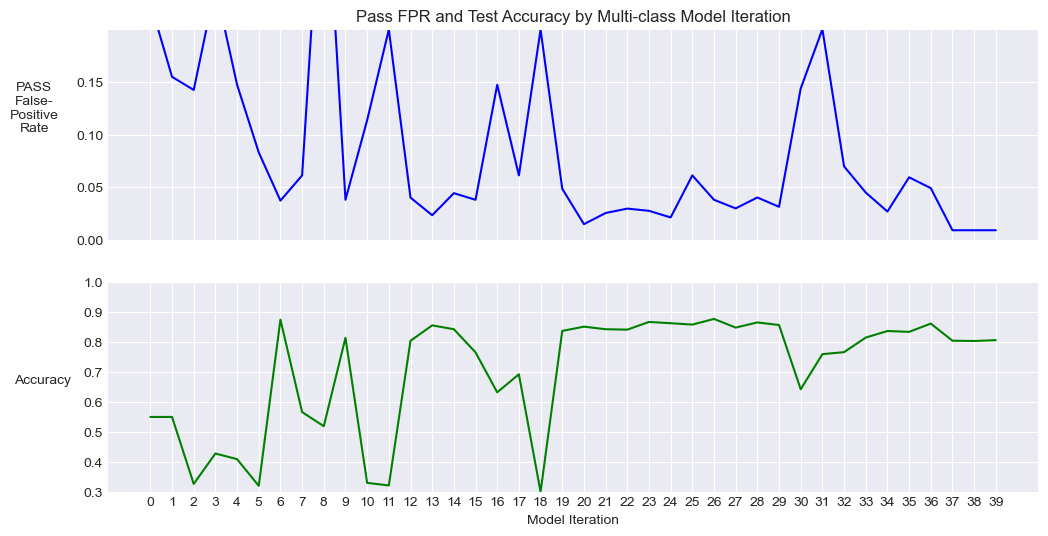

In [56]:
# Display a graph of accuracy for the training and test sets by model iteration
multi_results_df = pd.read_csv('data/model_results.csv')
# remove index 21, the binary model that is apples to these oranges
multi_results_df = multi_results_df.drop(27)
multi_results_df = multi_results_df.reset_index(drop=True)

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 6))

# Plot Test Pass FPR on the top subplot
ax1.plot(multi_results_df['Test Pass FPR'], label='PASS FPR', color='blue')
ax1.set_ylabel('PASS\nFalse-\nPositive\nRate', rotation=0, labelpad=30)
ax1.set_ylim([0, 0.2])
# ax1.legend(loc='lower left')
ax1.set_title('Pass FPR and Test Accuracy by Multi-class Model Iteration')
ax1.set_yticks(np.arange(0, 0.2, 0.05))

# Plot Accuracy on the bottom subplot
ax2.plot(multi_results_df['Test Accuracy'], label='Accuracy', color='green')
ax2.set_xlabel('Model Iteration')
ax2.set_ylabel('Accuracy', rotation=0, labelpad=30)
ax2.set_ylim([0.3, 1])
# ax2.legend(loc='upper left')
ax2.set_yticks(np.arange(0.3, 1.1, 0.1))
ax2.set_xticks(np.arange(0, 40, 1))

# Display the plot
plt.show()


### Shown above is the model progression in Test Accuracy and PASS False-Positive Rate, our key metrics.
- Iterations 0 - 5 are multi-class models from the section 'First Model Attempts'
    - After these iterations we see our first major improvement in accuracy.  
    - This was because I relabeled PASS, Contamination, Damage and Split classes. 
    - No significant model changes caused this increase in performance
- Many of the excursions between iteration 6 and 19 are related to two items:
    - The Colab bug of not running even epochs
    - Attempting new architectures that didn't work out.
- After the classes were more correctly labeled and the Colab epochs issue corrected, there was little improvement despite many different architecture and parameter adjustments.  
- Breaking the 85-87% barrier was never meaningfully achieved.  
    - This in combination with the known issues of image labeling, I believe the best move to increase model performance is to acquire more, and better, image data to train on.

### Best Model Results, Architecture and Parameters:
- Results after probability threshold was adjusted to obtain PASS false-positive rate = 0.89%:
    - Test Accuracy = 80.48%
    - PASS False-negative Rate = 18.1%
    - PASS AUC = 99%
    - Split AUC = 98%
    - Etch AUC = 98%
    - Damage AUC = 94%
    - Contamination AUC = 93%

- Architecture:
    - All activations are relu, except output layer softmax
    - Conv2D 1, 32 filters, kernel size 3x3, padding valid
    - MaxPooling2D 1 at 2x2
    - Conv2D 2, 64 filters, kernel size 3x3, padding valid
    - MaxPooling2D 2 at 2x2
    - Conv2D 3, 128 filters, kernel size 3x3, padding valid
    - MaxPooling2D 3 at 2x2
    - Conv2D 4, 256 filters, kernel size 3x3, padding valid
    - MaxPooling2D 4 at 2x2
    - Flatten
    - Dense 1 at 512 nodes,
    - Dropout at 0.2
    - Dense 2 at 512 nodes,
    - Dense 3 at 256 nodes,
    - Dense 4 (Output) at 5 nodes

- Parameters:
    - Image Scale: 55%
    - Batch Size: 16
    - Optimizer: Adam
    - Learning Rate: 1e-3
    - Loss function: categorical crossentropy
    - Early Stopping: monitor = loss, patience = 5

## Recommendations
1. Initiate a production pilot of provided LMIS Image Classification executable and assess its performance vs. human inspection
   - Recommended pilot evaluation plan:
      - Human review every image for 1 month.  After 1 month:
         - If PASS class false-positive rate <1%, discontinue human evaluation of PASS class images as process of record.
         - Continue long-term human review of all non-PASS images as process of record until model can be improved.
2. Monitor script classification results via provided Power BI dashboard
3. Continue to improve the models with more data as outlined below

## Next Steps
1. Continue to improve the model:
   - Need more data!
      - Subject matter expert labeling of many more images
      - Train with ‘clean’ samples, i.e., no images that could be more than 1 class
   - Continue attempting transfer learning architectures, i.e., ResNet50
2. If adequate model accuracy can be achieved, implement another production pilot to eliminate human inspection of all images

## For More Information
For any additional questions please contact Dale DeFord at:
- daledeford@gmail.com
- https://www.linkedin.com/in/dale-deford-81b54092/